# 1. Importing Libraries and the dataset

In [1]:
import pandas as pd
import numpy as np

import scipy.stats as stats
from scipy.stats import chi2_contingency

import matplotlib.pyplot as plt
import seaborn as sns

import itertools

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold,\
    RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_predict, \
    cross_validate

from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression, LassoCV

from sklearn.impute import KNNImputer

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler, RobustScaler,\
    OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.feature_selection import mutual_info_classif

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier,\
    BaggingClassifier

from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

from sklearn.neural_network import MLPClassifier

from sklearn.svm import SVC

from sklearn.cluster import DBSCAN



import warnings
warnings.filterwarnings('ignore')

In [2]:
train_demo = pd.read_excel('the-smith-parasite/train_demo.xlsx')
train_habits = pd.read_excel('the-smith-parasite/train_habits.xlsx')
train_health = pd.read_excel('the-smith-parasite/train_health.xlsx')

In [3]:
test_demo = pd.read_excel('the-smith-parasite/test_demo.xlsx')
test_habits = pd.read_excel('the-smith-parasite/test_habits.xlsx')
test_health = pd.read_excel('the-smith-parasite/test_health.xlsx')

- Joining the three different datasets into one train set and the test set:

In [4]:
aux_df = train_demo.merge(train_habits, left_on='PatientID', right_on='PatientID')
data_train = aux_df.merge(train_health,left_on='PatientID', right_on='PatientID')
data_train = data_train.reindex(\
                columns = [column for column in data_train.columns if column != 'Disease'] + ['Disease'])
data_train.set_index('PatientID', inplace=True) # set patient id as index

In [5]:
aux_df_test = test_demo.merge(test_habits, left_on='PatientID', right_on='PatientID')
test = aux_df_test.merge(test_health,left_on='PatientID', right_on='PatientID')
test.set_index('PatientID', inplace=True) # set patient id as index

# 2. Data Exploration

In [6]:
train = data_train.copy()

In [7]:
# train.head(3)

Name  Birth_Year                    Region  \
PatientID                                                             
1167       Mrs. Stephanie Gay        1965                    London   
1805         Mr. Sherman Nero        1969                South West   
1557          Mr. Mark Boller        1974  Yorkshire and the Humber   

                                             Education Smoking_Habit  \
PatientID                                                              
1167       High School Incomplete (10th to 11th grade)            No   
1805       High School Incomplete (10th to 11th grade)            No   
1557              Elementary School (1st to 9th grade)            No   

                                Drinking_Habit Exercise  \
PatientID                                                 
1167       I usually consume alcohol every day      Yes   
1805        I consider myself a social drinker      Yes   
1557        I consider myself a social drinker       No   

                                               Fruit_Habit  \
PatientID                                                    
1167       Less than 1. I do not consume fruits every day.   
1805       Less than 1. I do not consume fruits every day.   
1557       Less than 1. I do not consume fruits every day.   

                                              Water_Habit  Height  Weight  \
PatientID                                                                   
1167                     Between one liter and two liters     155      67   
1805                     Between one liter and two liters     173      88   
1557       More than half a liter but less than one liter     162      68   

           High_Cholesterol  Blood_Pressure  Mental_Health  Physical_Health  \
PatientID                                                                     
1167                    358             120             21                2   
1805                    230             142              9                0   
1557                    226             122             26                0   

                     Checkup  \
PatientID                      
1167       More than 3 years   
1805                Not sure   
1557       More than 3 years   

                                                   Diabetes  Disease  
PatientID                                                             
1167       Neither I nor my immediate family have diabetes.        1  
1805       Neither I nor my immediate family have diabetes.        1  
1557       Neither I nor my immediate family have diabetes.        1

- Basic information on the dataset:

In [8]:
#print(train.shape)
#train.info()

(800, 18)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 1167 to 1117
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Name              800 non-null    object
 1   Birth_Year        800 non-null    int64 
 2   Region            800 non-null    object
 3   Education         787 non-null    object
 4   Smoking_Habit     800 non-null    object
 5   Drinking_Habit    800 non-null    object
 6   Exercise          800 non-null    object
 7   Fruit_Habit       800 non-null    object
 8   Water_Habit       800 non-null    object
 9   Height            800 non-null    int64 
 10  Weight            800 non-null    int64 
 11  High_Cholesterol  800 non-null    int64 
 12  Blood_Pressure    800 non-null    int64 
 13  Mental_Health     800 non-null    int64 
 14  Physical_Health   800 non-null    int64 
 15  Checkup           800 non-null    object
 16  Diabetes          800 non-null    object
 17  Di

Only the Education Column has NaNs.

- Descriptive statistics for each feature:

In [9]:
#train.describe().T

count        mean        std     min      25%     50%  \
Birth_Year        800.0  1966.04375  15.421872  1855.0  1961.00  1966.0   
Height            800.0   167.80625   7.976888   151.0   162.00   167.0   
Weight            800.0    67.82750  12.113470    40.0    58.00    68.0   
High_Cholesterol  800.0   249.32250  51.566631   130.0   213.75   244.0   
Blood_Pressure    800.0   131.05375  17.052693    94.0   120.00   130.0   
Mental_Health     800.0    17.34500   5.385139     0.0    13.00    18.0   
Physical_Health   800.0     4.55875   5.449189     0.0     0.00     3.0   
Disease           800.0     0.51375   0.500124     0.0     0.00     1.0   

                     75%     max  
Birth_Year        1974.0  1993.0  
Height             173.0   180.0  
Weight              77.0    97.0  
High_Cholesterol   280.0   568.0  
Blood_Pressure     140.0   200.0  
Mental_Health       21.0    29.0  
Physical_Health      7.0    30.0  
Disease              1.0     1.0

The minimum of `Birth_Year` is suspect. We'll look further into it when we analyse the features individually.

In [10]:
#train['Birth_Year'].max()-train['Birth_Year'].min() #age gap

138

In [11]:
#train.describe(exclude=[np.number]).T

count unique                                               top  \
Name             800    799                                   Mr. Gary Miller   
Region           800     10                                     East Midlands   
Education        787      6             University Complete (3 or more years)   
Smoking_Habit    800      2                                                No   
Drinking_Habit   800      3               I usually consume alcohol every day   
Exercise         800      2                                                No   
Fruit_Habit      800      5   Less than 1. I do not consume fruits every day.   
Water_Habit      800      3                  Between one liter and two liters   
Checkup          800      4                                 More than 3 years   
Diabetes         800      4  Neither I nor my immediate family have diabetes.   

               freq  
Name              2  
Region          154  
Education       239  
Smoking_Habit   673  
Drinking_Habit  406  
Exercise        536  
Fruit_Habit     452  
Water_Habit     364  
Checkup         429  
Diabetes        392

- Checking the balance of the dataset:

In [12]:
#train.groupby('Disease')['Disease'].count()

Disease
0    389
1    411
Name: Disease, dtype: int64

### Exploring each feature

In [13]:
#metric_feat = ['Birth_Year','Height','Weight','High_Cholesterol','Blood_Pressure','Mental_Health','Physical_Health']
#cat_feat = ['Region','Education','Smoking_Habit','Drinking_Habit','Exercise','Fruit_Habit','Water_Habit','Checkup',
#           'Diabetes']

#### Boxplots of all metric features to check for possible outliers

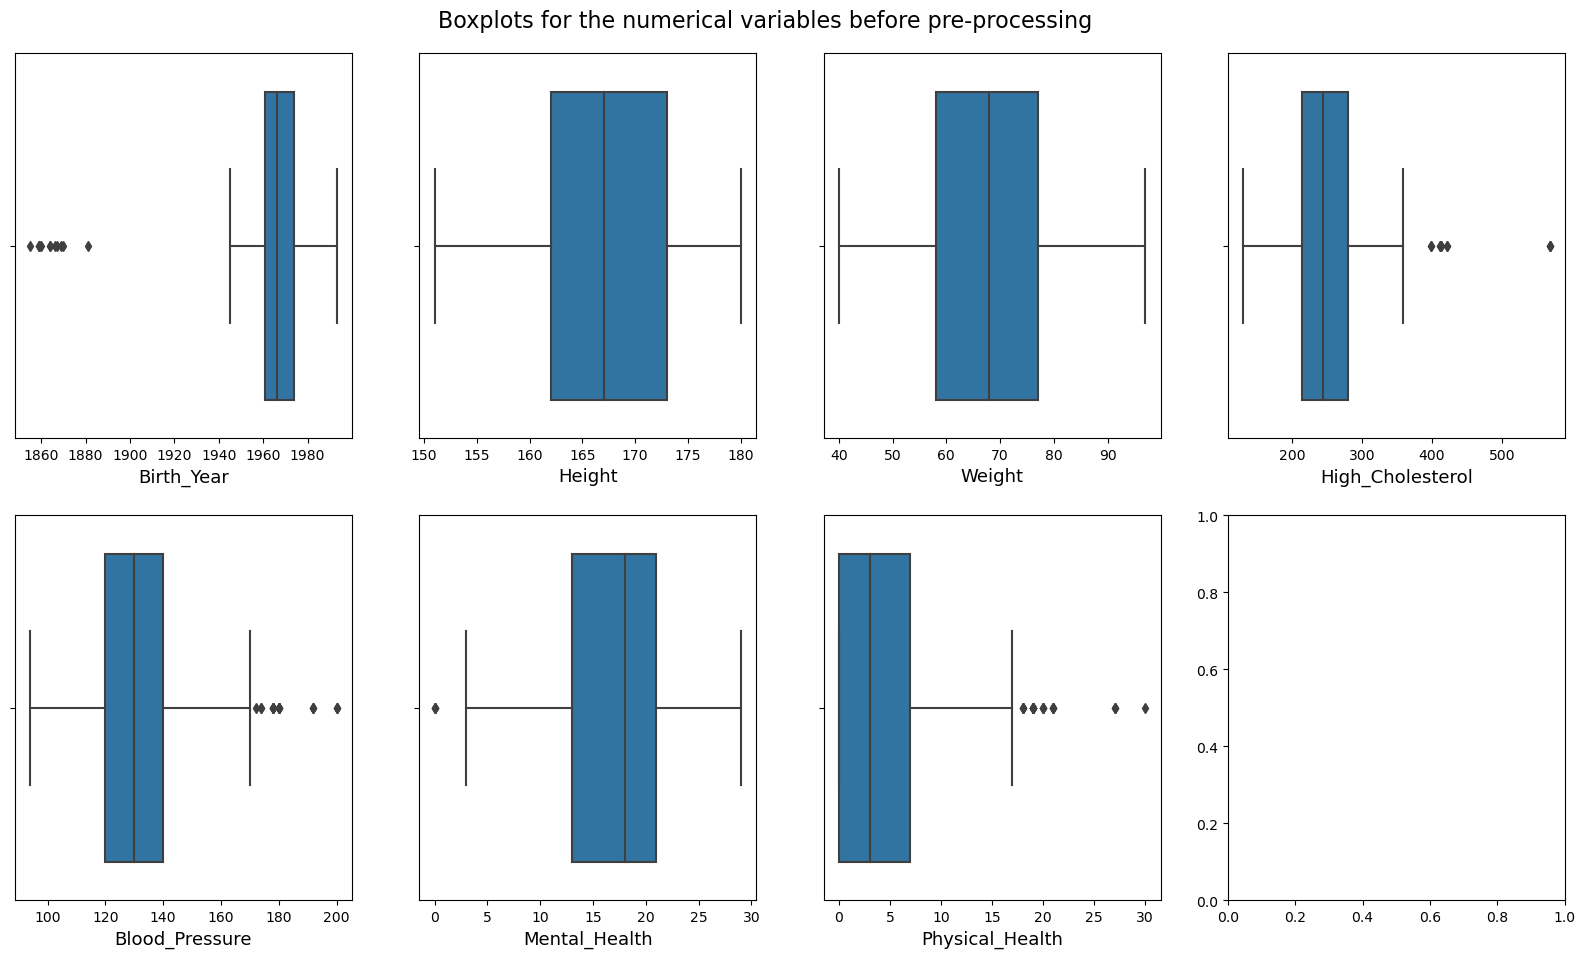

In [14]:
# Code by Professor Farina Pontejos
#fig, axes = plt.subplots(2, 4, figsize=(20, 11))

#for ax, feat in zip(axes.flatten(), metric_feat): # Notice the zip() function and flatten() method
 #   sns.boxplot(x=train[feat], ax=ax)
  #  ax.set_xlabel(xlabel = feat, fontsize = 13)

#plt.suptitle("Boxplots for the numerical variables before pre-processing", size= 16,y=0.92)

#plt.show()

#### Histograms of all metric features

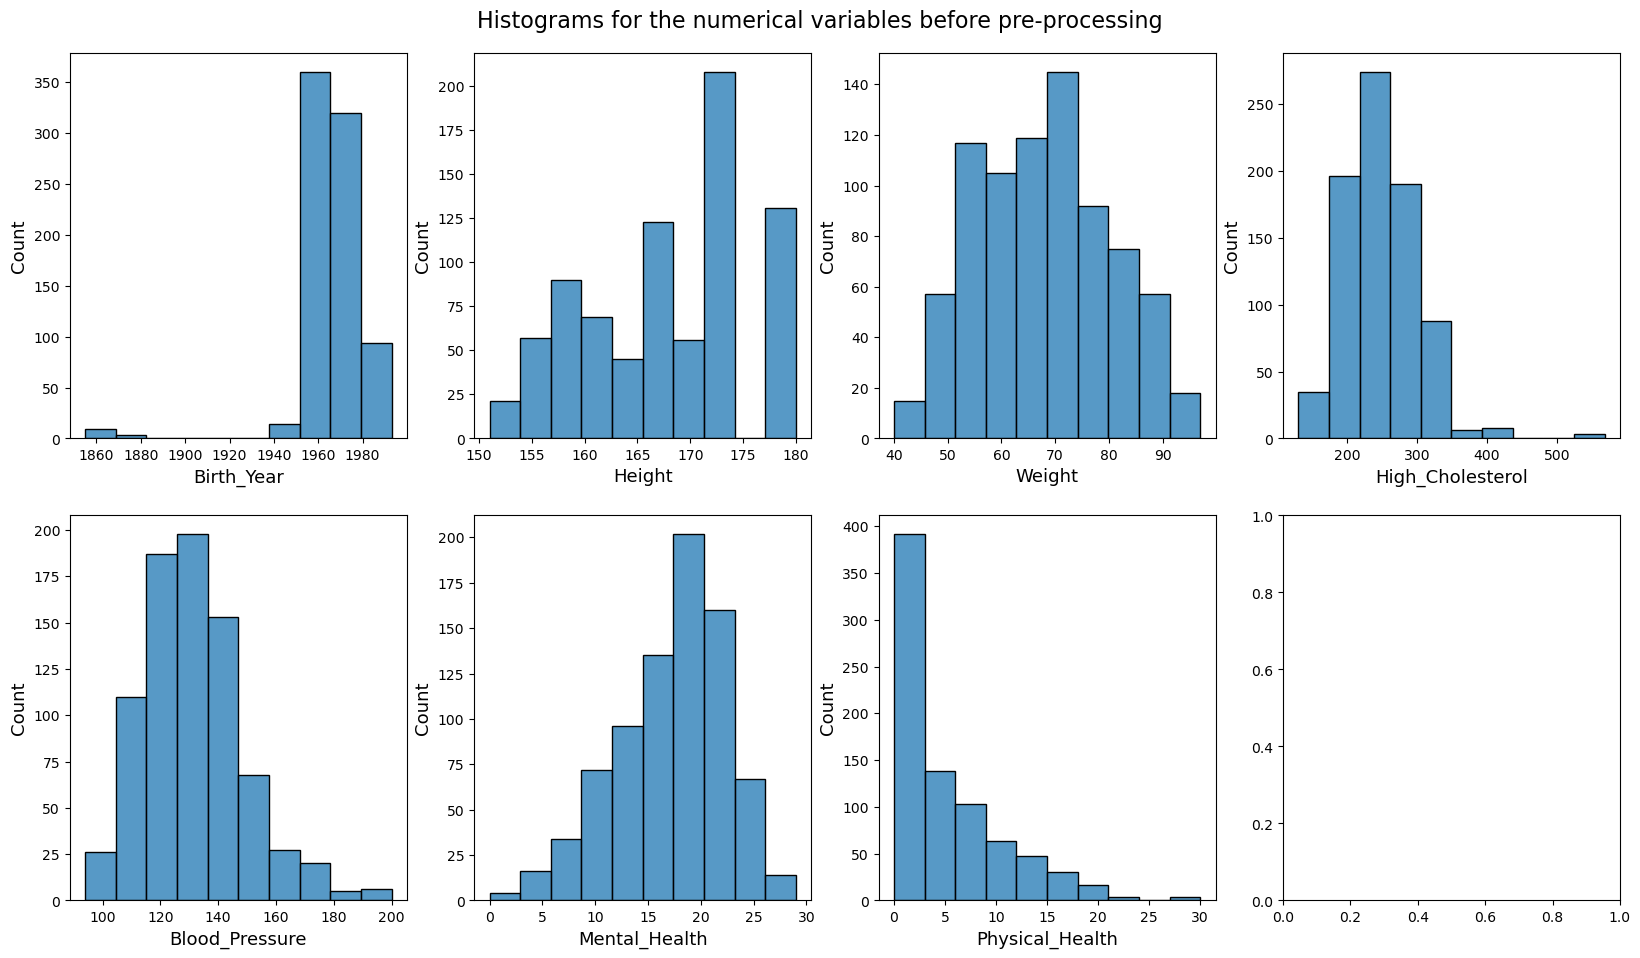

In [15]:
# Code by Professor Farina Pontejos
#fig, axes = plt.subplots(2, 4, figsize=(20, 11))

#for ax, feat in zip(axes.flatten(), metric_feat): # Notice the zip() function and flatten() method
#    sns.histplot(x=train[feat], ax=ax, bins=10,binrange = (train[feat].min(),train[feat].max()))
#    ax.set_xlabel(xlabel = feat, fontsize = 13)
#    ax.set_ylabel(ylabel = 'Count', fontsize = 13)

#plt.suptitle("Histograms for the numerical variables before pre-processing", size= 16,y=0.92)

#plt.show()

#### Scattterplots of all metric features

Text(0.5, 1.02, 'Scatterplots of metric features before pre-processing')

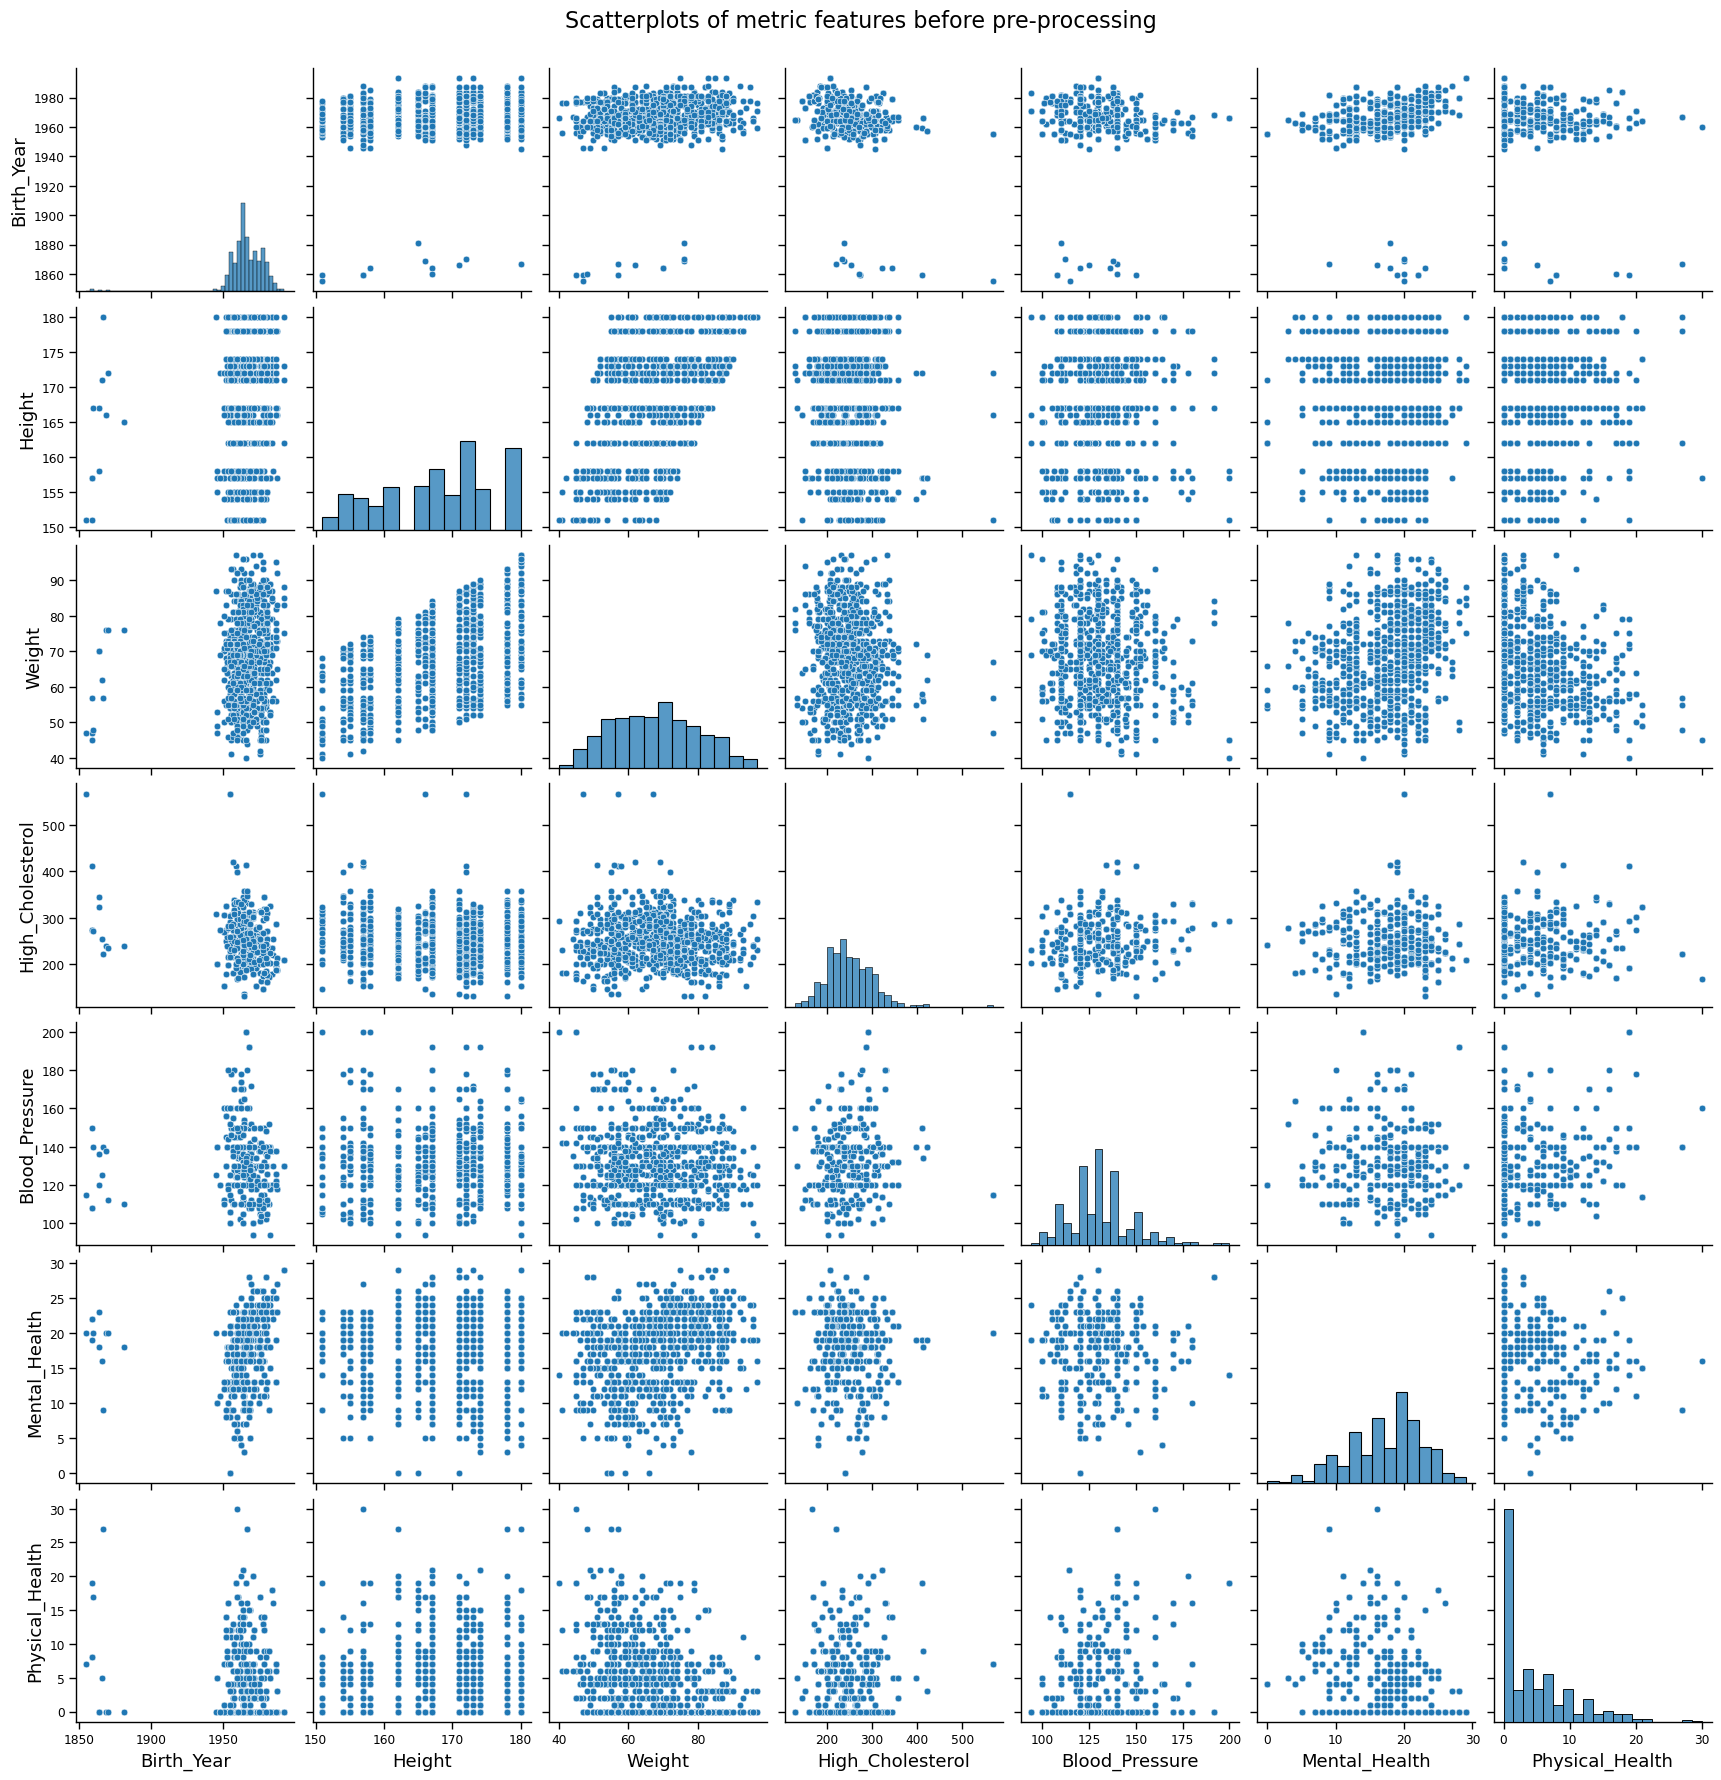

In [16]:
#sns.set_context("paper", rc={"axes.labelsize":13})
#sns.suptitle('Scatterplots of metric features before pre-processing', fontsize = 16)
#g = sns.pairplot(train[metric_feat], diag_kind="hist")
#g.fig.suptitle("Scatterplots of metric features before pre-processing",y =1.02, fontsize = 16)

#### Histograms of all metric features divided by target

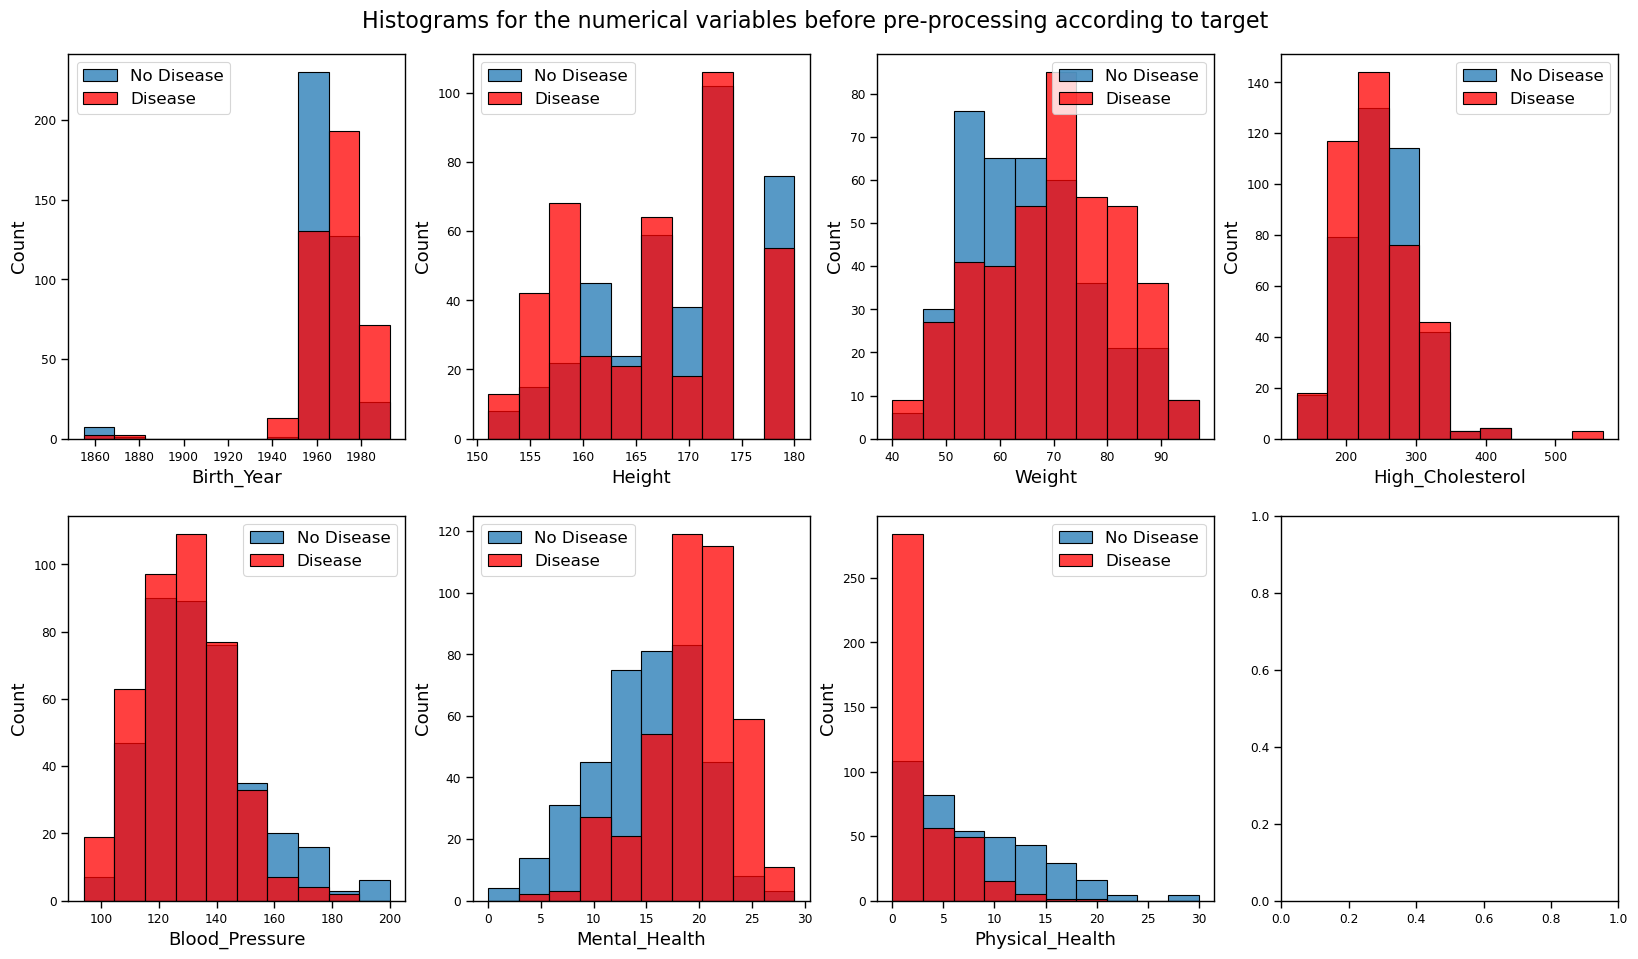

In [17]:
#fig, axes = plt.subplots(2, 4, figsize=(20, 11))

#for ax, feat in zip(axes.flatten(), metric_feat): # Notice the zip() function and flatten() method
#    sns.histplot(x=train[train['Disease'] == 0][feat], ax=ax, label = 'No Disease', bins=10,binrange = (train[feat].min(),train[feat].max()))
#    sns.histplot(x=train[train['Disease'] == 1][feat], ax=ax, color ='red', label = 'Disease', bins=10,binrange = (train[feat].min(),train[feat].max()))
#    ax.legend(labels = ['No Disease', 'Disease'], loc ='best',fontsize =12)
#    ax.set_xlabel(xlabel = feat, fontsize = 13)
#    ax.set_ylabel(ylabel = 'Count', fontsize = 13)

#plt.suptitle("Histograms for the numerical variables before pre-processing according to target ", size= 16,y=0.92)


#plt.show()

#### Barplots of all categorical features divided by target

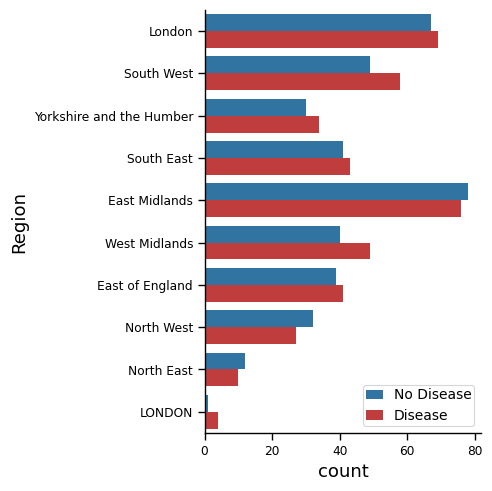

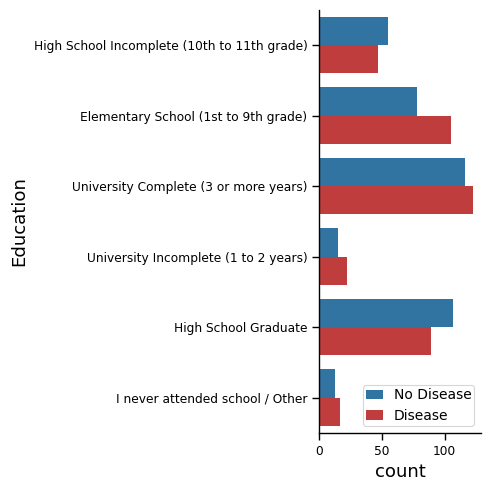

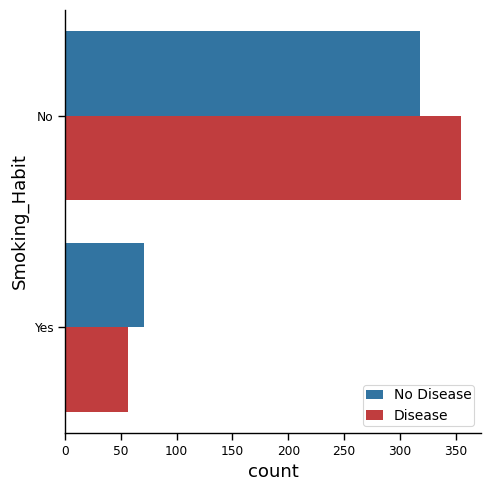

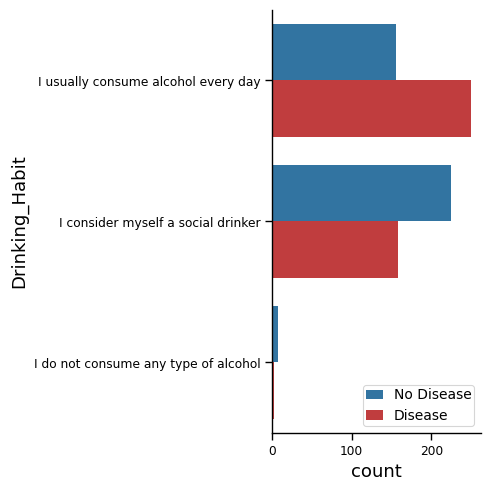

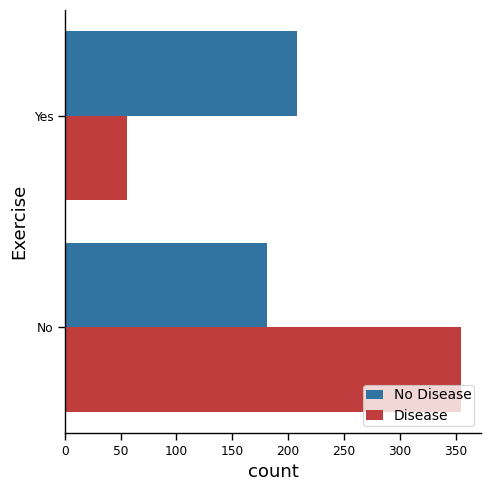

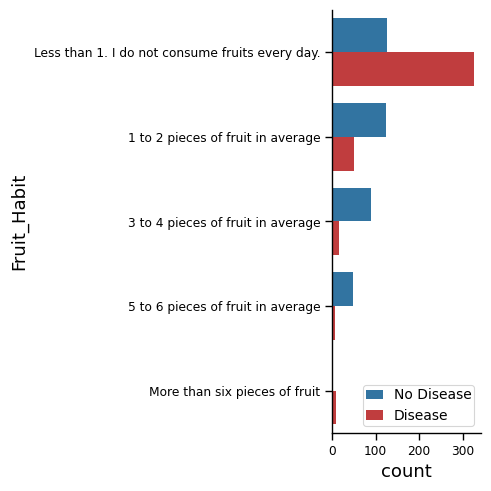

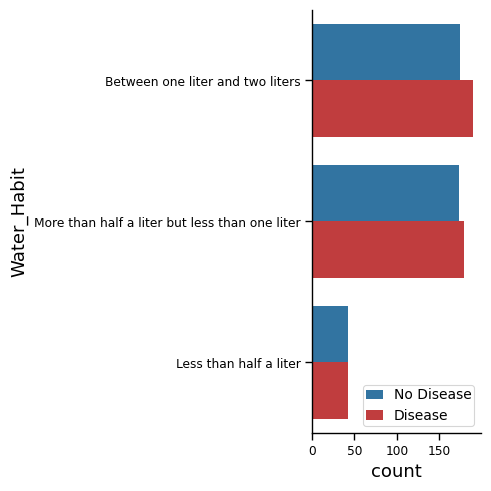

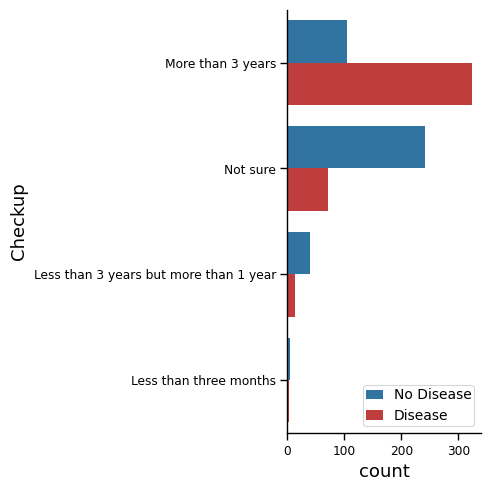

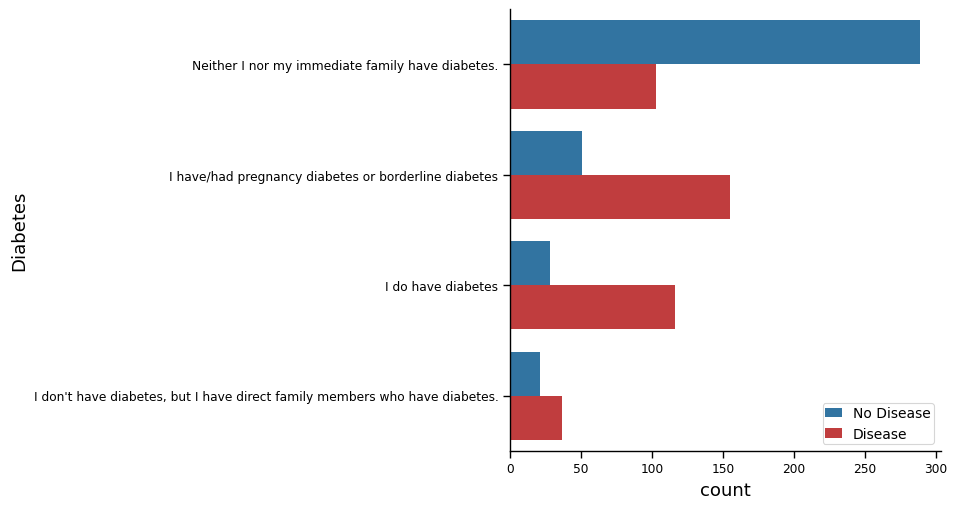

In [18]:
#for feat in cat_feat: # Notice the zip() function and flatten() method
#    sns.catplot(y =feat,data=train, hue = 'Disease', kind ='count',palette =["C0", "C3"], legend =False)
#    plt.legend(labels = ['No Disease', 'Disease'], loc = 'lower right',fontsize =10,borderpad = 0.2, handlelength = 1.2)

#plt.show()

#### Individual decisions for each feature

- __`Name`__: This variable will only be important to determine gender.

- __`Birth_Year`__:

In [19]:
#print(sorted(train.loc[train['Birth_Year'] < 1900,'Birth_Year'].values))

[1855, 1859, 1859, 1859, 1860, 1864, 1864, 1866, 1867, 1869, 1870, 1881]


In [20]:
#print(sorted(train.loc[train['Birth_Year'] > 1900,'Birth_Year'].values)[0])

1945


There are clear outliers on this variable. They actually don't make any sense, because they say there are people who are born over 140 years ago (even if the dataset was old, it would not be older than 2000 probably, so these people would have to be more than 120 years old still.

There are some ways we could deal with this:

 1) As these outliers don't make any sense at all, i think it would not work to use them in any model as they are, with the wrong birth year. So, one way to deal with them is just remove the rows where this happens;
 
 2) Another way to deal with this is to change the number "8" on these birth years to a "9", as it is impossible that these people's birth year is in the 1700s or in the 2050s and beyond, so the only option for this approach would be to deal with these values as typos and replace the number 8;
 
 3) If we want to avoid making assumptions about whether or not these were typos, and don't want to delete these rows, we could just treat these as missing values, using whatever technique we choose later to deal with them as we will with other variables.

- __`Region`__:

In [21]:
#print(train['Region'].drop_duplicates().values)

['London' 'South West' 'Yorkshire and the Humber' 'South East'
 'East Midlands' 'West Midlands' 'East of England' 'North West'
 'North East' 'LONDON']


In [22]:
#train['Region'].value_counts()

East Midlands               154
London                      136
South West                  107
West Midlands                89
South East                   84
East of England              80
Yorkshire and the Humber     64
North West                   59
North East                   22
LONDON                        5
Name: Region, dtype: int64

There is a clear mistake with two ways to write London. We'll change all of them to the way of writing which is the same as the way the other regions are written and the way most of the Londons are written.

- __`Education`__: 

It's the only column to explicitly have missing values.

In [23]:
#train['Education'].value_counts()

University Complete (3 or more years)          239
High School Graduate                           196
Elementary School (1st to 9th grade)           183
High School Incomplete (10th to 11th grade)    102
University Incomplete (1 to 2 years)            37
I never attended school / Other                 30
Name: Education, dtype: int64

It looks like this is an ordinal variable, so it is likely that we'll ordinal encode it later. There are 13 missing values. We can:

1) Do imputing using KNNImputer;

2) Do imputing using a centrality measure;

3) Put them in the category of "I never attended school/other";

4) Delete the rows which have missing values (doesn't seem good because our dataset is already pretty small).

- __`Smoking_Habit`__: 

In [24]:
#print(train['Smoking_Habit'].value_counts())

No     673
Yes    127
Name: Smoking_Habit, dtype: int64


Just a binary feature with no missing values. Has much more "No" than "Yes". In that way, it is very unbalanced.

- __`Drinking_Habit`__:

In [25]:
#train['Drinking_Habit'].value_counts()

I usually consume alcohol every day     406
I consider myself a social drinker      383
I do not consume any type of alcohol     11
Name: Drinking_Habit, dtype: int64

Another categorical feature.  There isn't exactly an ordinal relationship, but there seems to be a "more and less" relationship, so ordinal encoding should be fine.

- __`Exercise`__: 

In [26]:
#train['Exercise'].value_counts()

No     536
Yes    264
Name: Exercise, dtype: int64

Binary feature, also a little unbalanced.

- __`Fruit_Habit`__: 

In [27]:
#train['Fruit_Habit'].value_counts()

Less than 1. I do not consume fruits every day.    452
1 to 2 pieces of fruit in average                  175
3 to 4 pieces of fruit in average                  105
5 to 6 pieces of fruit in average                   56
More than six pieces of fruit                       12
Name: Fruit_Habit, dtype: int64

- __`Water_Habit`__:

In [28]:
#train['Water_Habit'].value_counts()

Between one liter and two liters                  364
More than half a liter but less than one liter    352
Less than half a liter                             84
Name: Water_Habit, dtype: int64

- __`Height`__ and __`Weight`__:

There aren't any missing values, and there don't seem to be any outliers.

- __`High_Cholesterol`__:

There are some outliers, but their values seem to be real, not mistakes. We can:

1) Remove the rows where they are;

2) Treat them as missing values;

3) Try a model with them, as some of they don't seem like plain wrong values, because they could, in theory, exist.

- __`Blood_Pressure`__:

Also has some outliers. The approach is identical to the one with High Cholesterol. Actually, it would be nice to check if these outliers are in the same patients who have high cholesterol, so let's see:

In [29]:
#train.loc[(train['High_Cholesterol'] > 370) & (train['Blood_Pressure'] > 170),:]

Empty DataFrame
Columns: [Name, Birth_Year, Region, Education, Smoking_Habit, Drinking_Habit, Exercise, Fruit_Habit, Water_Habit, Height, Weight, High_Cholesterol, Blood_Pressure, Mental_Health, Physical_Health, Checkup, Diabetes, Disease]
Index: []

No, they are not the same. So they are just different outliers, which is a pitty if the approach was to remove them as with this there will be a higher percentage of data removed.

- __`Mental_Health`__:

In [30]:
#train[train['Mental_Health']<3].shape[0]

4

The 0 seems to be an outlier. This feature is based on a question the patients were asked to say how many days on the current month their physical and/or mental health was impeding them from doing usual daily activities (more on a mental activity pov). There could be 0s, for healthy people in that regard, so the 0 is just another value. There are 4 people with 0. 

There's only one outlier value and it seems important for us to keep it, because without it the range of values in Mental Health would be reduced and we wouldn't have people with fully positive mental health in our sample. The decision for this one is to keep them all.

- __`Physical_Health`__:

This feature is really similar to the one above, but relates only physical health to the inability or difficulty to walk in the past 30 days. The distribution is really skewed but the number of days considered outliers could be relevant if they could "teach" something to the model.

- __`Checkup`__:

In [31]:
#train['Checkup'].value_counts()

More than 3 years                         429
Not sure                                  312
Less than 3 years but more than 1 year     53
Less than three months                      6
Name: Checkup, dtype: int64

"Not sure" doesn't seem to give us that much information, because it just groups every person who just does not know when they went to the doctor, not a timespan of when. So, it seems like this value for this feature is a "hidden" way of having missing values. This feature may have to be deleted, as almost half of its values are not known. Treating these as missing values and imputing, even with the KNNImputer, seems excessive in the sense that it would impact the model a lot to have 312 imputed values where we don't know if they are correct, teaching the model possibly wrong patterns. Deleting the rows is not an option. So, the options are:

1) Delete the feature;

2) Keeping it and using it as a binary sure/not sure;

3) Keep it all and just encode everything including the not sure feature.

- __`Diabetes`__:

In [32]:
#train['Diabetes'].value_counts()

Neither I nor my immediate family have diabetes.                              392
I have/had pregnancy diabetes or borderline diabetes                          206
I do have diabetes                                                            144
I don't have diabetes, but I have direct family members who have diabetes.     58
Name: Diabetes, dtype: int64

#### Checking for outliers in the context of all dimensions with DBSCAN

In [33]:
#df_dbscan = train.copy()

In [34]:
#MinPts
#2*len(metric_feat)

14

- Check the right value for epsilon (acceptable distance from another point to be in the cluster) for dbscan:

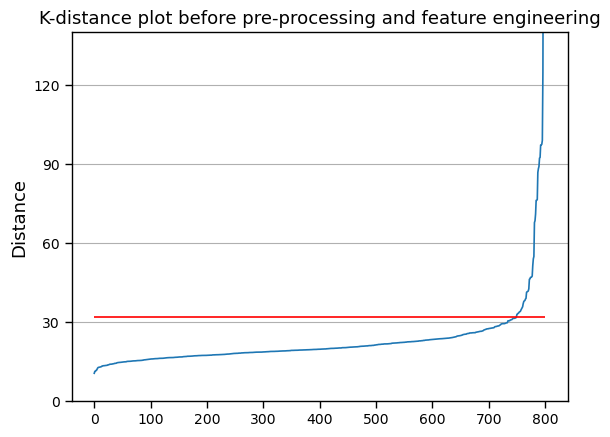

In [35]:
# Code made by professor Farina Pontejos
#neigh = NearestNeighbors(n_neighbors=14) #=MinPts
#neigh.fit(df_dbscan[metric_feat])
#distances, _ = neigh.kneighbors(df_dbscan[metric_feat])
#distances = np.sort(distances[:, -1])
#plt.plot(distances)
#plt.title(label = 'K-distance plot before pre-processing and feature engineering', fontsize=13)
#plt.yticks(range(0,150,30), fontsize=10)
#plt.xticks(range(0,900,100), fontsize=10)
#plt.hlines(32, 0, 800, color='red')
#plt.ylim(0,140)
#plt.grid(axis='y')
#plt.ylabel('Distance')
#plt.show()

In [36]:
# dbscan = DBSCAN(eps=32, min_samples=14, n_jobs=-1)
# dbscan_labels = dbscan.fit_predict(df_dbscan[metric_feat])

# dbscan_n_clusters = len(np.unique(dbscan_labels))
# print("Number of estimated clusters :", dbscan_n_clusters)

Number of estimated clusters : 2


In [37]:
# df_db = pd.concat([df_dbscan[metric_feat], pd.Series(dbscan_labels, index=df_dbscan.index, name="dbscan_labels")], axis=1)
# # The outliers have labels -1
# len(df_db.loc[df_db['dbscan_labels'] == -1])

33

There are 33 possible outliers, let's get back to this when we treat the outliers individually in the ways we suggested above.

# 3. Data Pre-processing

In [17]:
X_train = train.drop('Disease',axis=1)
y_train = train.loc[:,'Disease']

- Solving the London/LONDON problem

In [18]:
X_train.loc[train['Region']=='LONDON','Region'] = 'London'

- Birth Year incoherencies:

In [19]:
## Approach of changing the number 8 to a 9 in the birth years where
## the second digit is an 8 (prefered approach):

X_train.loc[X_train['Birth_Year'] < 1900,'Birth_Year'] = \
            [int('19'+X_train.loc[X_train['Birth_Year'] < 1900,'Birth_Year'].values.astype(str)[i][2:]) \
             for i in range(len(X_train.loc[X_train['Birth_Year'] < 1900,:]))]

- High_Cholesterol and Blood_Pressure outliers: keep

- Checkup "Not sure" values: will be in Feature engineering function

## Feature Engineering

In [20]:
def feat_eng(X_train):

    ## Creation of a `Gender` feature using the Names of the patients.
    ## This is the only use for the Name feature.

    X_train['Gender'] = X_train['Name'].apply(lambda x: 'F' if x.split()[0] == 'Mrs.' else 'M')

    ## Creation of a `BMI` feature for a ratio between height and weight.

    X_train['BMI'] = round(X_train['Weight']/((X_train['Height']/100)**2),2)

    ## Removal of Name:

    X_train.drop('Name',axis=1, inplace= True)
    
    ## Checkup sure feature
    X_train['Checkup_sure'] = X_train['Checkup'].apply(lambda c: c != 'Not sure')
    X_train.drop('Checkup', axis=1, inplace= True)

    
    return X_train

X_train = feat_eng(X_train)

In [21]:
metric_feat = ['Birth_Year','Height','Weight','High_Cholesterol','Blood_Pressure','Mental_Health','Physical_Health','BMI']
cat_feat = ['Region','Education','Smoking_Habit','Drinking_Habit','Exercise','Fruit_Habit','Water_Habit',
            'Diabetes','Gender', 'Checkup_sure']

### Repeating the DBScan to check the final number of outliers:

In [43]:
# df_dbscan = X_train.copy()

In [44]:
# #MinPts
# 2*len(metric_feat)

16

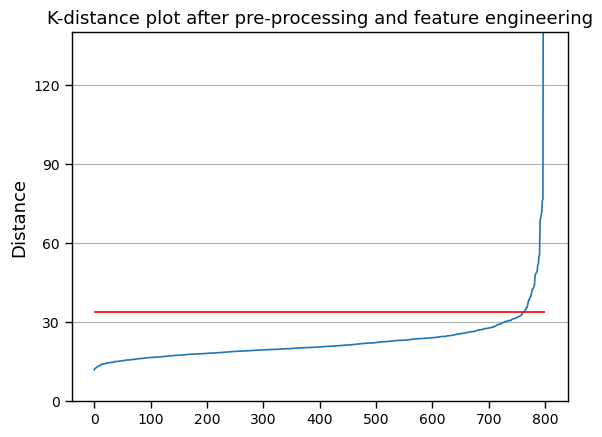

In [45]:
# # Code made by professor Farina Pontejos
# neigh = NearestNeighbors(n_neighbors=16)
# neigh.fit(df_dbscan[metric_feat])
# distances, _ = neigh.kneighbors(df_dbscan[metric_feat])
# distances = np.sort(distances[:, -1])
# plt.plot(distances)
# plt.title(label = 'K-distance plot after pre-processing and feature engineering', fontsize=13)
# plt.yticks(range(0,150,30), fontsize=10)
# plt.xticks(range(0,900,100), fontsize=10)
# plt.hlines(34, 0, 800, color='red')
# plt.ylim(0,140)
# plt.grid(axis='y')
# plt.ylabel('Distance')
# plt.show()

In [46]:
# # Perform DBSCAN clustering
# dbscan = DBSCAN(eps=34, min_samples=16, n_jobs=-1)
# dbscan_labels = dbscan.fit_predict(df_dbscan[metric_feat])

# # Concatenating the labels to df
# df_db = pd.concat([df_dbscan[metric_feat], pd.Series(dbscan_labels, index=df_dbscan.index, name="dbscan_labels")], axis=1)
# df_db.head()

# # Detecting noise (potential outliers)
# len(df_db.loc[df_db['dbscan_labels'] == -1])

18

There are still 18 outliers.

## Encoding, Imputing and Scaling

These are all steps which will be included in the pipeline to prevent data leakage. So, we just have to create the preprocessor we want to use for each of them and then include it in the pipeline with the predictive model.

The pipeline creation will only be done on the predictive model part, as it has to include it. For feature selection, we have to do these three things to the dataset, so we can see correlations, etc, but we'll create a dataset for it so it doesn't contamine the later pipeline.

In [22]:
## Create the ordinal categories to put them in the right order (used for everything)
education_categories = ['I never attended school / Other', 'Elementary School (1st to 9th grade)', 
                        'High School Incomplete (10th to 11th grade)', 'High School Graduate',
                        'University Incomplete (1 to 2 years)', 'University Complete (3 or more years)',np.nan]
smoking_categories = ['No', 'Yes']
drink_categories = ['I do not consume any type of alcohol',
                    'I consider myself a social drinker', 'I usually consume alcohol every day']
exercise_categories = ['No','Yes']
fruit_categories = ['Less than 1. I do not consume fruits every day.',
                   '1 to 2 pieces of fruit in average',
                   '3 to 4 pieces of fruit in average',
                   '5 to 6 pieces of fruit in average',
                   'More than six pieces of fruit']
water_categories = [ 'Less than half a liter', 'More than half a liter but less than one liter',
                    'Between one liter and two liters']
diabetes_categories = ['Neither I nor my immediate family have diabetes.',
                      "I don't have diabetes, but I have direct family members who have diabetes.",
                      'I have/had pregnancy diabetes or borderline diabetes',
                      'I do have diabetes']
gender_categories = ['M','F']
checkup_categories = [False,True]

Because we only want to scale numeric data, we have to somehow tell the pipeline to do training and transforming of the scaler only on metric features, so we don't scale the categorical features, because they may lose meaning. So, we'll use something called ColumnTranformer, which allows us to build a preprocessor only for the numeric features and another for categorical and hereby solve that problem. It also allows us to do all of it at once (https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html). We create a function because a preprocessor will be different according to which features we use.

In [23]:
def create_preprocessor(chosen_scaler, numeric_features, ordinal_features, categories, region = False, impute = False):

    ## Create the encoding model
    ordenc = OrdinalEncoder(categories= categories)        

    ### Scaling
    scaler = chosen_scaler
    
    ### Preprocessor

    numeric_transformer = scaler

    if impute:
        imputer = KNNImputer(n_neighbors=1)
        
        categorical_transformer = Pipeline(
            steps=[ ("encoder", ordenc),("imputer",imputer)])
    else:
        categorical_transformer = ordenc

    if region:
        region_transformer = OneHotEncoder(handle_unknown="ignore")
        
        preprocessor = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, numeric_features),
                ("cat", categorical_transformer, ordinal_features),
                ("reg", region_transformer, ['Region'])
            ]
        )

    else:
        preprocessor = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, numeric_features),
                ("cat", categorical_transformer, ordinal_features),
            ]
        )
    
    return preprocessor

## Feature Selection

As we know, we don't want to scale our data beforehand so we don't have data leakage. Because of this, feature selection will be done with a separate dataset from the training/validation sets, a copy of the original train one, so we can later use the one we partitioned not preprocessed in the cross validation with the selected features.


In [49]:
# X_featsel = X_train.copy()
# y_featsel = y_train.copy()

In [50]:
# X_featsel['Region'].unique()

array(['London', 'South West', 'Yorkshire and the Humber', 'South East',
       'East Midlands', 'West Midlands', 'East of England', 'North West',
       'North East'], dtype=object)

In [10]:
## To put on the creation of the preprocessor
# ordinal = ['Education','Smoking_Habit','Drinking_Habit','Exercise','Fruit_Habit',
#            'Water_Habit','Diabetes','Gender', 'Checkup_sure']

# categories=[education_categories, smoking_categories, drink_categories,
#                                     exercise_categories, fruit_categories, water_categories, 
#                                     diabetes_categories,gender_categories, checkup_categories]

In [12]:
# preprocessor = create_preprocessor(MinMaxScaler(), metric_feat, ordinal, categories, region = True, impute = True)

In [53]:
# preprocessor

In [54]:
# featsel = pd.DataFrame(preprocessor.fit_transform(X_featsel),
#              columns = ['Birth_Year', 'Height', 'Weight', 'High_Cholesterol', 'Blood_Pressure',
#        'Mental_Health', 'Physical_Health', 'BMI', 'Education_enc',
#        'Smoking_Habit_enc', 'Drinking_Habit_enc', 'Exercise_enc',
#        'Fruit_Habit_enc', 'Water_Habit_enc', 'Diabetes_enc', 'Gender_enc',
#        'Checkup_sure_enc', 'Region_East Midlands', 'Region_East of England',
#        'Region_London', 'Region_North East', 'Region_North West',
#        'Region_South East', 'Region_South West', 'Region_West Midlands',
#        'Region_Yorkshire and the Humber'], index = X_featsel.index).join(y_featsel)

In [55]:
# featsel.head()

Birth_Year    Height    Weight  High_Cholesterol  Blood_Pressure  \
PatientID                                                                     
1167         0.416667  0.137931  0.473684          0.520548        0.245283   
1805         0.500000  0.758621  0.842105          0.228311        0.452830   
1557         0.604167  0.379310  0.491228          0.219178        0.264151   
1658         0.270833  1.000000  0.456140          0.417808        0.292453   
1544         0.479167  1.000000  0.315789          0.335616        0.292453   

           Mental_Health  Physical_Health       BMI  Education_enc  \
PatientID                                                            
1167            0.724138         0.066667  0.830289            2.0   
1805            0.310345         0.000000  0.945205            2.0   
1557            0.896552         0.000000  0.679604            1.0   
1658            0.448276         0.266667  0.257991            5.0   
1544            0.620690         0.066667  0.070015            4.0   

           Smoking_Habit_enc  ...  Region_East Midlands  \
PatientID                     ...                         
1167                     0.0  ...                   0.0   
1805                     0.0  ...                   0.0   
1557                     0.0  ...                   0.0   
1658                     0.0  ...                   0.0   
1544                     0.0  ...                   0.0   

           Region_East of England  Region_London  Region_North East  \
PatientID                                                             
1167                          0.0            1.0                0.0   
1805                          0.0            0.0                0.0   
1557                          0.0            0.0                0.0   
1658                          0.0            1.0                0.0   
1544                          0.0            0.0                0.0   

           Region_North West  Region_South East  Region_South West  \
PatientID                                                            
1167                     0.0                0.0                0.0   
1805                     0.0                0.0                1.0   
1557                     0.0                0.0                0.0   
1658                     0.0                0.0                0.0   
1544                     0.0                1.0                0.0   

           Region_West Midlands  Region_Yorkshire and the Humber  Disease  
PatientID                                                                  
1167                        0.0                              0.0        1  
1805                        0.0                              0.0        1  
1557                        0.0                              1.0        1  
1658                        0.0                              0.0        0  
1544                        0.0                              0.0        1  

[5 rows x 27 columns]

In [56]:
# X_featsel = featsel.drop('Disease',axis=1)
# y_featsel = featsel['Disease']

### 1) Check for univariate variables

In [57]:
# ### defining a color green to when our dataset says "yes" for a certain feature
# def colors(val):
#     if val == 'Yes':
#         color = 'background-color: green'
#     else:
#         color = ''
#     return color

In [58]:
# featsel[metric_feat].var() #no univariate metric variables

Birth_Year          0.034942
Height              0.075661
Weight              0.045163
High_Cholesterol    0.013861
Blood_Pressure      0.025881
Mental_Health       0.034482
Physical_Health     0.032993
BMI                 0.077526
dtype: float64

### 2) Correlation

In [59]:
# metric_list = list(metric_feat)

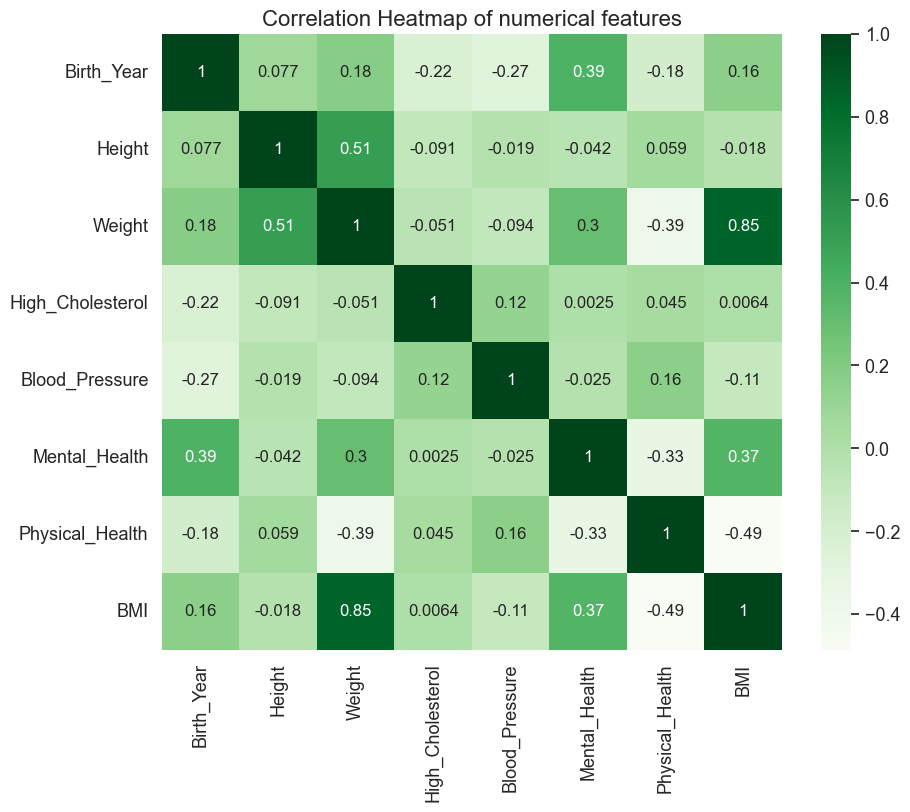

In [60]:
# sns.set(font_scale=1.18) 
# plt.figure(figsize=(10,8))
# sns.heatmap(featsel[metric_list].corr(),cmap = plt.cm.Greens, annot = True, annot_kws={"fontsize":12}).set_title('Correlation Heatmap of numerical features',
#                                                                                                                  fontdict={'fontsize':16})
# plt.show()

In [61]:
# corr_df = pd.DataFrame(index = X_featsel[metric_feat].columns)

# # seems like weight can be removed because it's very correlated with BMI
# corr_df['Corr'] = ['Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes','Yes','Yes']
# # corr_df

### 3) Mutual Information

In [62]:
# cat_feat = list(featsel.columns[8:-1])

In [63]:
# mi_num = mutual_info_classif(featsel[metric_feat], y_train)
# mi_cat = mutual_info_classif(featsel[cat_feat], y_train, discrete_features=True)
# mi_num_df = pd.Series(mi_num, index= featsel[metric_feat].columns)
# mi_cat_df = pd.Series(mi_cat, index= featsel[cat_feat].columns)
# mi_df = pd.concat([mi_cat_df,mi_num_df])

Text(0.5, 1.0, 'Mutual information between predictors and target')

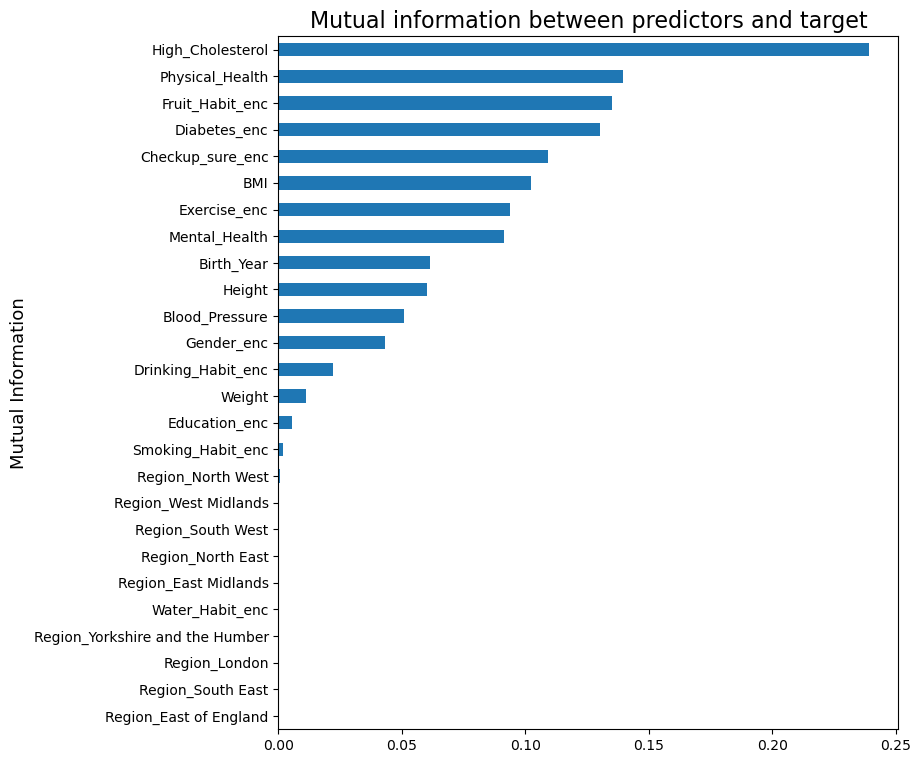

In [64]:
# plt.figure(figsize=(8,9))
# sns.reset_orig()

# mi_df.sort_values().plot.barh()
# plt.ylabel('Mutual Information', fontsize=13)
# plt.title("Mutual information between predictors and target", fontsize = 16)

In [65]:
# mi_df

Education_enc                      5.457180e-03
Smoking_Habit_enc                  2.003701e-03
Drinking_Habit_enc                 2.218540e-02
Exercise_enc                       9.378266e-02
Fruit_Habit_enc                    1.349280e-01
Water_Habit_enc                    1.254530e-04
Diabetes_enc                       1.303310e-01
Gender_enc                         4.323186e-02
Checkup_sure_enc                   1.092994e-01
Region_East Midlands               1.954654e-04
Region_East of England             3.474712e-07
Region_London                      6.786103e-06
Region_North East                  1.984191e-04
Region_North West                  5.019904e-04
Region_South East                  7.994744e-07
Region_South West                  2.479436e-04
Region_West Midlands               3.401876e-04
Region_Yorkshire and the Humber    5.334251e-05
Birth_Year                         6.138119e-02
Height                             6.002557e-02
Weight                             1.121

In [66]:
# importance_mi = pd.DataFrame(index = X_featsel.columns)
# importance_mi['Mutual Info'] = mi_df.apply(lambda x: 'Yes' if x > 0.05 else ('No'))

In [67]:
# importance_mi

### 4) Using decision trees

In [68]:
# # Select from model sees feature importance and applies a threshold to choose features with that model
# select_dt = SelectFromModel(DecisionTreeClassifier())
# select_dt.fit(X_featsel, y_featsel)

SelectFromModel(estimator=DecisionTreeClassifier())

In [69]:
# importance_dt = pd.DataFrame(index = X_featsel.columns)
# importance_dt['DT'] = importance_dt.reset_index()['index'].apply(lambda x: 'Yes' if x in\
#                                                 list(X_featsel.columns[(select_dt.get_support())]) else 'No').values
# # importance_dt

### 5) Chi-squared test for categorical variables

In [70]:
# X_featsel_cat = X_featsel[cat_feat]

In [72]:
# ## Let's do it for different levels of significance (the usual ones)

# # chi_df = pd.DataFrame(index = X_featsel_cat.columns)

# for alpha in [0.01,0.025, 0.05]:
#     for var in X_featsel_cat:
#         dfObserved = pd.crosstab(y_featsel,X_featsel_cat[var]) 
#         chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
#         dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
#         if p<alpha:
#             result="{0} is IMPORTANT for Prediction".format(var)
#             chi_df.loc[var,'Chi ' +  str(alpha)] = 'Yes'
#         else:
#             result="{0} is NOT an important predictor.".format(var)
#             chi_df.loc[var,'Chi ' +  str(alpha)] = 'No'
            
# # chi_df

### 6) Recursive Feature Elimination

As RFE uses model fitting and training/val data, we'll have to use cross validation on this method, as we want to in our final model fitting and predicting. So, we'll have to add RFE to the pipeline and apply all the preprocessing on the cross validation itself, very similar to what we'll do when testing models.

In [73]:
# X_rfe = X_train.copy()
# y_rfe = y_train.copy()

# full_columns = X_featsel.columns

In [74]:
# def rfe_feature_selection(model, cv):
#     # Number of features list, start highest score on 0
#     nof_list=list(range(1,len(full_columns)+1))
#     high_score=0

#     #Variable to store the optimum number of features
#     nof=0           
#     score_listRF =[]
#     for n in nof_list:
#         rfe = RFE(model,n_features_to_select = n)
#         pipeline_rfe = Pipeline(steps=[('preprocess',preprocessor),('select',rfe),('m',model)])
        
#         all_scores = cross_val_score(pipeline_rfe, X_rfe, y_rfe, scoring='f1', cv = cv)
#         score = (all_scores).mean()
#         score_listRF.append(score)
    
#         if(score>high_score):
#             high_score = score
#             nof = n 
                        
#     print("Optimum number of features: %d" %nof)
#     print("Score with %d features: %f" % (nof, high_score))
#     print(score_listRF)

In [75]:
# def chosen_list(nfeat_list,model):
#     chosen_list = []
    
#     for nfeat in nfeat_list:
#         pipe = Pipeline(steps=[('preprocess',preprocessor),
#                                     ('rfe_model',RFE(model,
#                                               n_features_to_select = nfeat))])

#         chosetf = pipe.fit_transform(X_rfe, y_rfe)

#         chosen_series = pd.Series(pipe['rfe_model'].support_, index = full_columns)

#         chosen_list.append(['Yes' if i == True else 'No' for i in chosen_series.values ])
        
#     return chosen_list

- With Random Forest

In [76]:
# # TIME TO RUN: 4 mins
# rfe_feature_selection(RandomForestClassifier(random_state = 15), 
#                       StratifiedKFold(n_splits=4))

Optimum number of features: 11
Score with 11 features: 0.952388
[0.6417718730600627, 0.7423629872825516, 0.8357420249653259, 0.851172182632678, 0.8988342407299451, 0.9374078665237202, 0.9395958401441988, 0.9476037826992454, 0.9490022700612528, 0.9338834951456311, 0.9523881478841704, 0.9415708779303859, 0.9280967638083942, 0.9312174842066147, 0.935100487781999, 0.9284761114585794, 0.9272447309114387, 0.9264992159955044, 0.9220548381954408, 0.9319475081435417, 0.9266430721044756, 0.9211565358550702, 0.9225318118953765, 0.9161375255614952, 0.9309107701051436, 0.9163609432158846]


In [77]:
# chosen_list_rf = chosen_list([8,9,11],RandomForestClassifier(random_state = 15))
    
# rferf_df = pd.DataFrame(index=X_featsel.columns, columns = ['rfe_rf8','rfe_rf9','*rfe_rf11*'])

# rferf_df['rfe_rf8'] = chosen_list_rf[0]
# rferf_df['rfe_rf9'] = chosen_list_rf[1]
# rferf_df['*rfe_rf11*'] = chosen_list_rf[2]

# # rferf_df

- Logistic Regression:

In [78]:
# rfe_feature_selection(LogisticRegression(n_jobs=-1), 
#                       StratifiedKFold(n_splits=4))

Optimum number of features: 14
Score with 14 features: 0.841922
[0.6910375143515225, 0.7460832156921291, 0.7845977294578241, 0.7940272737552012, 0.8069675498393811, 0.8136036496284943, 0.8255977529174479, 0.8237351208900051, 0.8230900676799473, 0.8268784363242044, 0.834383271437325, 0.8334425855994005, 0.833219470097992, 0.8419218608852754, 0.8330449070767807, 0.8336074211396323, 0.8286725615948318, 0.8320775703933636, 0.8357081938466443, 0.8350422882149853, 0.8320550586372691, 0.8320550586372691, 0.8307065935192244, 0.831269107582076, 0.8316579375573321, 0.8316579375573321]


In [79]:
# chosen_list_lr = chosen_list([14],LogisticRegression(n_jobs=-1))
    
# rfelr_df = pd.DataFrame(index=X_featsel.columns, columns = ['*rfe_lr14*'])

# rfelr_df['*rfe_lr14*'] = chosen_list_lr[0]

# # rfelr_df

- Gradient Boosting

In [80]:
# # TIME TO RUN: 3 mins
# rfe_feature_selection(GradientBoostingClassifier(random_state = 15), 
#                       StratifiedKFold(n_splits=4))

Optimum number of features: 6
Score with 6 features: 0.920639
[0.7314212982685309, 0.7909139803195533, 0.8401552999893533, 0.8844539538456647, 0.8942584692869625, 0.9206388296945572, 0.9112474254453043, 0.9042527745885955, 0.8995085098880338, 0.9095922260468511, 0.9172523376401814, 0.9093870210900841, 0.9189618860004293, 0.9152112565952313, 0.907870653502638, 0.9042872303647222, 0.910913246624885, 0.9087316731454063, 0.9113996053616384, 0.9088309709796425, 0.9075576075284953, 0.9088309709796425, 0.9077364436164583, 0.9099160980945331, 0.9099160980945331, 0.9099160980945331]


In [81]:
# chosen_list_gb = chosen_list([6,13],GradientBoostingClassifier(random_state = 15))
    
# rfegb_df = pd.DataFrame(index=X_featsel.columns, columns = ['*rfe_gb6*','rfe_gb13'])

# rfegb_df['*rfe_gb6*'] = chosen_list_gb[0]
# rfegb_df['rfe_gb13'] = chosen_list_gb[1]

# # rfegb_df

- Extremely Randomized Trees

In [221]:
# # TIME TO RUN: 6 mins
# rfe_feature_selection(ExtraTreesClassifier(random_state = 15, n_jobs=-1), 
#                       StratifiedKFold(n_splits=4))

Optimum number of features: 13
Score with 13 features: 0.967482
[0.7023319745179788, 0.8812470112390767, 0.9274279523351154, 0.9362603832064152, 0.9553157346995903, 0.9559529717819272, 0.9641931579650517, 0.9629041881038523, 0.9627674193683058, 0.9636925183647159, 0.9598285869534822, 0.9623870742016009, 0.967481758427305, 0.9562326843052198, 0.9601845711759505, 0.9501074911491538, 0.9491755988914363, 0.9428198204212141, 0.9399462683624175, 0.922234258836502, 0.9271388798254744, 0.9286703668028533, 0.9237535443949335, 0.9275105061892492, 0.9284407091876132, 0.9224375697380208]


In [81]:
# chosen_list_et = chosen_list([7,13],ExtraTreesClassifier(random_state = 15, n_jobs=-1))
    
# rfeet_df = pd.DataFrame(index=X_featsel.columns, columns = ['rfe_et7','*rfe_et13*'])

# rfeet_df['rfe_et7'] = chosen_list_et[0]
# rfeet_df['*rfe_et13*'] = chosen_list_et[1]

# # rfeet_df

- Join all the created dataframes into one:

In [82]:
# rfe_df = (rferf_df).join(rfelr_df).join(rfegb_df).join(rfeet_df)

In [83]:
# rfe_df

### 7) Lasso

In [169]:
# lasso = LassoCV()
# lasso.fit(X_featsel,y_featsel)
# coef = pd.Series(abs(lasso.coef_),index = X_featsel.columns)

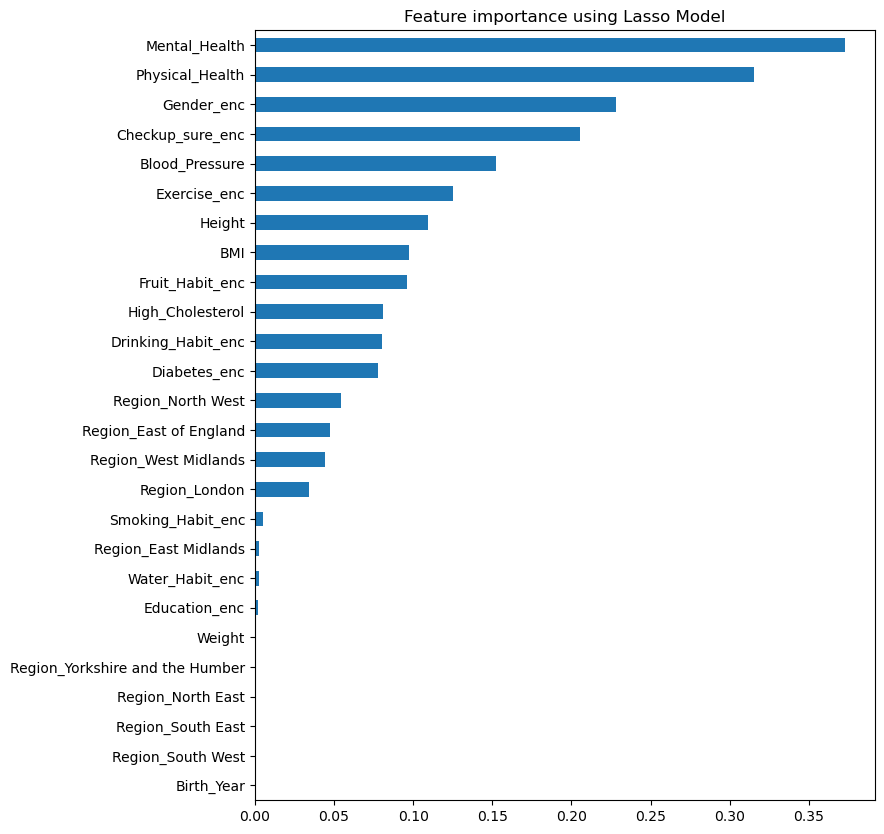

In [170]:
# imp_coef = coef.sort_values()
# plt.figure(figsize=(8,10))
# imp_coef.plot(kind = "barh")
# plt.title("Feature importance using Lasso Model")
# plt.show()

In [86]:
# df_lasso = pd.DataFrame(coef).rename(columns = {0:'Lasso'})['Lasso'].apply(lambda x: 'Yes' if x > 0.05 else 'No')

### 8) Comparing all Feature selection

In [98]:
# all_fs = ((importance_dt.join(chi_df)).join(corr_df)).join(rfe_df).join(df_lasso).join(importance_mi).fillna('-')

In [102]:
# all_fs_final = all_fs.reindex(\
#                 columns = ['Corr','Mutual Info','DT','rfe_rf8','rfe_rf9','*rfe_rf11*','*rfe_gb6*','rfe_gb13','rfe_et7','*rfe_et13*',
#                           '*rfe_lr14*', 'Lasso','Chi 0.01', 'Chi 0.05', 'Chi 0.025'])

# all_fs_final.rename(columns={'Corr':'Correlation','DT': 'Decision Tree','rfe_rf8': 'RFE_RFC_8','rfe_rf9':'RFE_RFC_9',
#                             '*rfe_rf11*':'*RFE_RFC_11*', '*rfe_gb6*':'*RFE_GBC_6*','rfe_gb13': 'RFE_GBC_13',
#                             'rfe_et7': 'RFE_ETC_7','*rfe_et13*':'*RFE_ETC_13*', '*rfe_lr14*':'*RFE_LR_14*'}, inplace=True)

In [105]:
# all_fs_final.style.applymap(colors)

In [104]:
# #to save the dataframe as an image
# # pip install dataframe-image 

# import dataframe_image as dfi
 
# dfi.export(all_fs_final.style.applymap(colors), 'featselection.png')

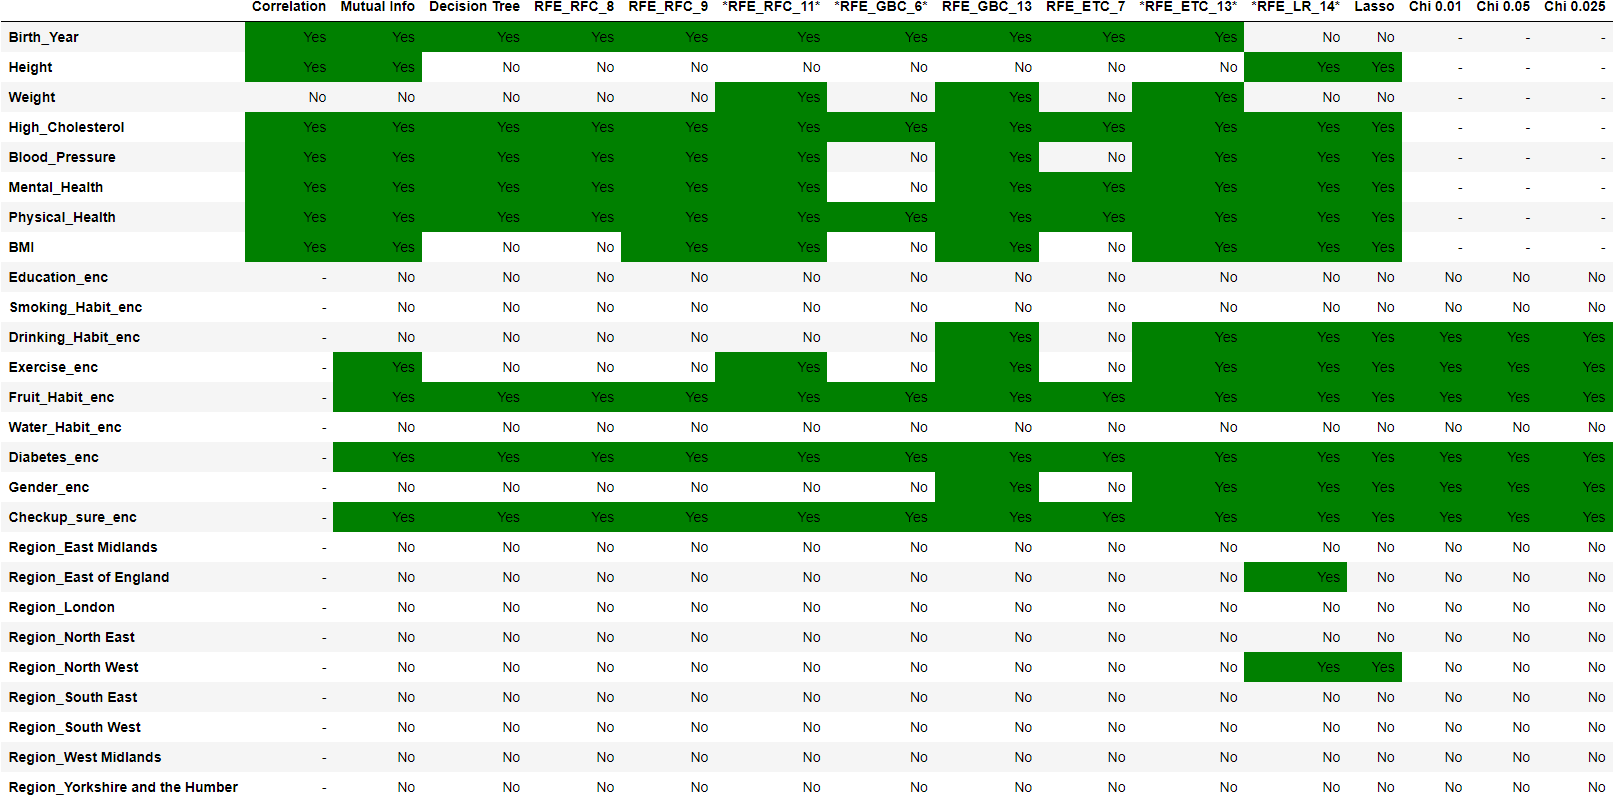

With this we could conclude for each algorithm the features to keep, but we also can see that there are features which must have a high discriminative power, because they are chosen for the vast majority/all of the algorithms. They are:  __`High_Cholesterol`__,  __`Physical_Health`__, __`Fruit_Habit_enc`__, __`Diabetes_enc`__, __`Checkup_sure_enc`__.

Other features we may want to keep or not, depending on the algorithm, because with some they are chosen, with others they aren´t. These are: __`Birth_Year`__, __`Blood_Pressure`__, __`Weight`__, __`Gender`__, __`BMI`__, __`Exercise_enc`__, __`Height`__, __`Drinking_Habit_enc`__,__`Mental_Health`__.

The others seem like they are unimportant overall. These are: __`Water_Habit_enc`__, __`Education_enc`__, __`Region`__, __`Smoking_Habit_enc`__.

# 4. Modelling

In [24]:
sure_feat = ['High_Cholesterol', 'Physical_Health',
             'Fruit_Habit', 'Diabetes', 'Checkup_sure']

unsure_feat = ['Birth_Year','Blood_Pressure','Mental_Health', 'Weight', 'Gender', 
               'BMI', 'Exercise', 'Height' , 'Drinking_Habit']

unsure_num = ['Birth_Year','Blood_Pressure','Mental_Health','Weight','BMI','Height']
unsure_cat = ['Gender','Exercise','Drinking_Habit']

- Redoing the preprocessor with only the features that will remain, which for now are the sure features, later we'll see if adding others helps the model. 

In [25]:
ordinal_sure = ['Fruit_Habit', 'Diabetes','Checkup_sure']
ordinal_unsure = [ 'Gender','Exercise','Drinking_Habit']

sure_num = ['High_Cholesterol', 'Physical_Health']

sure_categories = [fruit_categories, diabetes_categories, checkup_categories]
unsure_categories = [gender_categories, exercise_categories, drink_categories]

In [26]:
preprocessor = create_preprocessor(MinMaxScaler(), sure_num, ordinal_sure, sure_categories)

In [27]:
X_train_sel = X_train.loc[:,sure_feat]

We'll use a number of splits in repeated stratified K-Fold which will represent better que set we want to predict in, which is the test set with 225 rows. 800/n = 225 -> n = 4 folds.

In [28]:
rskf4 = RepeatedStratifiedKFold(n_splits=4,random_state=0,n_repeats = 20)

Function to test combinations of unsure features:

In [63]:
# def combinations_test(X_train, sure_feat, ordinal_sure, sure_categories, sure_num,
#                       unsure_feat, unsure_categories, unsure_cat, unsure_num, model, cv):
#     """This function takes features which were already used in a default model because of their discriminative
#     power seen on feature selection and combines them all with all possible combinations of other features we are
#     not so sure are useful, but could be, depending on the model."""
    
#     combinations_list = []
#     feats = unsure_feat
#     for L in range(len(feats) + 1):
#         for subset in itertools.combinations(feats, L):
#             combinations_list.append(subset)

#     combinations_list.pop(0)

#     comb_df = pd.DataFrame(columns=['Combination','Score'])
    
#     it=0
#     for combination in combinations_list:
    
#         # Get the ordinal encoding categories from the categorical features that are in this combination
#         unsure_categories_comb = [unsure_categories[i] for i,feat in enumerate(unsure_cat) if feat in combination]     
#         unsure_num_comb = [feat for feat in combination if feat in unsure_num]      
#         unsure_cat_comb = [feat for feat in combination if feat in unsure_cat]  
        
#         ordinal = ordinal_sure + unsure_cat_comb
#         categories = sure_categories + unsure_categories_comb
        
#         feat_comb = sure_feat+ list(combination)
        
#         metric_comb = sure_num + unsure_num_comb
        
#         # Preprocessor
#         preprocessor_comb = create_preprocessor(MinMaxScaler(), metric_comb, ordinal, categories)
    
#         # Model score testing
#         pipeline = Pipeline(steps=[('preprocess',preprocessor_comb),
#                                             ('model',model)])
    
#         all_scores = cross_val_score(pipeline, X_train.loc[:,feat_comb], y_train,
#                              scoring='f1', cv = cv)    
    
#         comb_df.loc[it,'Combination'] = combination
#         comb_df.loc[it,'Score'] = all_scores.mean()
    
#         print(combination, all_scores.mean())
    
#         it+=1
    
#     preprocessor_sure = create_preprocessor(MinMaxScaler(), sure_num, ordinal_sure, sure_categories)
#     pipeline_sure = Pipeline(steps=[('preprocess',preprocessor_sure),
#                                             ('model',model)])
    
#     comb_df.loc[it,'Combination'] = '()' 
#     comb_df.loc[it,'Score'] = (cross_val_score(pipeline_sure, X_train.loc[:,sure_feat], y_train,
#                              scoring='f1', cv = cv)).mean()
    
#     return comb_df

In [167]:
# combcv = RepeatedStratifiedKFold(n_splits = 4, random_state = 0, n_repeats = 5)

## 4.1. Random Forest Classifier

In [153]:
# rfc_standard = RandomForestClassifier(random_state=15)

# pipeline_rfc_standard = Pipeline(steps=[('preprocess',preprocessor),
#                                         ('rfc_standard',rfc_standard)])

# all_scores = cross_val_score(pipeline_rfc_standard, X_train_sel, y_train,
#                              scoring='f1', cv = rskf4) 

In [154]:
# all_scores.mean()

0.9704725486972684

### 1) Trying to combine the sure features with all possible combinations of unsure to see improvement on score:

In [170]:
# ## WARNING: DO NOT RUN IF NOT NEEDED
# # TIME TO RUN: 25 minutes
# comb_df_rfc = combinations_test(X_train, sure_feat, ordinal_sure, sure_categories, sure_num,
#                       unsure_feat, unsure_categories, unsure_cat, unsure_num, rfc_standard, combcv)

('Birth_Year',) 0.975905930944663
('Blood_Pressure',) 0.9711907545603852
('Mental_Health',) 0.9727274852282799
('Weight',) 0.9410786632455576
('Gender',) 0.9729760551082697
('BMI',) 0.9429313838658844
('Exercise',) 0.9739555694405982
('Height',) 0.9342110619258402
('Drinking_Habit',) 0.9744169354492224
('Birth_Year', 'Blood_Pressure') 0.9746203903851234
('Birth_Year', 'Mental_Health') 0.9777673811293349
('Birth_Year', 'Weight') 0.9600604813844476
('Birth_Year', 'Gender') 0.9765911455955261
('Birth_Year', 'BMI') 0.9645561714114835
('Birth_Year', 'Exercise') 0.9764624288653216
('Birth_Year', 'Height') 0.9589786151671108
('Birth_Year', 'Drinking_Habit') 0.9794455683436561
('Blood_Pressure', 'Mental_Health') 0.9735551331282274
('Blood_Pressure', 'Weight') 0.9556405869152773
('Blood_Pressure', 'Gender') 0.9733613901016323
('Blood_Pressure', 'BMI') 0.9611709166319514
('Blood_Pressure', 'Exercise') 0.9751856272266025
('Blood_Pressure', 'Height') 0.9529478707587774
('Blood_Pressure', 'Drinking

In [172]:
# comb_df_rfc.sort_values('Score',ascending=False).head(5)

Combination     Score
66                (Birth_Year, Gender, Drinking_Habit)  0.980359
71              (Birth_Year, Exercise, Drinking_Habit)  0.980099
234  (Mental_Health, Gender, Exercise, Drinking_Habit)  0.979879
16                        (Birth_Year, Drinking_Habit)  0.979446
179     (Birth_Year, Gender, Exercise, Drinking_Habit)  0.979391

In [78]:
# feat_rfc = ['High_Cholesterol','Physical_Health', 'Fruit_Habit', 'Diabetes','Checkup_sure',
#             'Birth_Year', 'Gender','Drinking_Habit']

# X_train_rfc = X_train.loc[:,feat_rfc]

# ### Create the preprocessor
# ordinal_rfc = ['Fruit_Habit', 'Diabetes','Checkup_sure', 'Gender','Drinking_Habit']
# categories_rfc = [fruit_categories, diabetes_categories, checkup_categories, gender_categories, drink_categories]
# metric_rfc = ['High_Cholesterol','Physical_Health','Birth_Year']

# preprocessor_rfc = create_preprocessor(MinMaxScaler(),metric_rfc, ordinal_rfc, categories_rfc)

# rfc = RandomForestClassifier(random_state=15)

# pipeline_rfc = Pipeline(steps=[('preprocess',preprocessor_rfc),
#                                         ('rfc_standard',rfc)])

# all_scores_rfc = cross_val_score(pipeline_rfc, X_train_rfc, y_train,
#                              scoring='f1', cv = rskf4)    

In [79]:
# all_scores_rfc.mean() #previous 0.9704725486972684

0.9767963184922424

The added features seem to add 0.6% on our f1 score.

### 2) Hyperparameter Tuning

First, we'll test parameters individually and then with the knowledge we get from that we'll use Random Searches to finalize with a smaller Grid Search.

In [210]:
# def return_f1score(model, X, y):
#     n_scores = cross_val_score(model, X, y, scoring = 'f1',
#                                cv = RepeatedStratifiedKFold(n_splits=4,random_state=0,n_repeats = 5))
#     return n_scores

In [208]:
# def return_results(models,X_train):
#     results, names = [],[]
#     for name, model in models.items():
#         scores = return_f1score(model, X_train, y_train)
#         results.append(scores)
#         names.append(name)
#         print('>%s %.5f (%.5f)' % (name, scores.mean(), scores.std()))
    
#     plt.figure(figsize=(15,7))
#     plt.boxplot(results, labels = names, showmeans = True)
#     plt.xticks(fontsize=14)
#     plt.show()

- Number of trees:

>10 0.97247 (0.01194)
>20 0.97696 (0.01521)
>50 0.98011 (0.01543)
>75 0.98041 (0.01409)
>100 0.98036 (0.01424)
>110 0.98016 (0.01416)
>115 0.98068 (0.01331)
>120 0.98112 (0.01354)
>125 0.98093 (0.01344)
>130 0.98093 (0.01344)
>135 0.98093 (0.01344)
>200 0.98096 (0.01310)
>250 0.98166 (0.01295)
>300 0.98166 (0.01295)
>350 0.98166 (0.01295)


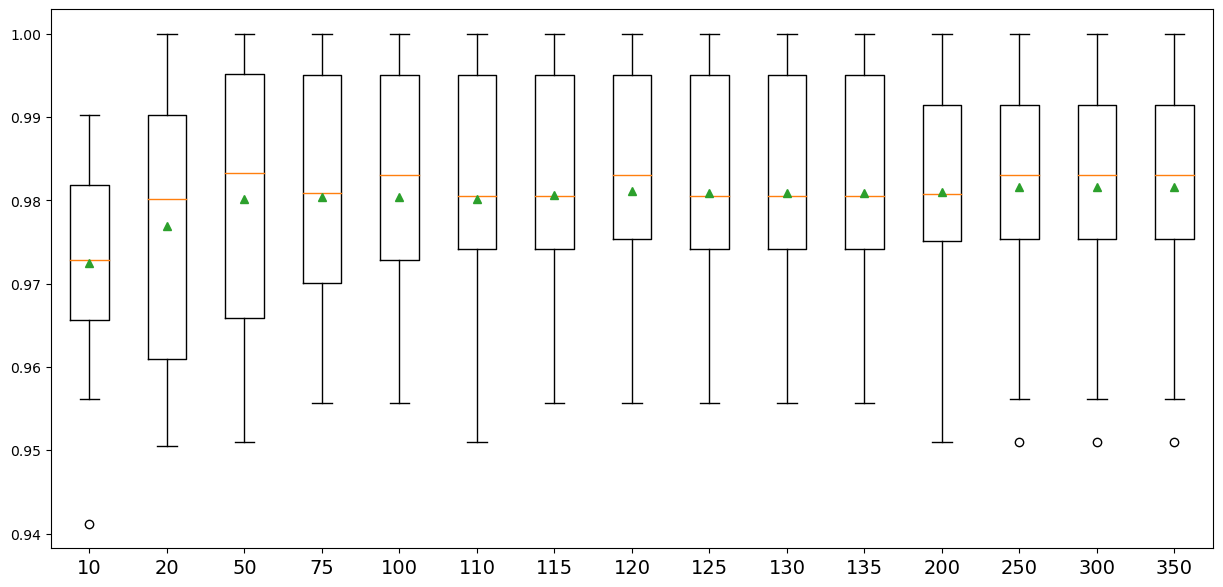

In [178]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         rfc_i = RandomForestClassifier(n_estimators = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_rfc),
#                                         ('rfc_standard',rfc_i)])     
#     return models

# models = get_models([10,20,50,75,100,110,115,120,125,130,135,200,250,300,350])
# return_results(models,X_train_rfc)

- Bootstrapping:

>False 0.97855 (0.01428)
>True 0.98036 (0.01424)


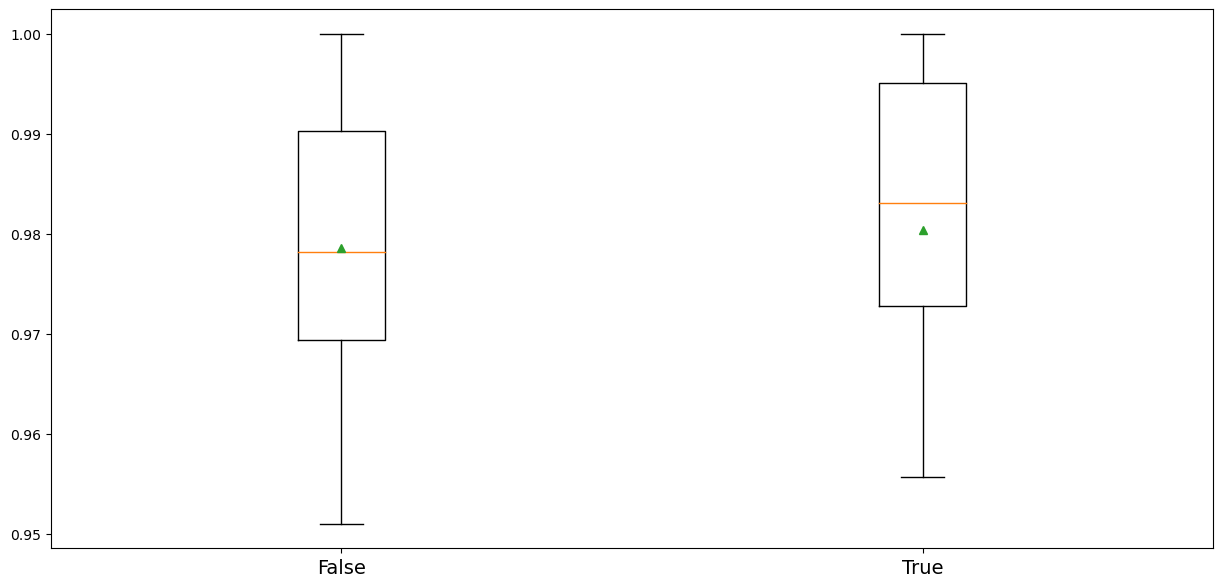

In [179]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         rfc_i = RandomForestClassifier(bootstrap = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_rfc),
#                                         ('rfc_standard',rfc_i)])     
#     return models

# models = get_models([False,True]) #standard is true
# return_results(models,X_train_rfc)

- Max depth of each tree:

>1 0.83519 (0.02668)
>2 0.84230 (0.02400)
>4 0.87771 (0.02364)
>6 0.93845 (0.02076)
>8 0.97229 (0.01285)
>10 0.97879 (0.01487)
>20 0.98036 (0.01424)
>30 0.98036 (0.01424)
>40 0.98036 (0.01424)
>50 0.98036 (0.01424)
>None 0.98036 (0.01424)


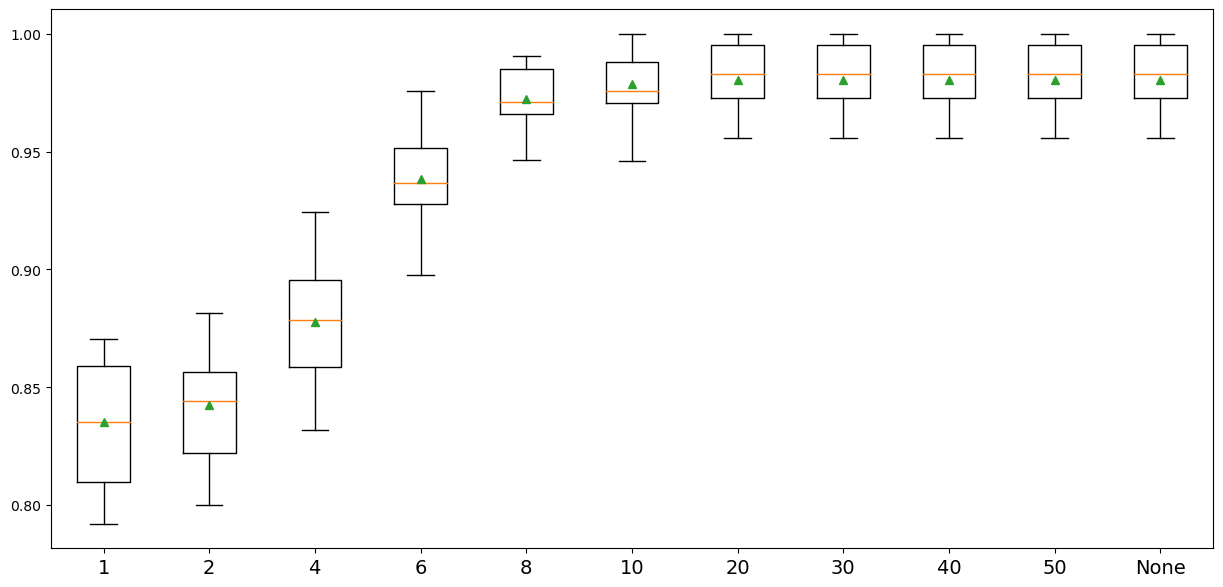

In [181]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         rfc_i = RandomForestClassifier(max_depth = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_rfc),
#                                         ('rfc_standard',rfc_i)])     
#     return models

# models = get_models([1,2,4,6,8,10,20,30,40,50,None])
# return_results(models,X_train_rfc)

 Limiting may help with times, but performance for 20 is the same as for No limit.

- Max Samples (when bootstrapping):

>0.2 0.91788 (0.02005)
>0.4 0.96026 (0.01429)
>0.6 0.97187 (0.01433)
>0.8 0.97848 (0.01320)
>None 0.98036 (0.01424)


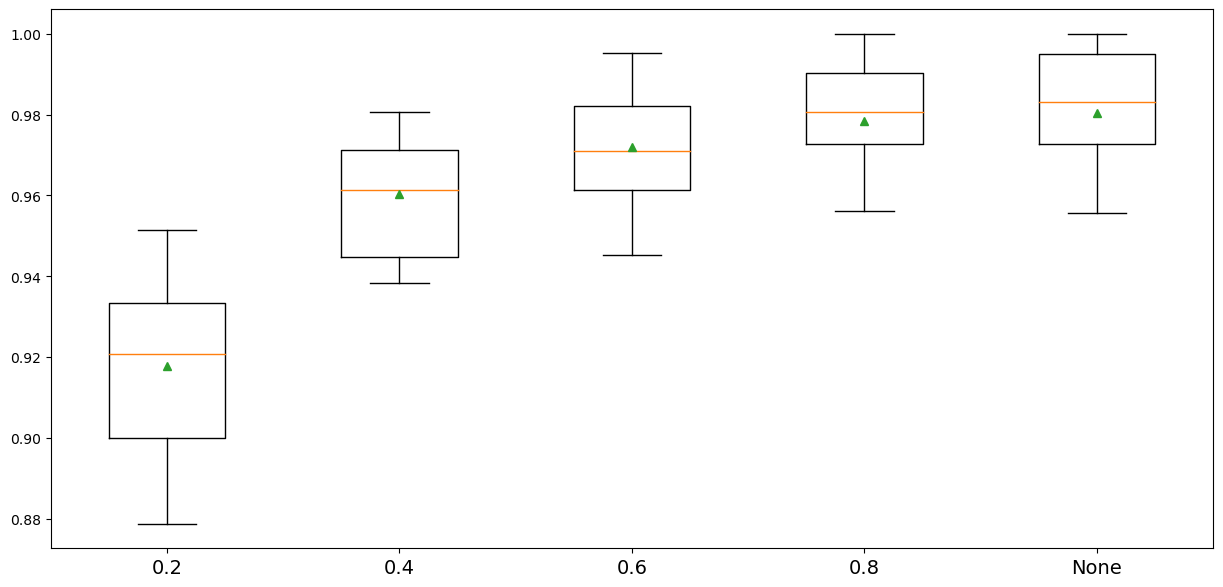

In [182]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         rfc_i = RandomForestClassifier(max_samples = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_rfc),
#                                         ('rfc_standard',rfc_i)])     
#     return models

# models = get_models([0.2,0.4,0.6,0.8,None])
# return_results(models,X_train_rfc)

- Warm start: use previous estimator on the new one.

>False 0.98036 (0.01424)
>True 0.98036 (0.01424)


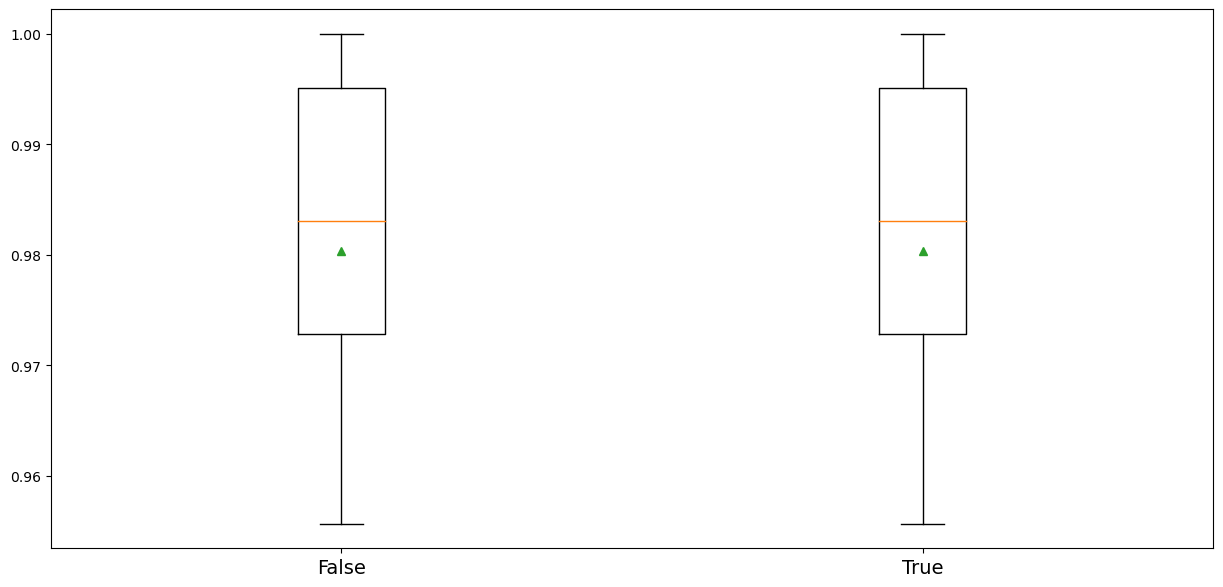

In [183]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         rfc_i = RandomForestClassifier(warm_start = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_rfc),
#                                         ('rfc_standard',rfc_i)])     
#     return models

# models = get_models([False, True])
# return_results(models,X_train_rfc)

- Out of bag score:

>False 0.98036 (0.01424)
>True 0.98036 (0.01424)


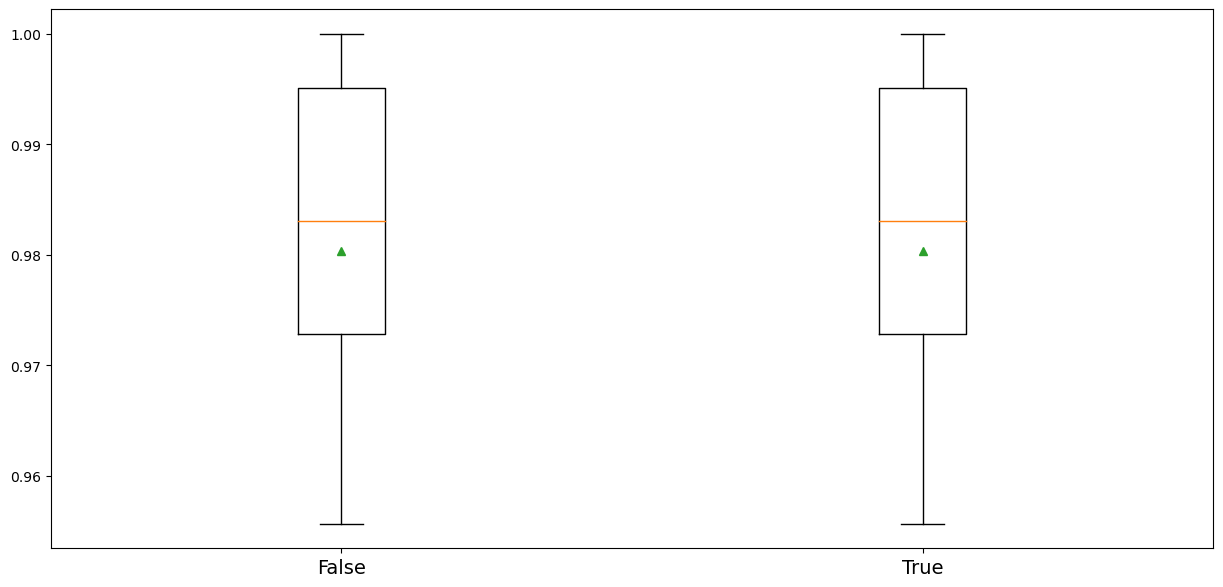

In [185]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         rfc_i = RandomForestClassifier(oob_score = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_rfc),
#                                         ('rfc_standard',rfc_i)])     
#     return models

# models = get_models([False, True])
# return_results(models,X_train_rfc)

- Criterion:

>gini 0.98036 (0.01424)
>entropy 0.97938 (0.01440)


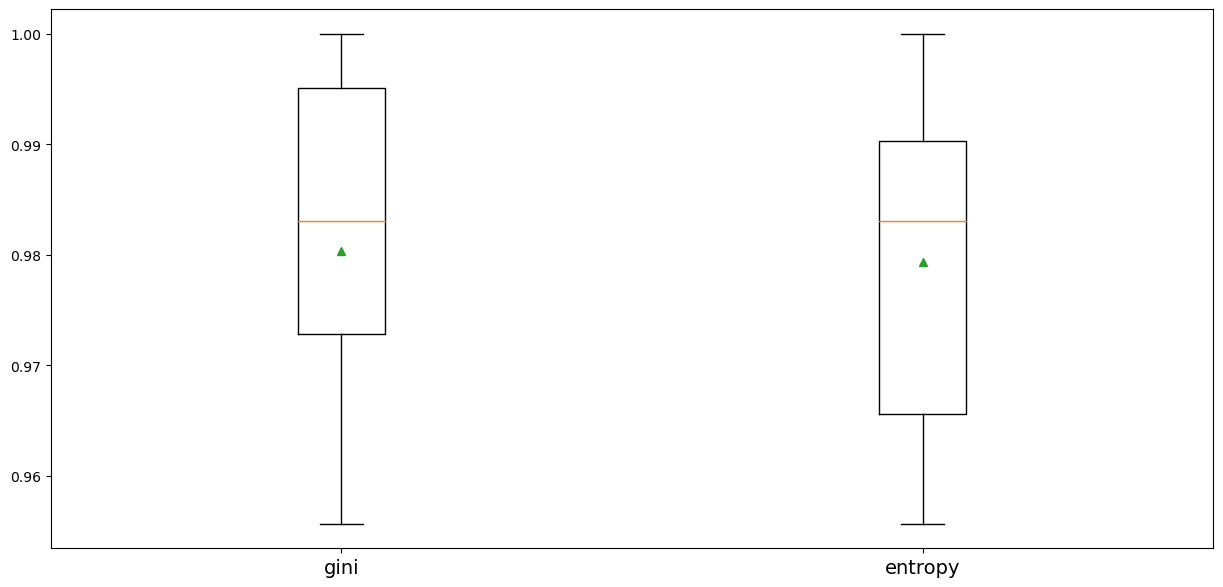

In [186]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         rfc_i = RandomForestClassifier(criterion = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_rfc),
#                                         ('rfc_standard',rfc_i)])     
#     return models

# models = get_models(['gini', 'entropy']) #log loss added in sklearn 1.1.2 it is really new
# return_results(models,X_train_rfc)

- Maximum Features:

>sqrt 0.98036 (0.01424)
>log2 0.97947 (0.01156)
>None 0.97680 (0.01272)


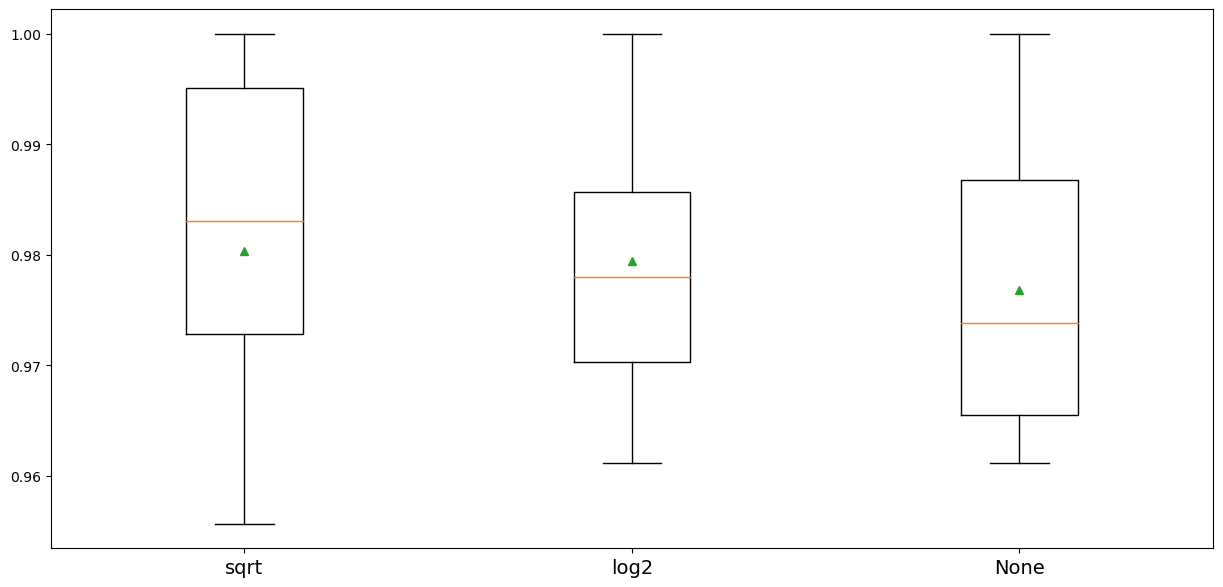

In [187]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         rfc_i = RandomForestClassifier(max_features = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_rfc),
#                                         ('rfc_standard',rfc_i)])     
#     return models

# models = get_models(['sqrt', 'log2', None]) #sqrt is the standard
# return_results(models,X_train_rfc)

- Class weight:

>balanced 0.98116 (0.01060)
>balanced_subsample 0.98088 (0.01246)
>None 0.98036 (0.01424)


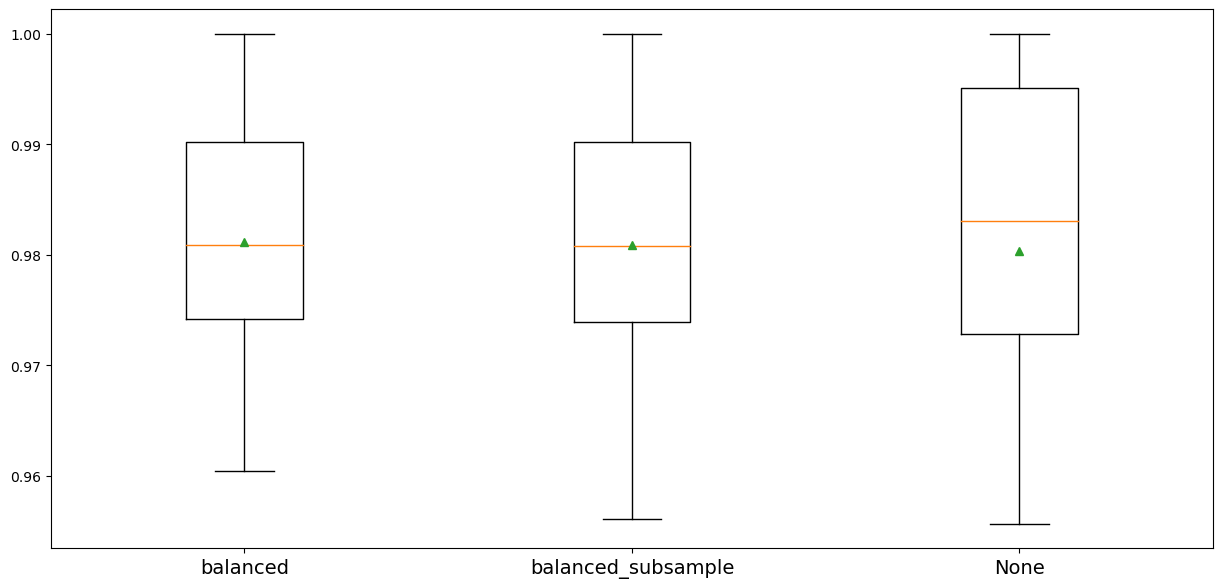

In [188]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         rfc_i = RandomForestClassifier(class_weight = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_rfc),
#                                         ('rfc_standard',rfc_i)])     
#     return models

# models = get_models(['balanced', 'balanced_subsample', None]) #None is the standard
# return_results(models,X_train_rfc)

- Minimum samples split:

>2 0.98036 (0.01424)
>3 0.97897 (0.01192)
>4 0.97602 (0.01434)
>5 0.96993 (0.01384)
>6 0.96387 (0.01580)
>7 0.95627 (0.01629)


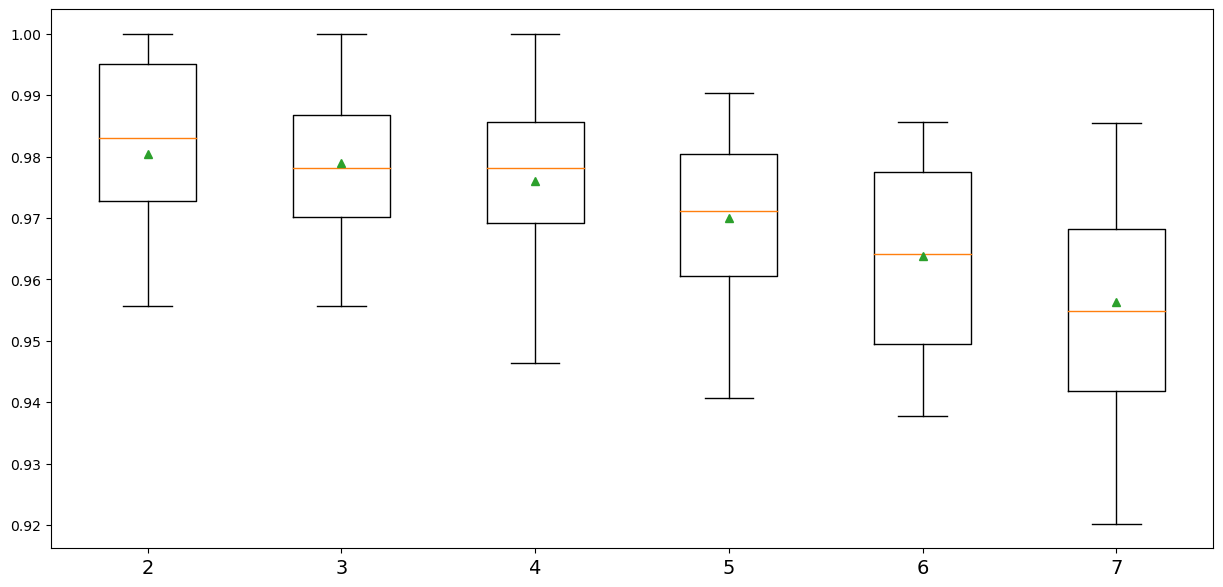

In [189]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         rfc_i = RandomForestClassifier(min_samples_split = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_rfc),
#                                         ('rfc_standard',rfc_i)])     
#     return models

# models = get_models([2,3,4,5,6,7]) #2 is the standard and the minimum
# return_results(models,X_train_rfc)

- __RANDOM SEARCH__

We'll use random search because it is way more efficient than grid search. We could actually maybe do a number of random searches (which really take much, much less time than a grid search) and then with the parameters it chooses for those different random searches (normally a random search has a probability of 95% of getting the optimal parameters) do a final grid search.

In [191]:
# ## Takes around 5 mins

# param_grid = { 
#     'rfc_grid__n_estimators': [100,110,115,120,125,130,135,200,250],
#     'rfc_grid__bootstrap' :[False,True],
#     'rfc_grid__criterion' :['gini','entropy'],
#     'rfc_grid__class_weight':['balanced', 'balanced_subsample', None],
#     'rfc_grid__max_features': ['sqrt', 'log2', None]
# } # the "model name__" has to be used so the gridsearch "knows" where to put the parameters

# rfc_grid_pipe = Pipeline(steps=[('preprocess',preprocessor_rfc),
#                                         ('rfc_grid',rfc)])

# ## Let's do 5 Random searches to be more sure of the parameters we get
# param_list = []
# for search in range(5):
#     CV_rfc = RandomizedSearchCV(estimator=rfc_grid_pipe, param_distributions=param_grid, scoring = 'f1',
#                           cv= combcv)

#     CV_rfc.fit(X_train_rfc, y_train)
    
#     param_list.append(CV_rfc.best_params_)

In [194]:
# param_list

[{'rfc_grid__n_estimators': 125,
  'rfc_grid__max_features': 'sqrt',
  'rfc_grid__criterion': 'gini',
  'rfc_grid__class_weight': None,
  'rfc_grid__bootstrap': True},
 {'rfc_grid__n_estimators': 250,
  'rfc_grid__max_features': 'log2',
  'rfc_grid__criterion': 'entropy',
  'rfc_grid__class_weight': 'balanced_subsample',
  'rfc_grid__bootstrap': True},
 {'rfc_grid__n_estimators': 125,
  'rfc_grid__max_features': 'sqrt',
  'rfc_grid__criterion': 'entropy',
  'rfc_grid__class_weight': 'balanced',
  'rfc_grid__bootstrap': True},
 {'rfc_grid__n_estimators': 120,
  'rfc_grid__max_features': 'sqrt',
  'rfc_grid__criterion': 'entropy',
  'rfc_grid__class_weight': 'balanced',
  'rfc_grid__bootstrap': True},
 {'rfc_grid__n_estimators': 110,
  'rfc_grid__max_features': 'sqrt',
  'rfc_grid__criterion': 'entropy',
  'rfc_grid__class_weight': None,
  'rfc_grid__bootstrap': True}]

- __Final Grid Search__:

In [209]:
# ## TIME TO RUN: 2 minutes 
# param_grid = { 
#     'rfc_grid__n_estimators': [110,120,125,250],
#     'rfc_grid__criterion' :['entropy'],
#     'rfc_grid__class_weight':['balanced', 'balanced_subsample', None]
# } 

# grid_rfc = GridSearchCV(estimator=rfc_grid_pipe, param_grid=param_grid, scoring = 'f1',
#                           cv= RepeatedStratifiedKFold(n_splits=4,random_state=0,n_repeats = 5))

# grid_rfc.fit(X_train_rfc, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=4, random_state=0),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['High_Cholesterol',
                                                                          'Physical_Health',
                                                                          'Birth_Year']),
                                                                        ('cat',
                                                                         OrdinalEncoder(categories=[['Less '
                                                                                                     'than '
                                                                                                     '1. '
             

In [210]:
# grid_rfc.best_params_

{'rfc_grid__class_weight': 'balanced',
 'rfc_grid__criterion': 'entropy',
 'rfc_grid__n_estimators': 120}

### Final Random Forest Model

In [80]:
# rfc_grid = RandomForestClassifier(random_state=15, class_weight = 'balanced',n_estimators = 120,criterion= 'entropy')

# pipeline_rfc_grid = Pipeline(steps=[('preprocess',preprocessor_rfc),
#                                         ('rfc_grid',rfc_grid)])
    
# rskf4 = RepeatedStratifiedKFold(n_splits=4,random_state=0,n_repeats = 20)

# all_scores_rfc_grid = cross_val_score(pipeline_rfc_grid, X_train_rfc, y_train,
#                              scoring='f1', cv = rskf4)   

In [81]:
# all_scores_rfc_grid.mean() # previous 0.9767963184922424

0.9777430937032751

- For testing:

In [82]:
# pipeline_rfc_grid_fit  = pipeline_rfc_grid.fit(X_train_rfc,y_train)

In [83]:
# X_test = feat_eng(test)

# X_test_rfc = X_test.loc[:,feat_rfc]

In [84]:
# pred_rfc_grid_1 = pipeline_rfc_grid.predict(X_test_rfc)

# submission_rfc_grid_1 = pd.DataFrame(pred_rfc_grid_1, index = X_test_rfc.index).rename(columns= {0:'Disease'})

# # submission_rfc_standard

# submission_rfc_grid_1.to_csv('Group12_Version01.csv') #1 

## 4.2. Extremely Randomized Trees Classifier

In [85]:
# et_standard = ExtraTreesClassifier(random_state=15)

# pipeline_et_standard = Pipeline(steps=[('preprocess',preprocessor),
#                                         ('et_standard',et_standard)])

# all_scores_et = cross_val_score(pipeline_et_standard, X_train_sel, y_train,
#                              scoring='f1', cv = rskf4)   

In [86]:
# all_scores_et.mean()

0.9716858110945011

### 1) Searching for the best combination of features possible 

In [308]:
# # TIME TO RUN: 21 minutes
# comb_df_et = combinations_test(X_train, sure_feat, ordinal_sure, sure_categories, sure_num,
#                       unsure_feat, unsure_categories, unsure_cat, unsure_num, et_standard, combcv)

('Birth_Year',) 0.9780086616156582
('Blood_Pressure',) 0.9705449701851068
('Mental_Health',) 0.9746388089394099
('Weight',) 0.9554325747990029
('Gender',) 0.9715574466997117
('BMI',) 0.958679047274986
('Exercise',) 0.9739392627944822
('Height',) 0.9384792978204148
('Drinking_Habit',) 0.9762449825654166
('Birth_Year', 'Blood_Pressure') 0.975185847643566
('Birth_Year', 'Mental_Health') 0.9797142443760596
('Birth_Year', 'Weight') 0.9745212155391595
('Birth_Year', 'Gender') 0.9751736916647624
('Birth_Year', 'BMI') 0.9706352104741344
('Birth_Year', 'Exercise') 0.9786273403145023
('Birth_Year', 'Height') 0.9629113455908194
('Birth_Year', 'Drinking_Habit') 0.9782198648278853
('Blood_Pressure', 'Mental_Health') 0.9734726038099991
('Blood_Pressure', 'Weight') 0.9698927479872991
('Blood_Pressure', 'Gender') 0.9717775310390342
('Blood_Pressure', 'BMI') 0.9728095801138039
('Blood_Pressure', 'Exercise') 0.9752536450380516
('Blood_Pressure', 'Height') 0.9563213735162399
('Blood_Pressure', 'Drinking_

In [311]:
# comb_df_et.sort_values('Score',ascending=False).head(5)

Combination     Score
196  (Blood_Pressure, Mental_Health, BMI, Drinking_...   0.98268
259  (Birth_Year, Blood_Pressure, Mental_Health, We...  0.981215
266  (Birth_Year, Blood_Pressure, Mental_Health, BM...  0.981184
293  (Birth_Year, Mental_Health, Weight, Gender, Dr...  0.980992
154  (Birth_Year, Mental_Health, Weight, Drinking_H...   0.98073

In [314]:
# comb_df_et.iloc[196].values

array([('Blood_Pressure', 'Mental_Health', 'BMI', 'Drinking_Habit'),
       0.9826798116113407], dtype=object)

In [30]:
feat_et = ['Birth_Year', 'High_Cholesterol', 'Physical_Health', 'Fruit_Habit', 'Diabetes', 'Checkup_sure',
            'Blood_Pressure','Mental_Health', 'BMI','Drinking_Habit']

X_train_et = X_train.loc[:,feat_et]

ordinal_et = ['Fruit_Habit', 'Diabetes','Checkup_sure','Drinking_Habit']
categories_et = [fruit_categories, diabetes_categories, checkup_categories, drink_categories]
metric_et = ['Birth_Year', 'High_Cholesterol', 'Physical_Health','Blood_Pressure','Mental_Health', 'BMI',]

preprocessor_et = create_preprocessor(MinMaxScaler(),metric_et, ordinal_et, categories_et)

In [89]:
# et = ExtraTreesClassifier(random_state=15)

# pipeline_et = Pipeline(steps=[('preprocess',preprocessor_et),
#                                         ('et_standard',et)])
    
# rskf4 = RepeatedStratifiedKFold(n_splits=4,random_state=0,n_repeats = 20)

# all_scores_et = cross_val_score(pipeline_et, X_train_et, y_train,
#                              scoring='f1', cv = rskf4)    

In [90]:
# all_scores_et.mean() #previous 0.9716858110945011

0.9803053014738412

### 2) Tuning the Extremely Randomized Trees Classifier

- Number of trees

>10 0.97543 (0.01184)
>20 0.97837 (0.01165)
>50 0.98114 (0.01061)
>75 0.98094 (0.01117)
>100 0.98191 (0.01062)
>110 0.98141 (0.01059)
>115 0.98095 (0.01037)
>120 0.98142 (0.01046)
>125 0.98167 (0.01014)
>130 0.98265 (0.01033)
>135 0.98216 (0.01099)
>200 0.98219 (0.01007)
>250 0.98267 (0.01066)
>300 0.98193 (0.01167)
>350 0.98120 (0.01106)
>400 0.98144 (0.01131)
>450 0.98169 (0.01145)
>500 0.98219 (0.01169)


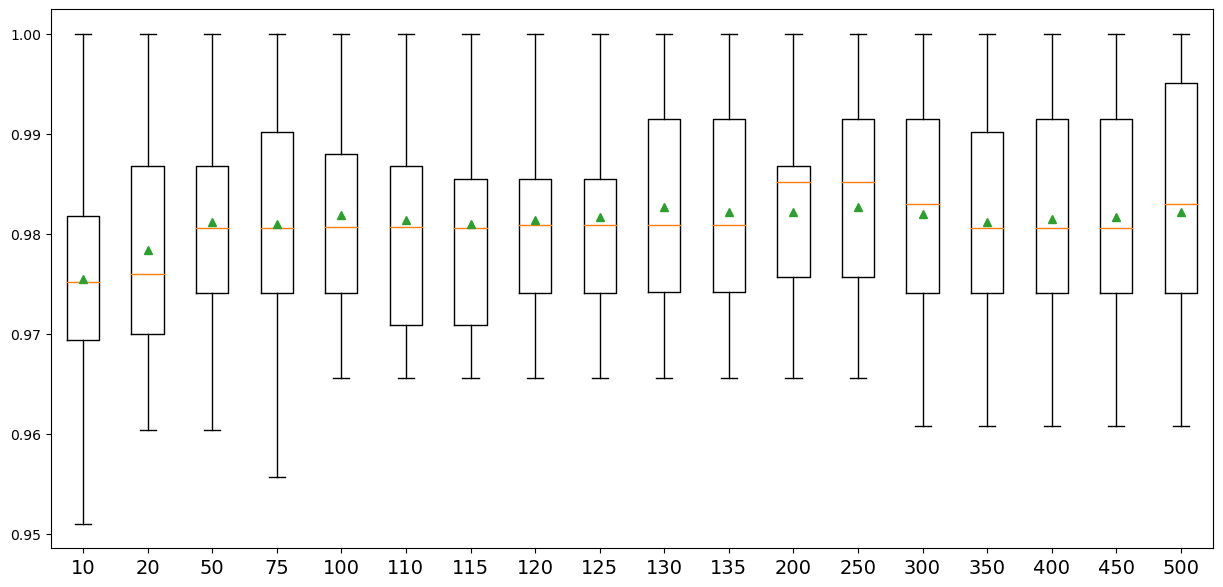

In [318]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         et_i = ExtraTreesClassifier(n_estimators = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_et),
#                                         ('et_standard',et_i)])     
#     return models

# models = get_models([10,20,50,75,100,110,115,120,125,130,135,200,250,300,350,400,450,500])
# return_results(models,X_train_et)

- Criterion

>gini 0.98191 (0.01062)
>entropy 0.98020 (0.01097)


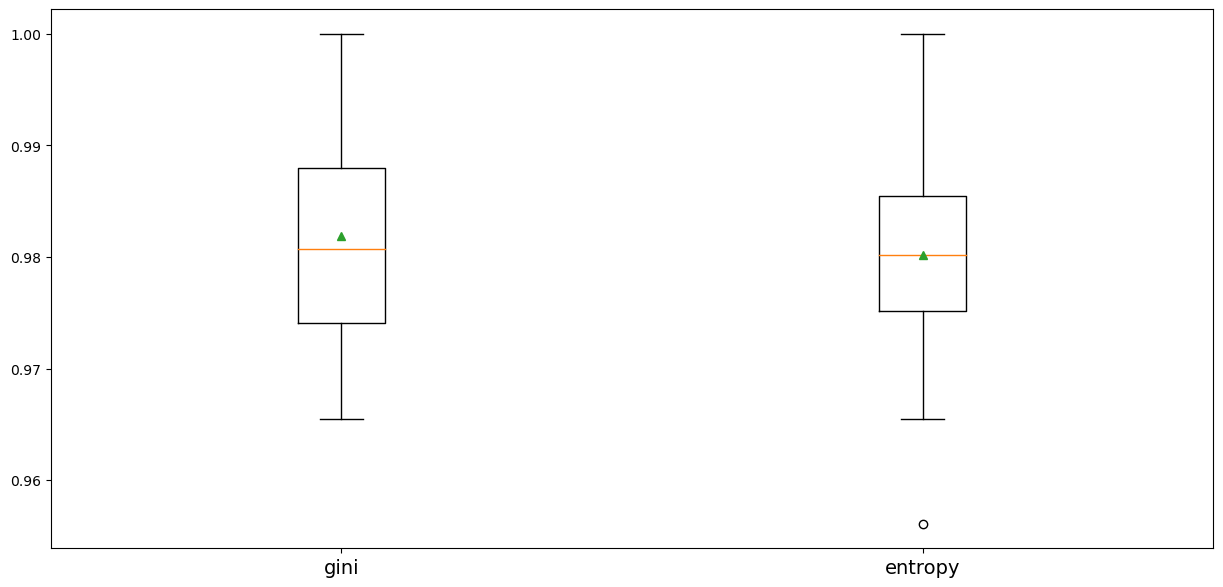

In [319]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         et_i = ExtraTreesClassifier(criterion = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_et),
#                                         ('et_standard',et_i)])     
#     return models

# models = get_models(['gini', 'entropy'])
# return_results(models,X_train_et)

- Bootstrap

>False 0.98191 (0.01062)
>True 0.97658 (0.01481)


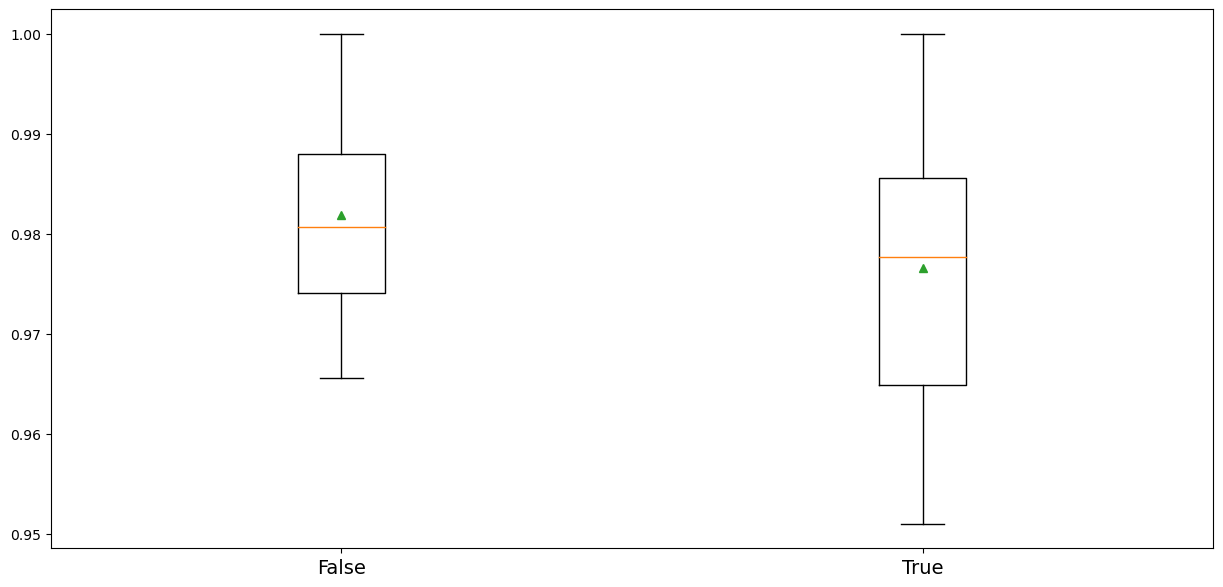

In [320]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         et_i = ExtraTreesClassifier(bootstrap = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_et),
#                                         ('et_standard',et_i)])     
#     return models

# models = get_models([False,True])
# return_results(models,X_train_et)

- Class weight

>balanced 0.97995 (0.01211)
>balanced_subsample 0.97995 (0.01211)
>None 0.98191 (0.01062)


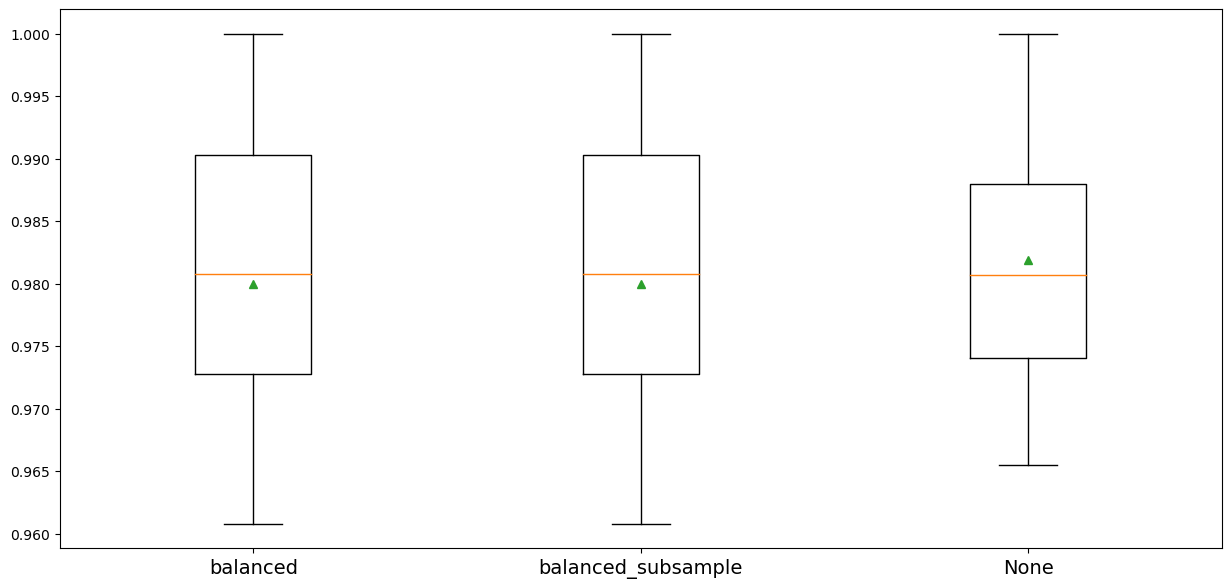

In [321]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         et_i = ExtraTreesClassifier(class_weight = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_et),
#                                         ('et_standard',et_i)])     
#     return models

# models = get_models(['balanced','balanced_subsample',None])
# return_results(models,X_train_et)

- Trees' max depth

>1 0.83088 (0.02938)
>2 0.82659 (0.02874)
>4 0.85031 (0.02635)
>6 0.89241 (0.02003)
>8 0.94518 (0.01884)
>10 0.97016 (0.01441)
>50 0.98191 (0.01062)
>100 0.98191 (0.01062)
>None 0.98191 (0.01062)


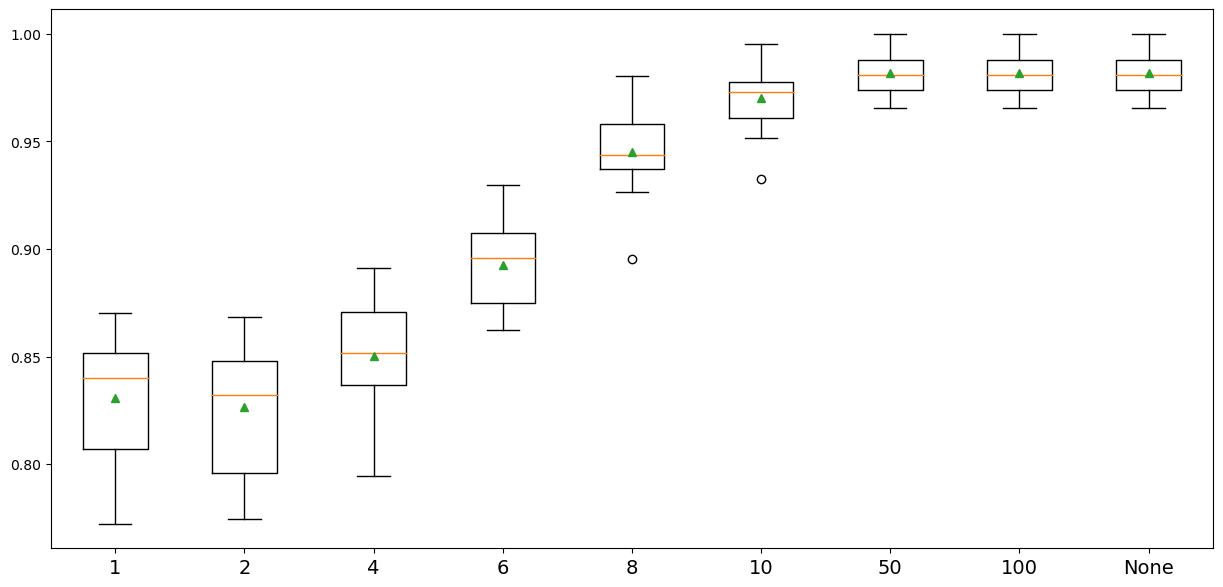

In [322]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         et_i = ExtraTreesClassifier(max_depth = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_et),
#                                         ('et_standard',et_i)])     
#     return models

# models = get_models([1,2,4,6,8,10,50,100,None])
# return_results(models,X_train_et)

- Warm Start

>False 0.98191 (0.01062)
>True 0.98191 (0.01062)


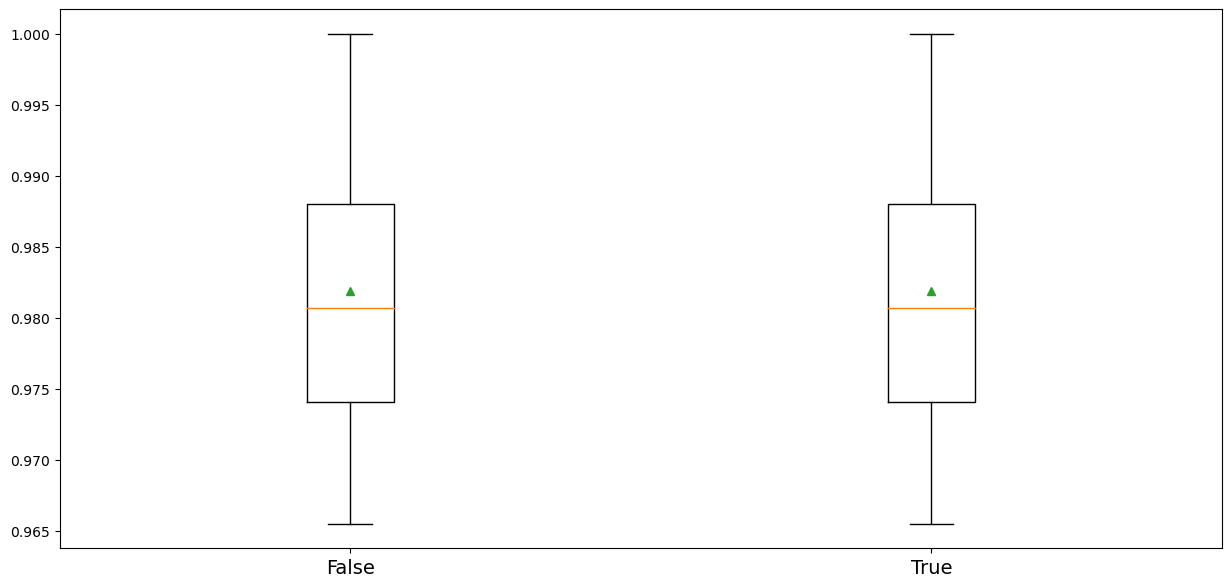

In [323]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         et_i = ExtraTreesClassifier(warm_start = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_et),
#                                         ('et_standard',et_i)])     
#     return models

# models = get_models([False,True])
# return_results(models,X_train_et)

- Out of bag score (only available if bootstrap true)

>False 0.97658 (0.01481)
>True 0.97658 (0.01481)


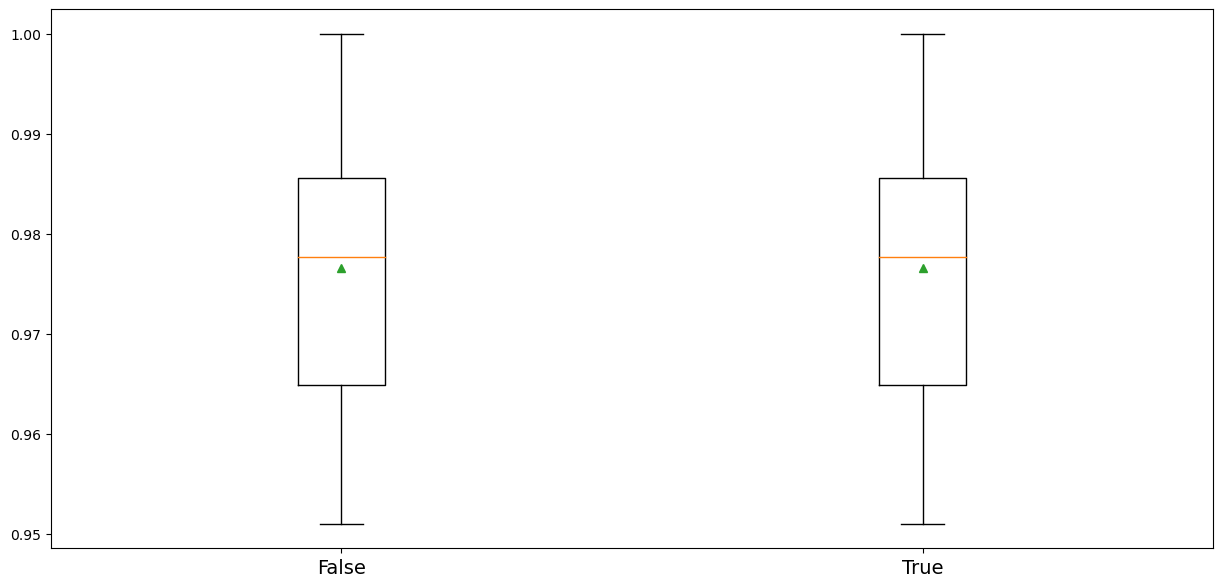

In [324]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         et_i = ExtraTreesClassifier(bootstrap = True,oob_score = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_et),
#                                         ('et_standard',et_i)])     
#     return models

# models = get_models([False,True])
# return_results(models,X_train_et)

- Max features

>sqrt 0.98191 (0.01062)
>log2 0.98191 (0.01062)
>None 0.97356 (0.01556)


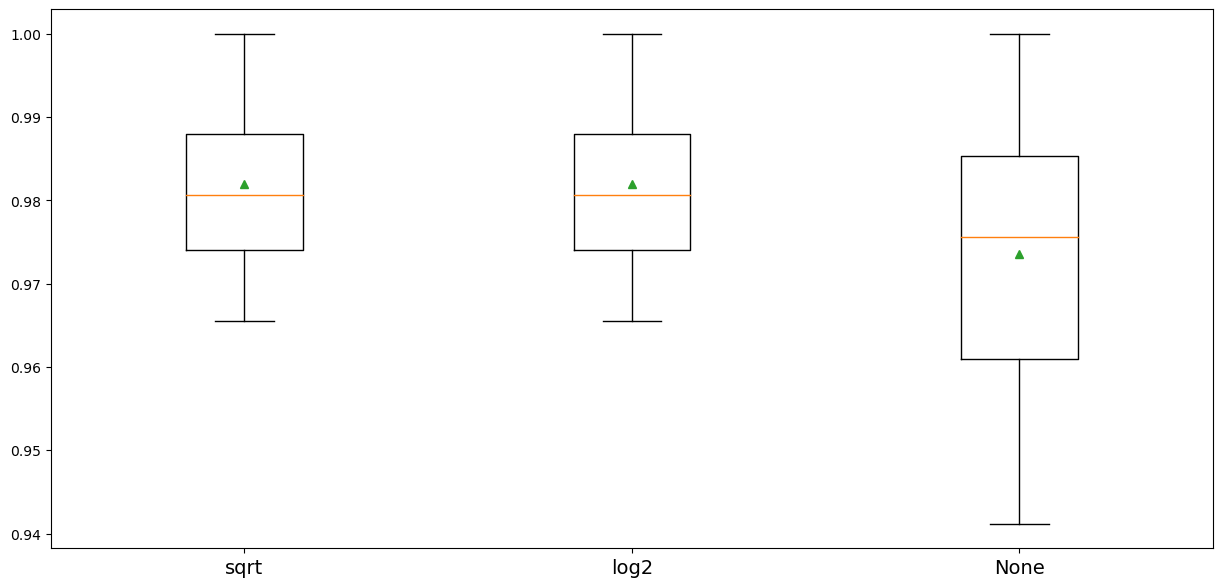

In [325]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         et_i = ExtraTreesClassifier(max_features = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_et),
#                                         ('et_standard',et_i)])     
#     return models

# models = get_models(['sqrt', 'log2', None]) #default sqrt
# return_results(models,X_train_et)

- Minimum samples split:

>2 0.98191 (0.01062)
>3 0.98168 (0.01198)
>4 0.98049 (0.01224)
>5 0.97637 (0.01472)
>6 0.97120 (0.01535)
>7 0.96301 (0.01699)
>8 0.95940 (0.01978)
>10 0.94828 (0.01938)


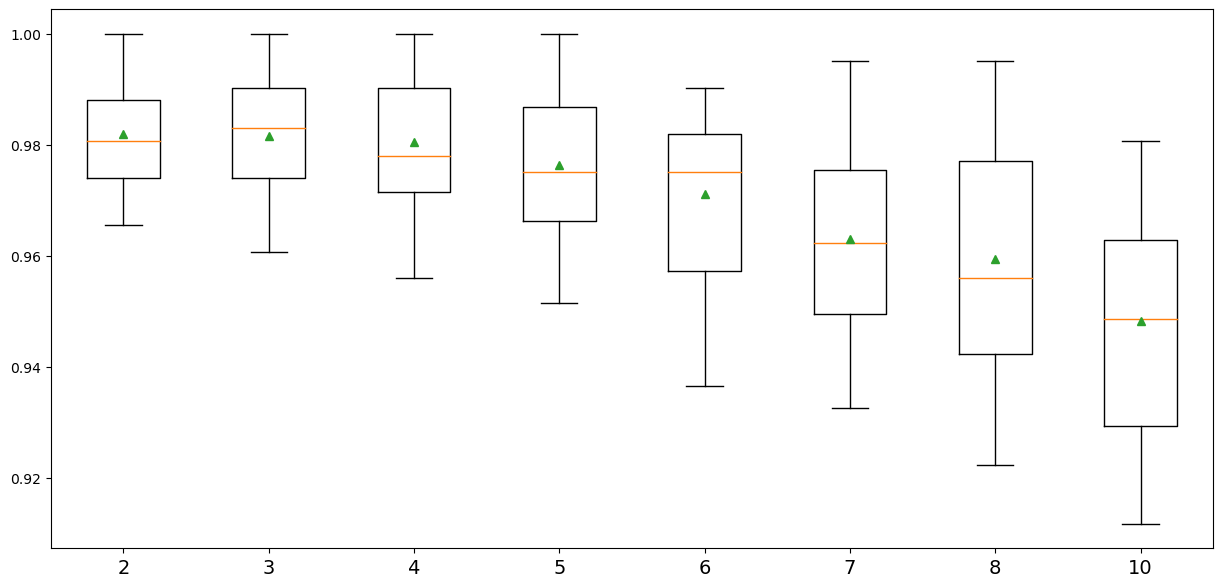

In [326]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         et_i = ExtraTreesClassifier(min_samples_split = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_et),
#                                         ('et_standard',et_i)])     
#     return models

# models = get_models([2,3,4,5,6,7,8,10]) 
# return_results(models,X_train_et)

- Min weight fraction leaf

>0 0.98191 (0.01062)
>0.1 0.83005 (0.02181)
>0.25 0.81907 (0.02762)
>0.5 0.67878 (0.00189)


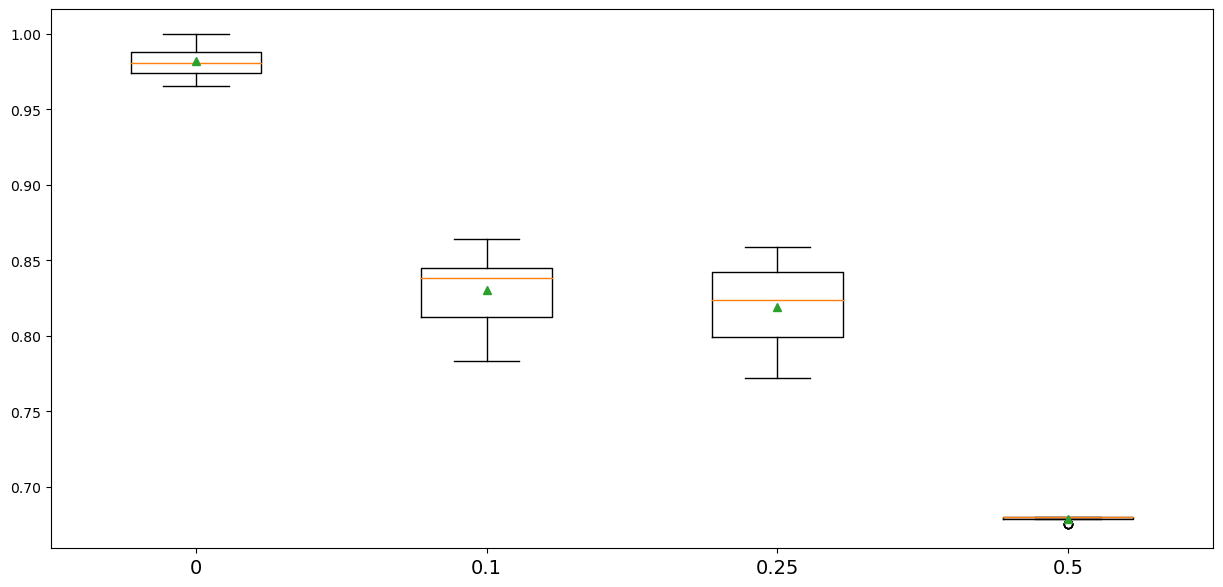

In [327]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         et_i = ExtraTreesClassifier(min_weight_fraction_leaf = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_et),
#                                         ('et_standard',et_i)])     
#     return models

# models = get_models([0,0.1,0.25,0.5]) 
# return_results(models,X_train_et)

- __RANDOM SEARCH__

In [330]:
# ## Takes around 6 mins

# param_grid = { 
#     'et_grid__n_estimators': [115,120,125,130,135,200],
#     'et_grid__criterion' :['gini','entropy'],
#     'et_grid__class_weight':['balanced', 'balanced_subsample',None],
#     'et_grid__bootstrap' :[False,True],
#     'et_grid__max_features': ['sqrt', 'log2', None]
# } 

# et_grid_pipe = Pipeline(steps=[('preprocess',preprocessor_et),
#                                         ('et_grid',et)])

# ## Let's do 5 Random searches to be more sure of the parameters we get
# param_listet = []
# for search in range(5):
#     CV_et = RandomizedSearchCV(estimator=et_grid_pipe, param_distributions=param_grid, scoring = 'f1',
#                           cv= RepeatedStratifiedKFold(n_splits=4,random_state=0,n_repeats = 5))

#     CV_et.fit(X_train_et, y_train)
    
#     param_listet.append(CV_et.best_params_)

In [331]:
# param_listet

[{'et_grid__n_estimators': 135,
  'et_grid__max_features': 'log2',
  'et_grid__criterion': 'entropy',
  'et_grid__class_weight': 'balanced_subsample',
  'et_grid__bootstrap': False},
 {'et_grid__n_estimators': 200,
  'et_grid__max_features': 'sqrt',
  'et_grid__criterion': 'gini',
  'et_grid__class_weight': None,
  'et_grid__bootstrap': False},
 {'et_grid__n_estimators': 130,
  'et_grid__max_features': 'sqrt',
  'et_grid__criterion': 'entropy',
  'et_grid__class_weight': 'balanced_subsample',
  'et_grid__bootstrap': False},
 {'et_grid__n_estimators': 125,
  'et_grid__max_features': 'sqrt',
  'et_grid__criterion': 'gini',
  'et_grid__class_weight': 'balanced',
  'et_grid__bootstrap': False},
 {'et_grid__n_estimators': 115,
  'et_grid__max_features': 'sqrt',
  'et_grid__criterion': 'entropy',
  'et_grid__class_weight': 'balanced',
  'et_grid__bootstrap': False}]

- __Grid Search__:

In [333]:
# ## TIME TO RUN: 2 minutes 
# param_grid = { 
#     'et_grid__n_estimators': [115,125,130,135,200],
#     'et_grid__criterion' :['gini','entropy'],
#     'et_grid__class_weight':['balanced', 'balanced_subsample',None]
# } 

# grid_et = GridSearchCV(estimator=et_grid_pipe, param_grid=param_grid, scoring = 'f1',
#                           cv= RepeatedStratifiedKFold(n_splits=4,random_state=0,n_repeats = 5))

# grid_et.fit(X_train_et, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=4, random_state=0),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['Birth_Year',
                                                                          'High_Cholesterol',
                                                                          'Physical_Health',
                                                                          'Blood_Pressure',
                                                                          'Mental_Health',
                                                                          'BMI']),
                                                                        ('cat',
                                                                         O

In [335]:
# grid_et.best_params_

{'et_grid__class_weight': None,
 'et_grid__criterion': 'gini',
 'et_grid__n_estimators': 130}

In [31]:
et_grid = ExtraTreesClassifier(random_state=15, criterion= 'gini', n_estimators =130,
                               max_features= 'sqrt',class_weight =None)

pipeline_et_grid = Pipeline(steps=[('preprocess',preprocessor_et),
                                        ('et_grid',et_grid)])

all_scores_et_grid = cross_val_score(pipeline_et_grid, X_train_et, y_train,
                             scoring='f1', cv = rskf4)   

In [32]:
all_scores_et_grid.mean() # previous 0.9803053014738412

0.980490022047924

#### Testing the model

In [34]:
X_test = feat_eng(test) # comment if already ran on other models

X_test_et = X_test.loc[:,feat_et]

In [35]:
pipeline_et_grid_fit_pointer = pipeline_et_grid.fit(X_train_et,y_train)

In [36]:
pred_et_grid = pipeline_et_grid.predict(X_test_et)

submission_et_grid = pd.DataFrame(pred_et_grid, index = X_test_et.index).rename(columns= {0:'Disease'})

submission_et_grid.to_csv('Group12_Version02.csv') #1 

## 4.3. Gradient Boosting Classifier

In [96]:
# gb_standard = GradientBoostingClassifier(random_state=15)

# pipeline_gb_standard = Pipeline(steps=[('preprocess',preprocessor),
#                                         ('gb_standard',gb_standard)])

# all_scores_gb = cross_val_score(pipeline_gb_standard, X_train_sel, y_train,
#                              scoring='f1', cv = rskf4)    

In [97]:
# all_scores_gb.mean()

0.9207038121726736

### 1) Searching for the best combination of features possible 

In [360]:
# # TIME TO RUN: 25 minutes
# comb_df_gb = combinations_test(X_train, sure_feat, ordinal_sure, sure_categories, sure_num,
#                       unsure_feat, unsure_categories, unsure_cat, unsure_num, gb_standard, combcv)

('Birth_Year',) 0.9355508308351815
('Blood_Pressure',) 0.9253947209924991
('Mental_Health',) 0.924014303887844
('Weight',) 0.908212409465911
('Gender',) 0.9253959172318357
('BMI',) 0.9208825547586306
('Exercise',) 0.9274000036193748
('Height',) 0.9130986744614724
('Drinking_Habit',) 0.9319735178757117
('Birth_Year', 'Blood_Pressure') 0.9426704467301661
('Birth_Year', 'Mental_Health') 0.9349318348201363
('Birth_Year', 'Weight') 0.9256628733629414
('Birth_Year', 'Gender') 0.9401435320762171
('Birth_Year', 'BMI') 0.9267985581254488
('Birth_Year', 'Exercise') 0.9370945993780255
('Birth_Year', 'Height') 0.9354963146524755
('Birth_Year', 'Drinking_Habit') 0.943706110090438
('Blood_Pressure', 'Mental_Health') 0.9218954521673906
('Blood_Pressure', 'Weight') 0.9227869477767976
('Blood_Pressure', 'Gender') 0.9272116141782927
('Blood_Pressure', 'BMI') 0.9268051692730397
('Blood_Pressure', 'Exercise') 0.9279872368608949
('Blood_Pressure', 'Height') 0.9223904187329023
('Blood_Pressure', 'Drinking_H

In [361]:
# comb_df_gb.sort_values('Score',ascending=False).head(5)

Combination     Score
476  (Birth_Year, Blood_Pressure, Mental_Health, Ge...   0.94994
393  (Birth_Year, Blood_Pressure, Mental_Health, Ge...  0.949263
163  (Birth_Year, Mental_Health, Exercise, Drinking...  0.947849
412  (Birth_Year, Blood_Pressure, Gender, BMI, Exer...  0.947745
477  (Birth_Year, Blood_Pressure, Mental_Health, Ge...  0.947022

In [362]:
# comb_df_gb.iloc[476].values

array([('Birth_Year', 'Blood_Pressure', 'Mental_Health', 'Gender', 'BMI', 'Exercise', 'Drinking_Habit'),
       0.9499395355320657], dtype=object)

In [98]:
# feat_gb = ['High_Cholesterol', 'Physical_Health', 'Fruit_Habit', 'Diabetes', 'Checkup_sure',
#             'Birth_Year', 'Blood_Pressure', 'Mental_Health', 'Gender', 'BMI', 'Exercise', 'Drinking_Habit']

# X_train_gb = X_train.loc[:,feat_gb]

# ### Encoding
# ordinal_gb = ['Fruit_Habit', 'Diabetes','Checkup_sure','Gender','Exercise','Drinking_Habit']

# categories_gb = [fruit_categories, diabetes_categories, checkup_categories,
#                  gender_categories, exercise_categories, drink_categories]

# metric_gb = ['High_Cholesterol','Physical_Health','Birth_Year','Blood_Pressure','Mental_Health','BMI']

In [99]:
# preprocessor_gb = create_preprocessor(MinMaxScaler(), metric_gb, ordinal_gb, categories_gb)

# gb = GradientBoostingClassifier(random_state=15)

# pipeline_gb = Pipeline(steps=[('preprocess',preprocessor_gb),
#                                         ('gb_standard',gb)])
    
# rskf4 = RepeatedStratifiedKFold(n_splits=4,random_state=0,n_repeats = 20)

# all_scores_gb = cross_val_score(pipeline_gb, X_train_gb, y_train,
#                              scoring='f1', cv = rskf4)    

In [100]:
# all_scores_gb.mean() #previous 0.9207038121726736

0.9486076487407619

### 3) Hyperparameter tuning 

>50 0.92778 (0.01639)
>75 0.94220 (0.01218)
>100 0.94994 (0.01265)
>125 0.95875 (0.01007)
>150 0.96409 (0.01064)
>200 0.96889 (0.01386)
>250 0.97011 (0.01370)
>300 0.97013 (0.01326)
>350 0.97085 (0.01297)
>400 0.97181 (0.01355)
>450 0.97181 (0.01355)
>500 0.97300 (0.01344)
>550 0.97250 (0.01316)
>600 0.97200 (0.01394)


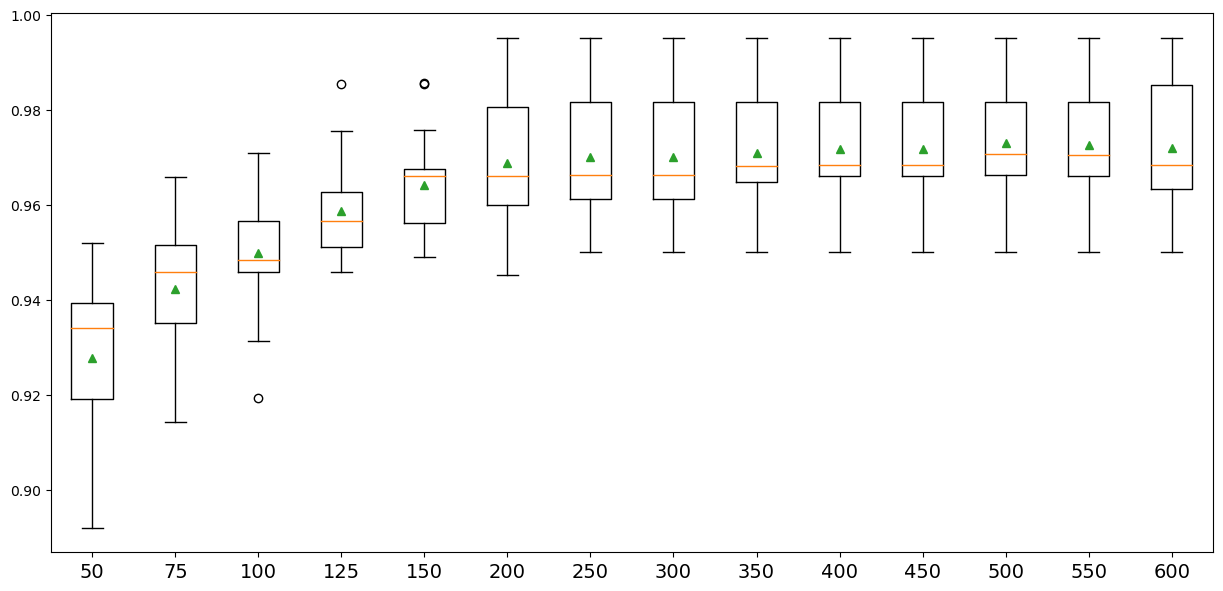

In [377]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         gb_i = GradientBoostingClassifier(n_estimators = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_gb),
#                                         ('gb_standard',gb_i)])     
#     return models

# models = get_models([50,75,100,125,150,200,250,300,350,400,450,500,550,600])
# return_results(models,X_train_gb)

- Loss function:

>deviance 0.94994 (0.01265)
>exponential 0.94344 (0.01270)


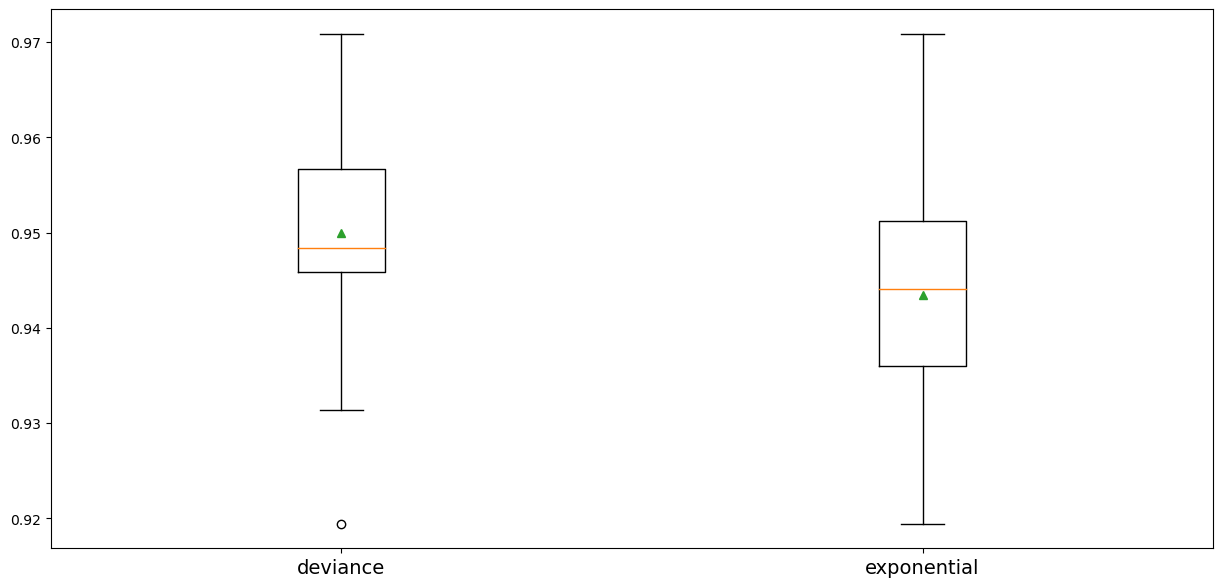

In [378]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         gb_i = GradientBoostingClassifier(loss = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_gb),
#                                         ('gb_standard',gb_i)])     
#     return models

# models = get_models(['deviance','exponential']) #deviance is deprecated in new sklearn, but is the same as new log loss
# return_results(models,X_train_gb)

- Learning rate:

>0.1 0.94994 (0.01265)
>0.25 0.96882 (0.01386)
>0.5 0.96687 (0.01489)
>1 0.96550 (0.01272)
>1.5 0.96790 (0.01443)
>1.6 0.95569 (0.02363)


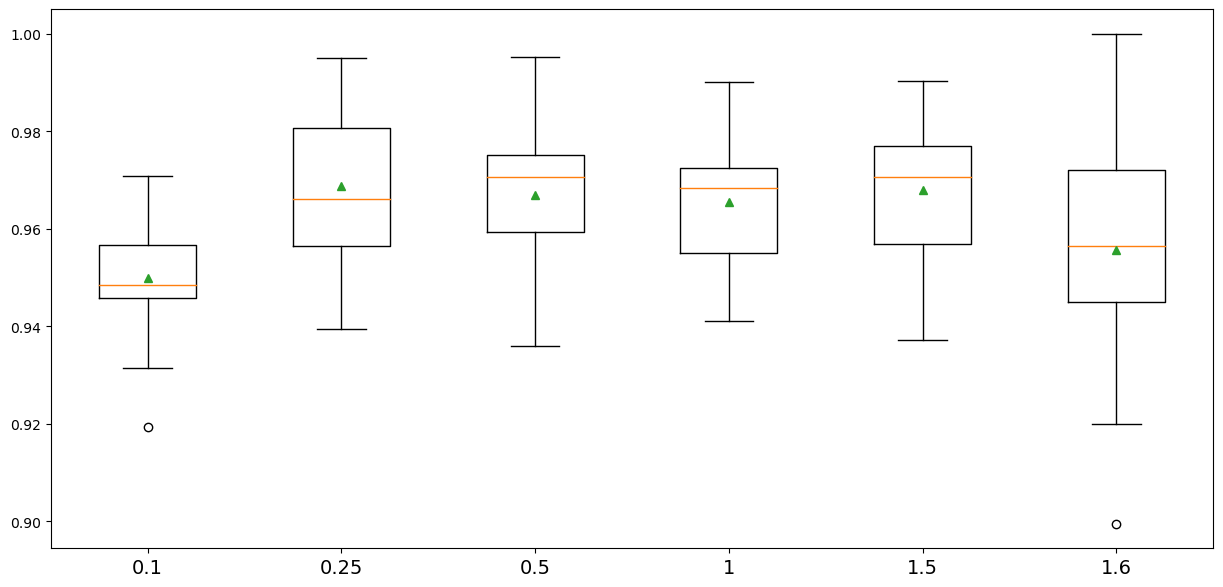

In [379]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         gb_i = GradientBoostingClassifier(learning_rate = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_gb),
#                                         ('gb_standard',gb_i)])     
#     return models

# models = get_models([0.1,0.25,0.5,1,1.5,1.6]) #0.1 standard
# return_results(models,X_train_gb)

- Criterion

>friedman_mse 0.94994 (0.01265)
>squared_error 0.94994 (0.01265)


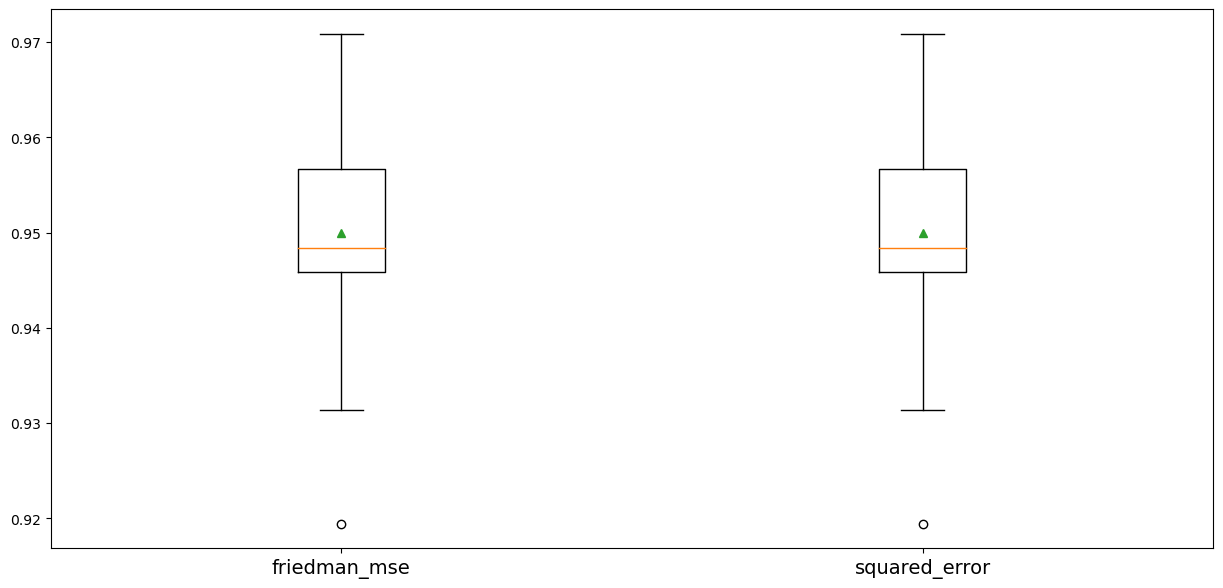

In [380]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         gb_i = GradientBoostingClassifier(criterion = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_gb),
#                                         ('gb_standard',gb_i)])     
#     return models

# models = get_models(['friedman_mse', 'squared_error'])
# return_results(models,X_train_gb)

- Maximum features

>auto 0.94994 (0.01265)
>sqrt 0.93703 (0.01863)
>log2 0.93703 (0.01863)
>None 0.94994 (0.01265)


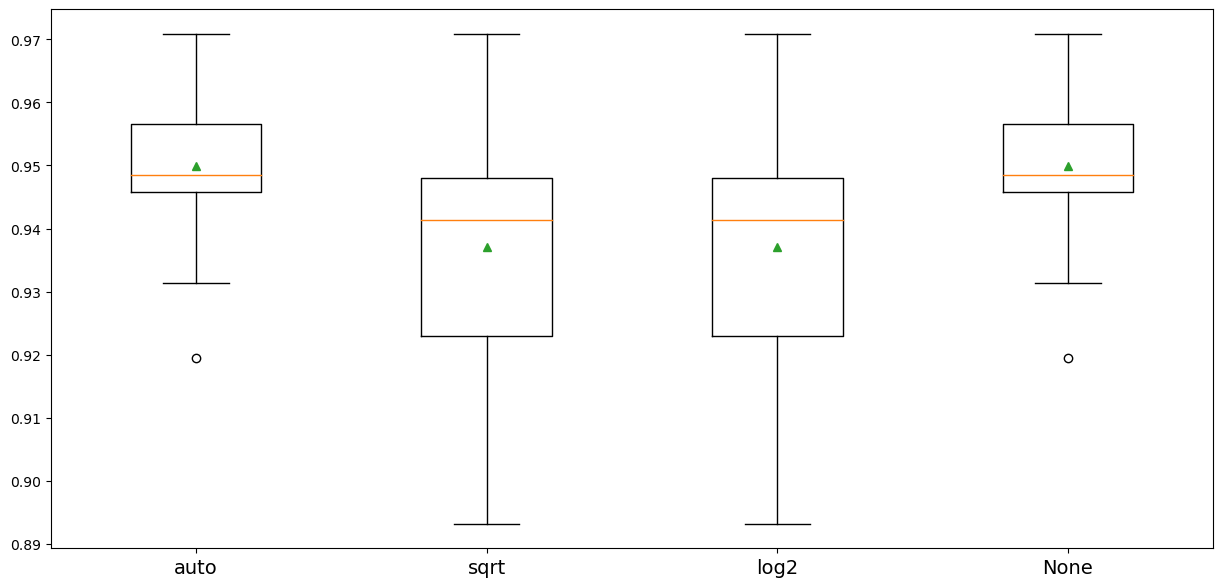

In [381]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         gb_i = GradientBoostingClassifier(max_features = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_gb),
#                                         ('gb_standard',gb_i)])     
#     return models

# models = get_models(['auto', 'sqrt', 'log2', None]) #default None
# return_results(models,X_train_gb)

- Init (compute the initial predictions with an estimator):

>RandomForestClassifier(random_state=15) 0.97281 (0.01325)
>DecisionTreeClassifier() 0.95724 (0.01863)
>ExtraTreesClassifier(random_state=15) 0.97464 (0.01371)
>None 0.94994 (0.01265)


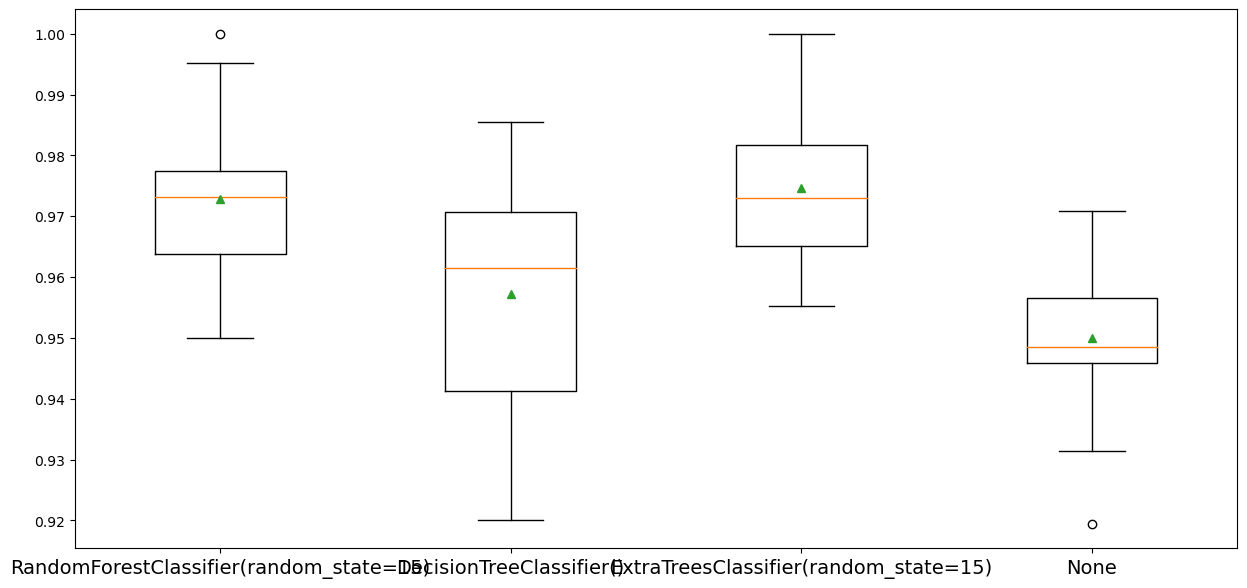

In [382]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         gb_i = GradientBoostingClassifier(init = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_gb),
#                                         ('gb_standard',gb_i)])     
#     return models

# models = get_models([RandomForestClassifier(random_state=15), DecisionTreeClassifier(),
#                      ExtraTreesClassifier(random_state=15),None])
# return_results(models,X_train_gb)

- Maximum depth

>2 0.90788 (0.02016)
>3 0.94994 (0.01265)
>4 0.97031 (0.01261)
>5 0.97543 (0.01100)
>7 0.96799 (0.01559)
>10 0.95844 (0.02004)
>15 0.95961 (0.02002)
>20 0.95961 (0.02002)
>50 0.95961 (0.02002)
>None 0.95961 (0.02002)


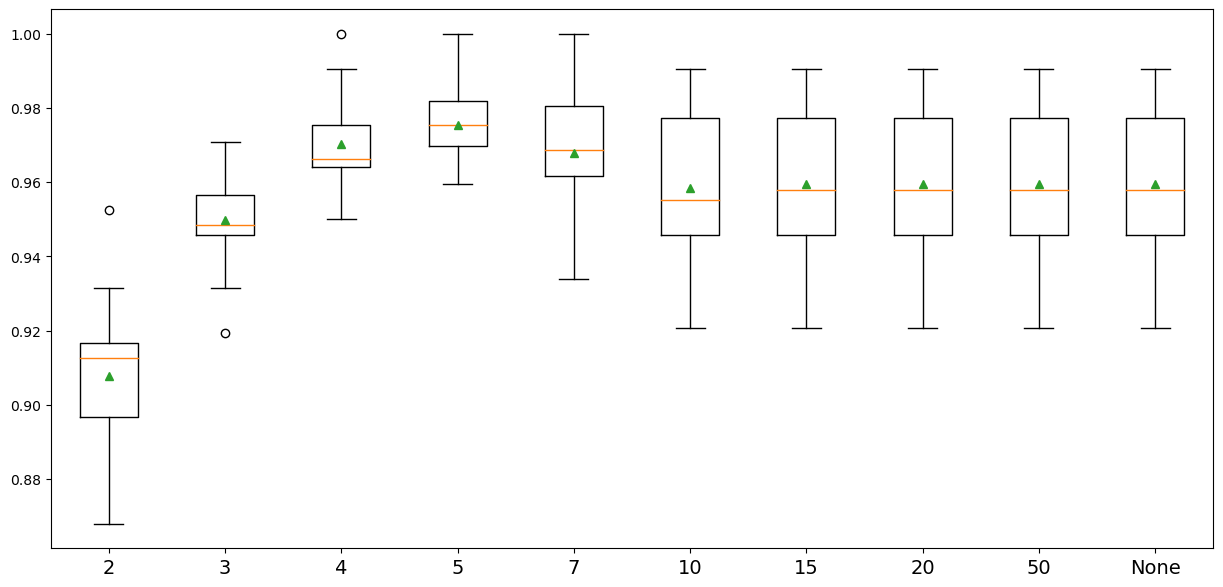

In [383]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         gb_i = GradientBoostingClassifier(max_depth = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_gb),
#                                         ('gb_standard',gb_i)])     
#     return models

# models = get_models([2,3,4,5,7,10,15,20,50,None]) #default 3
# return_results(models,X_train_gb)

- Subsample:

>0.25 0.93332 (0.01519)
>0.5 0.94500 (0.01562)
>0.75 0.95159 (0.01350)
>1 0.94994 (0.01265)


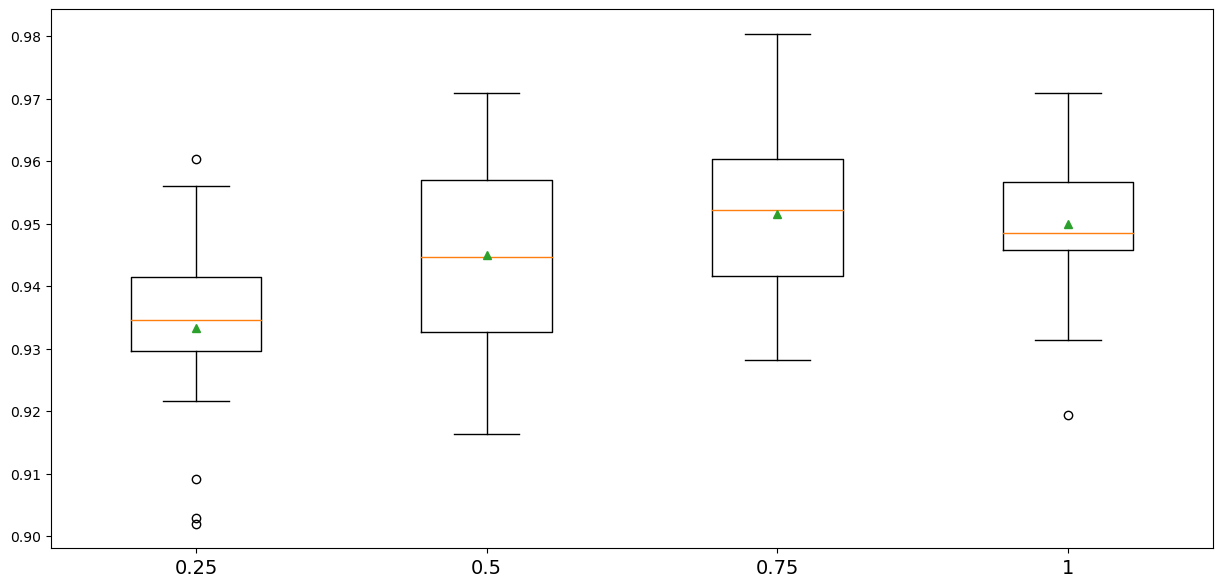

In [384]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         gb_i = GradientBoostingClassifier(subsample = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_gb),
#                                         ('gb_standard',gb_i)])     
#     return models

# models = get_models([0.25,0.5,0.75,1]) #default 1
# return_results(models,X_train_gb)

- Warm start

>False 0.94994 (0.01265)
>True 0.94994 (0.01265)


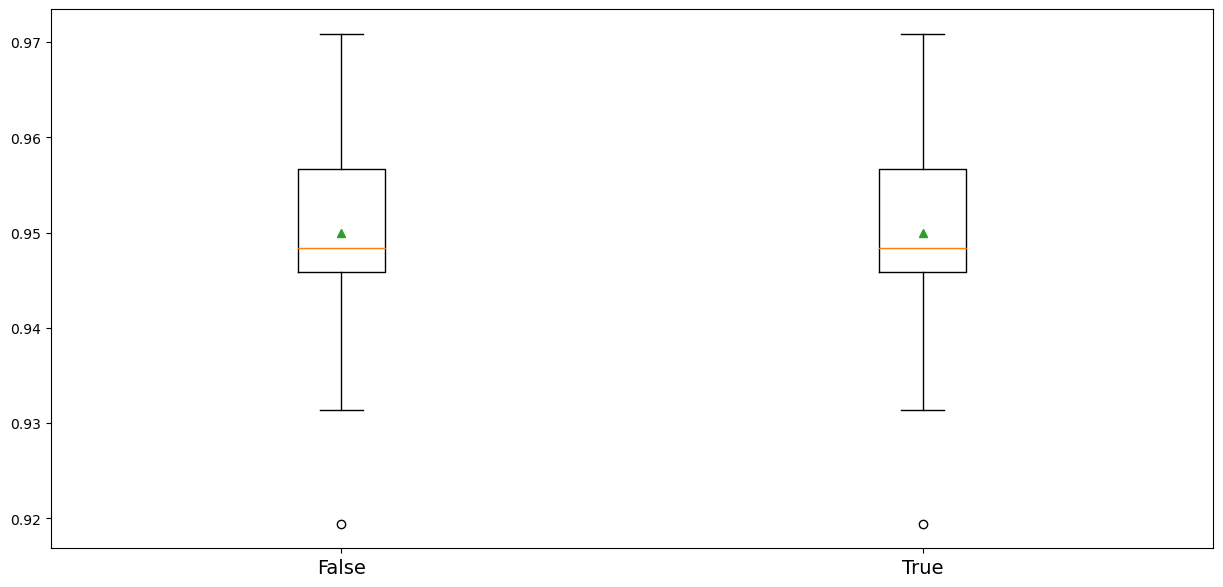

In [385]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         gb_i = GradientBoostingClassifier(warm_start = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_gb),
#                                         ('gb_standard',gb_i)])     
#     return models

# models = get_models([False, True]) #default False
# return_results(models,X_train_gb)

- __RANDOM SEARCH__

In [386]:
# ## TIME TO RUN: 5 minutes
# param_grid_gb = { 
#     'gb_grid__n_estimators': [200,250,300,350,400,450,500],
#     'gb_grid__loss': ['deviance','exponential'],
#     'gb_grid__init' :[RandomForestClassifier(random_state=15), DecisionTreeClassifier(),
#                      ExtraTreesClassifier(random_state=15),None],
#     'gb_grid__learning_rate' :[0.25,0.5,0.75,1,1.5],
#     'gb_grid__max_depth':[4,5,6,7,8,9,10,None],
#     'gb_grid__subsample' :[0.5,0.6,0.75,1]
# }

# gb_grid_pipe = Pipeline(steps=[('preprocess',preprocessor_gb),
#                                         ('gb_grid',gb)])

# ## Let's do 5 Random searches to be more sure of the parameters we get
# param_listgb = []
# for search in range(5):
#     CV_gb = RandomizedSearchCV(estimator=gb_grid_pipe, param_distributions=param_grid_gb, scoring = 'f1',
#                           cv= RepeatedStratifiedKFold(n_splits=4,random_state=0,n_repeats = 5))

#     CV_gb.fit(X_train_gb, y_train)
    
#     param_listgb.append(CV_gb.best_params_)

In [387]:
# param_listgb

[{'gb_grid__subsample': 0.75,
  'gb_grid__n_estimators': 250,
  'gb_grid__max_depth': 5,
  'gb_grid__loss': 'exponential',
  'gb_grid__learning_rate': 0.5,
  'gb_grid__init': ExtraTreesClassifier(random_state=15)},
 {'gb_grid__subsample': 0.6,
  'gb_grid__n_estimators': 200,
  'gb_grid__max_depth': None,
  'gb_grid__loss': 'deviance',
  'gb_grid__learning_rate': 0.25,
  'gb_grid__init': ExtraTreesClassifier(random_state=15)},
 {'gb_grid__subsample': 1,
  'gb_grid__n_estimators': 500,
  'gb_grid__max_depth': 7,
  'gb_grid__loss': 'exponential',
  'gb_grid__learning_rate': 0.5,
  'gb_grid__init': ExtraTreesClassifier(random_state=15)},
 {'gb_grid__subsample': 0.6,
  'gb_grid__n_estimators': 400,
  'gb_grid__max_depth': 9,
  'gb_grid__loss': 'exponential',
  'gb_grid__learning_rate': 0.5,
  'gb_grid__init': ExtraTreesClassifier(random_state=15)},
 {'gb_grid__subsample': 1,
  'gb_grid__n_estimators': 450,
  'gb_grid__max_depth': 6,
  'gb_grid__loss': 'exponential',
  'gb_grid__learning_rat

In [394]:
# ## TIME TO RUN: under 5 minutes 
# param_grid_gb = { 
#     'gb_grid__n_estimators': [250,400],
#     'gb_grid__loss': ['exponential'],
#     'gb_grid__learning_rate' :[0.25,0.5],
#     'gb_grid__max_depth':[4,5,7,9,None],
#     'gb_grid__subsample' :[0.5,0.6,0.75,1]
# }


# grid_gb = GridSearchCV(estimator=gb_grid_pipe, param_grid=param_grid_gb, scoring = 'f1',
#                           cv= StratifiedKFold(n_splits=4))

# grid_gb.fit(X_train_gb, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['High_Cholesterol',
                                                                          'Physical_Health',
                                                                          'Birth_Year',
                                                                          'Blood_Pressure',
                                                                          'Mental_Health',
                                                                          'BMI']),
                                                                        ('cat',
                                                                         Ordi

In [397]:
# grid_gb.best_params_

{'gb_grid__learning_rate': 0.5,
 'gb_grid__loss': 'exponential',
 'gb_grid__max_depth': 4,
 'gb_grid__n_estimators': 250,
 'gb_grid__subsample': 0.75}

In [101]:
# gb_grid = GradientBoostingClassifier(init = ExtraTreesClassifier(random_state=15),
#                                      random_state=15, subsample = 0.75, n_estimators =250,
#                                     max_depth=4, learning_rate = 0.5,loss = 'exponential')

# pipeline_gb_grid = Pipeline(steps=[('preprocess',preprocessor_gb),
#                                         ('gb_grid',gb_grid)])

# all_scores_gb_grid = cross_val_score(pipeline_gb_grid, X_train_gb, y_train,
#                              scoring='f1', cv = rskf4)   

In [102]:
#all_scores_gb_grid.mean() #previous 0.9471160623815218

0.9758342335692269

#### Testing the model

In [103]:
# # X_test = feat_eng(test) # comment if already ran on other models

# X_test_gb = X_test.loc[:,feat_gb]

In [104]:
# pipeline_gb_grid_fit_pointer = pipeline_gb_grid.fit(X_train_gb,y_train)

In [105]:
# pred_gb_grid = pipeline_gb_grid.predict(X_test_gb)

# submission_gb_grid = pd.DataFrame(pred_gb_grid, index = X_test_gb.index).rename(columns= {0:'Disease'})

# submission_gb_grid.to_csv('Group12_Version03.csv') #1 

## 4.4. Support Vector Machines

In [106]:
# svc_standard = SVC(random_state=15)

# pipeline_svc_standard = Pipeline(steps=[('preprocess',preprocessor),
#                                         ('svc_standard',svc_standard)])
    
# rskf4 = RepeatedStratifiedKFold(n_splits=4,random_state=0,n_repeats = 20)

# all_scores = cross_val_score(pipeline_svc_standard, X_train_sel, y_train,
#                              scoring='f1', cv = rskf4)    

In [107]:
# all_scores.mean()

0.8318356648297414

In [96]:
# svc_standard = SVC(random_state=15)

# # Can't be repeated because it would take too long
# skf4 = StratifiedKFold(n_splits=4)

# # TIME TO RUN: 3 minutes
# comb_df = combinations_test(X_train, sure_feat, ordinal_sure, sure_categories, sure_num,
#                       unsure_feat, unsure_categories, unsure_cat, unsure_num, svc_standard, skf4)

('Birth_Year',) 0.8230899942098122
('Blood_Pressure',) 0.8212616198053779
('Mental_Health',) 0.8281113449761209
('Weight',) 0.827770712719738
('Gender',) 0.8213100800610258
('BMI',) 0.8260907878308522
('Exercise',) 0.8276946167328583
('Height',) 0.8217293265755596
('Drinking_Habit',) 0.8331008060944283
('Birth_Year', 'Blood_Pressure') 0.8202509699466515
('Birth_Year', 'Mental_Health') 0.8289879756900506
('Birth_Year', 'Weight') 0.8306628779054834
('Birth_Year', 'Gender') 0.8209879892314119
('Birth_Year', 'BMI') 0.830207589211586
('Birth_Year', 'Exercise') 0.8350865085183197
('Birth_Year', 'Height') 0.8203817934305911
('Birth_Year', 'Drinking_Habit') 0.8307565798216928
('Blood_Pressure', 'Mental_Health') 0.8329084043647812
('Blood_Pressure', 'Weight') 0.8302097474558593
('Blood_Pressure', 'Gender') 0.8204453787652426
('Blood_Pressure', 'BMI') 0.829102539282289
('Blood_Pressure', 'Exercise') 0.8338948824250152
('Blood_Pressure', 'Height') 0.8175613246977695
('Blood_Pressure', 'Drinking_H

In [97]:
# comb_df.sort_values('Score',ascending=False).head(5)

Combination     Score
459  (Mental_Health, Weight, Gender, BMI, Exercise,...  0.867812
494  (Blood_Pressure, Mental_Health, Weight, Gender...  0.867584
502  (Birth_Year, Blood_Pressure, Mental_Health, We...  0.867555
500  (Mental_Health, Weight, Gender, BMI, Exercise,...  0.866902
509  (Blood_Pressure, Mental_Health, Weight, Gender...  0.866287

In [98]:
# comb_df.iloc[247,0]

('Weight', 'BMI', 'Exercise', 'Drinking_Habit')

In [108]:
# feat_svc = ['High_Cholesterol','Physical_Health', 'Fruit_Habit', 'Diabetes','Checkup_sure',
#             'Exercise', 'Drinking_Habit', 'Weight', 'BMI']

# X_train_svc = X_train.loc[:,feat_svc]

# ### Create the preprocessor
# metric_svc = ['High_Cholesterol', 'Physical_Health', 'Weight', 'BMI']
# ordinal_svc = ['Fruit_Habit', 'Diabetes','Checkup_sure', 'Exercise','Drinking_Habit']
# categories_svc = [fruit_categories, diabetes_categories, checkup_categories, exercise_categories, drink_categories]

# preprocessor_svc = create_preprocessor(MinMaxScaler(), metric_svc, ordinal_svc, categories_svc)

In [109]:
# svc = SVC(random_state=15)

# pipeline_svc = Pipeline(steps=[('preprocess',preprocessor_svc),
#                                         ('svc_standard',svc)])
    
# rskf4 = RepeatedStratifiedKFold(n_splits=4,random_state=0,n_repeats = 20)

# all_scores_svc = cross_val_score(pipeline_svc, X_train_svc, y_train,
#                              scoring='f1', cv = rskf4)    

In [110]:
# all_scores_svc.mean()

0.8469374329965218

### Parameter Tuning

>0.01 0.81296 (0.03428)
>0.1 0.82407 (0.02753)
>1 0.84862 (0.01720)
>10 0.88545 (0.01693)
>20 0.89729 (0.01810)
>30 0.90079 (0.01654)
>44 0.90522 (0.01659)
>50 0.90800 (0.01652)
>100 0.91382 (0.01497)
>200 0.91477 (0.01588)
>300 0.91826 (0.01932)
>400 0.92207 (0.01760)
>500 0.92180 (0.01775)
>1000 0.92613 (0.01598)


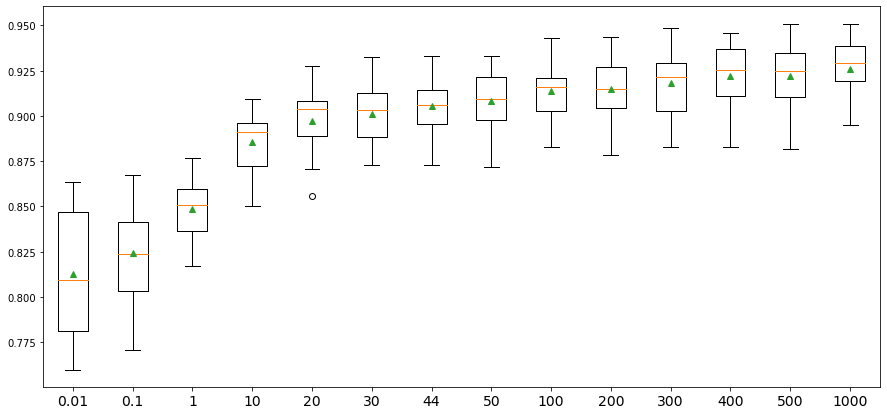

In [113]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         svc_i = SVC(C = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_svc),
#                                         ('svc_standard',svc_i)])     
#     return models

# models = get_models([0.01, 0.1, 1, 10, 20, 30, 44, 50, 100, 200, 300, 400, 500, 1000])
# return_results(models,X_train_svc)

>linear 0.82488 (0.02613)
>poly 0.85346 (0.02662)
>rbf 0.84862 (0.01720)
>sigmoid 0.73892 (0.04776)


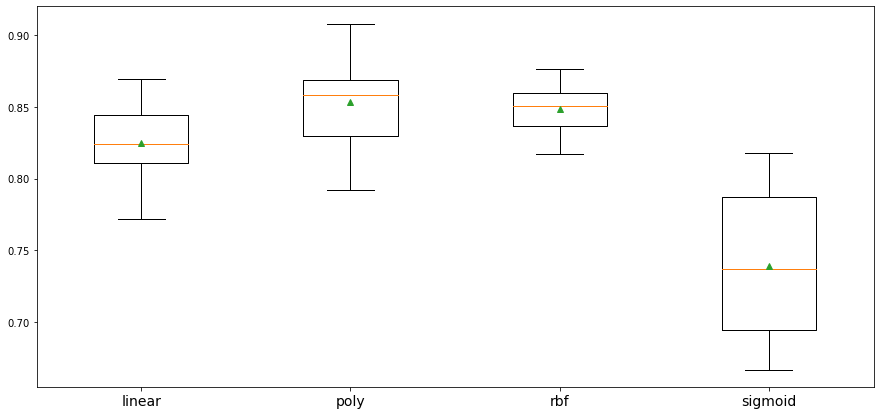

In [114]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         svc_i = SVC(kernel = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_svc),
#                                         ('svc_standard',svc_i)])     
#     return models

# models = get_models(['linear', 'poly', 'rbf', 'sigmoid'])
# return_results(models,X_train_svc)

>1 0.82926 (0.02472)
>2 0.83904 (0.02340)
>3 0.85346 (0.02662)
>4 0.86574 (0.02909)
>5 0.87165 (0.03203)
>6 0.86584 (0.03267)
>7 0.85739 (0.02780)
>8 0.85366 (0.02426)
>9 0.84470 (0.02466)
>10 0.83544 (0.02438)
>11 0.83100 (0.02159)
>12 0.82300 (0.02351)
>13 0.82008 (0.02298)
>20 0.79944 (0.03177)
>30 0.79152 (0.03234)


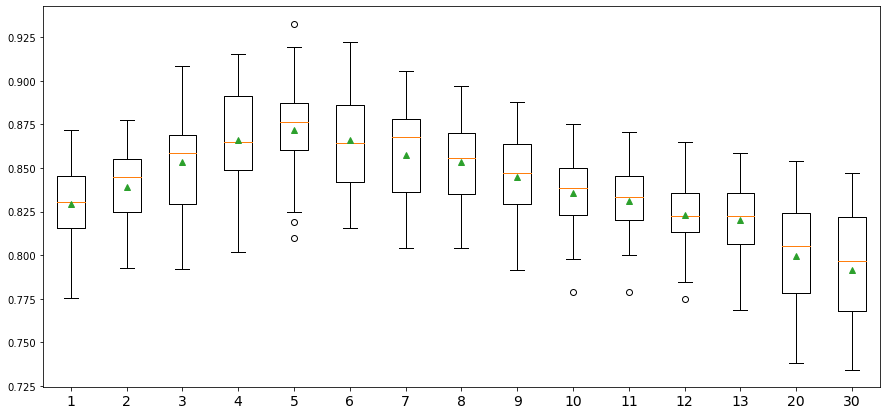

In [115]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         svc_i = SVC(kernel = "poly", degree = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_svc),
#                                         ('svc_standard',svc_i)])     
#     return models

# models = get_models([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 20, 30])
# return_results(models,X_train_svc)

>scale 0.84862 (0.01720)
>auto 0.84258 (0.01986)


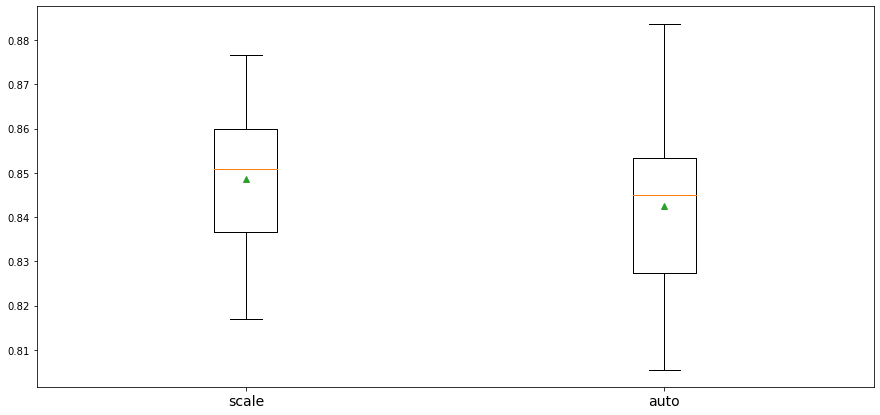

In [116]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         svc_i = SVC(gamma= value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_svc),
#                                         ('svc_standard',svc_i)])     
#     return models

# models = get_models(['scale', 'auto'])
# return_results(models,X_train_svc)

>0.0 0.85346 (0.02662)
>0.01 0.85477 (0.02695)
>0.1 0.86529 (0.02423)
>0.5 0.87422 (0.01803)
>10 0.88610 (0.01599)
>100 0.87617 (0.02456)
>500 0.85761 (0.02083)
>1000 0.86796 (0.01944)


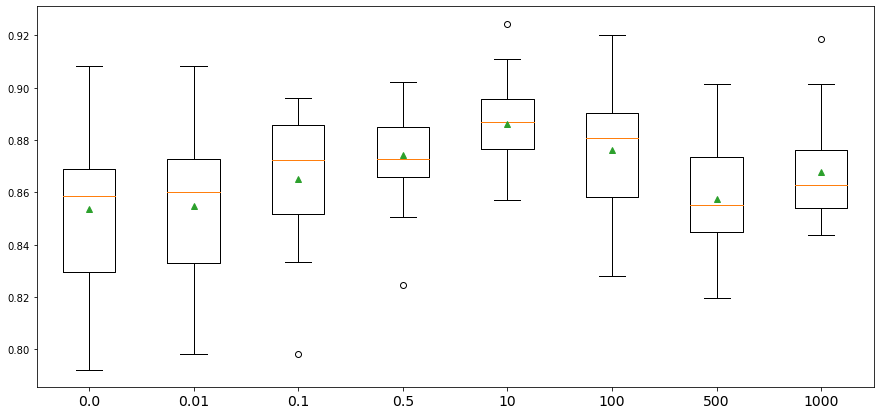

In [117]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         svc_i = SVC(coef0 = value, kernel = "poly", random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_svc),
#                                         ('svc_standard',svc_i)])     
#     return models

# models = get_models([0.0, 0.01, 0.1, 0.5, 10, 100, 500, 1000])
# return_results(models,X_train_svc)

>True 0.84862 (0.01720)
>False 0.84862 (0.01720)


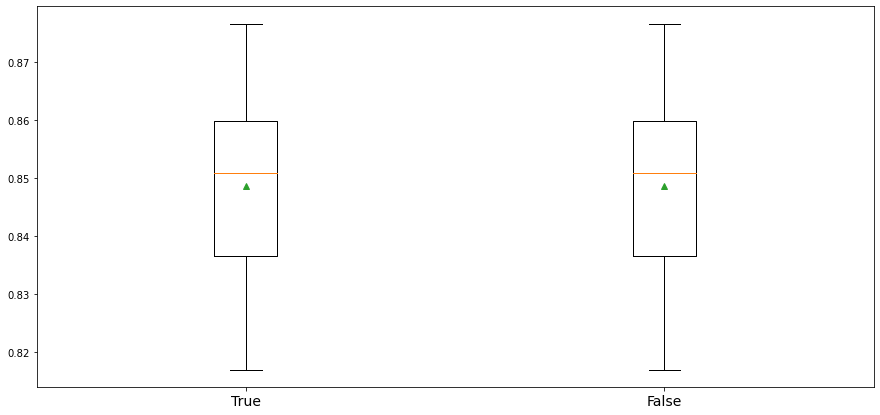

In [118]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         svc_i = SVC(shrinking = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_svc),
#                                         ('svc_standard',svc_i)])     
#     return models

# models = get_models([True, False])
# return_results(models,X_train_svc)

>True 0.84862 (0.01720)
>False 0.84862 (0.01720)


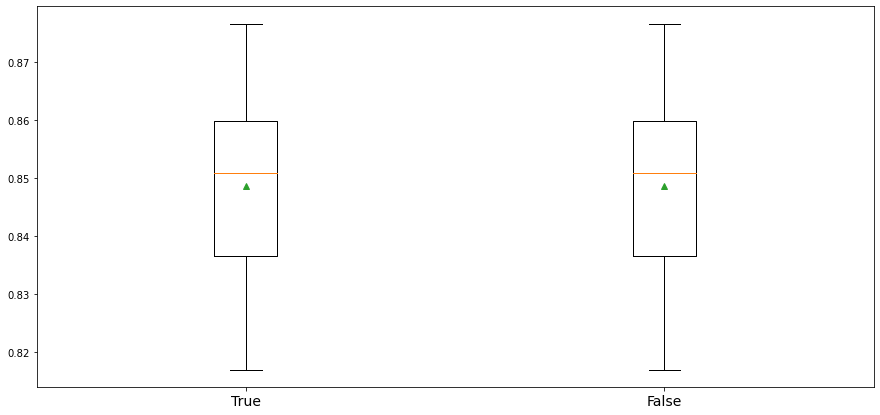

In [119]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         svc_i = SVC(probability = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_svc),
#                                         ('svc_standard',svc_i)])     
#     return models

# models = get_models([True, False])
# return_results(models,X_train_svc)

>balanced 0.84891 (0.01807)
>None 0.84862 (0.01720)


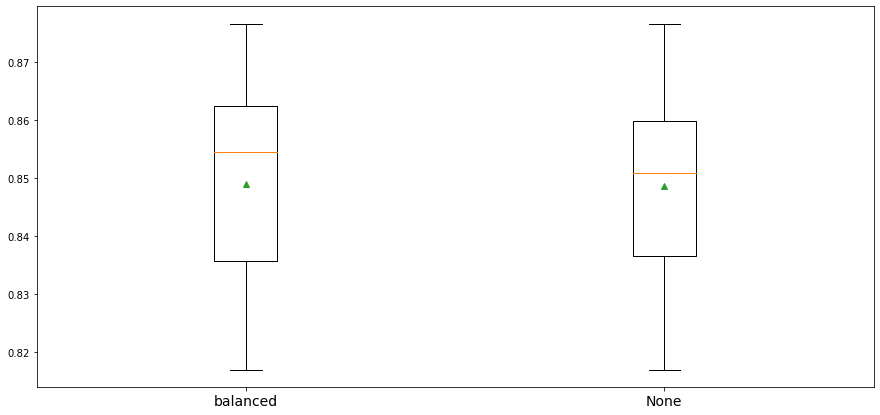

In [120]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         svc_i = SVC(class_weight = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_svc),
#                                         ('svc_standard',svc_i)])     
#     return models

# models = get_models(['balanced', None])
# return_results(models,X_train_svc)

>ovo 0.84862 (0.01720)
>ovr 0.84862 (0.01720)


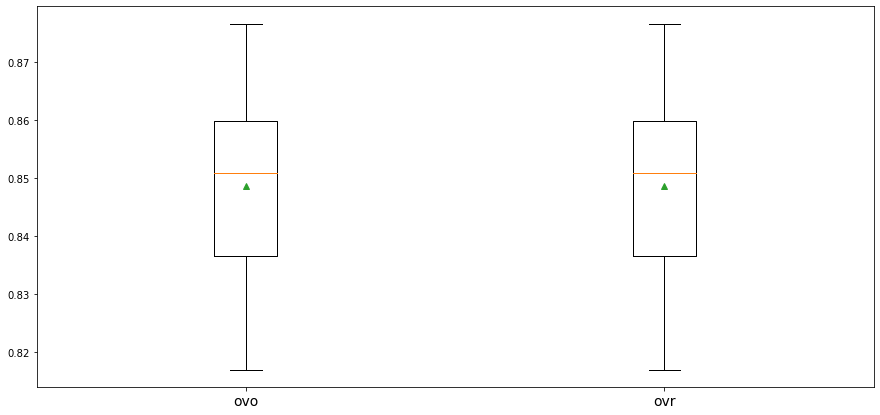

In [121]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         svc_i = SVC(decision_function_shape = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_svc),
#                                         ('svc_standard',svc_i)])     
#     return models

# models = get_models(['ovo', 'ovr'])
# return_results(models,X_train_svc)

>True 0.84862 (0.01720)
>False 0.84862 (0.01720)


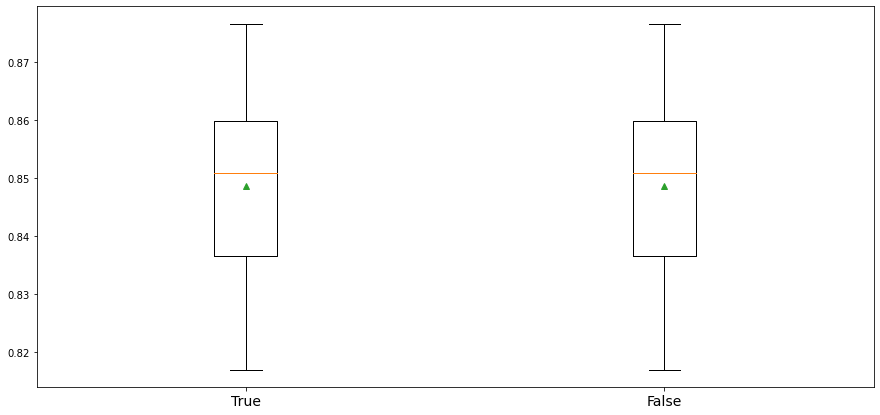

In [122]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         svc_i = SVC(break_ties = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_svc),
#                                         ('svc_standard',svc_i)])     
#     return models

# models = get_models([True, False])
# return_results(models,X_train_svc)

### Random Search

In [124]:
# param_grid = { 
#     'svc_grid__C': [50, 100, 200, 300, 400, 500, 700, 1000, 2000, 5000],
#     'svc_grid__kernel' :['linear', 'poly', 'rbf'],
#     'svc_grid__coef0' :[1, 10, 20, 30, 40, 50, 75, 100, 200],
#     'svc_grid__class_weight':['balanced', None],
#     'svc_grid__gamma':['scale', 'auto']
# } # the "model name__" has to be used so the gridsearch "knows" where to put the parameters

# svc_grid_pipe = Pipeline(steps=[('preprocess',preprocessor_svc),
#                                         ('svc_grid',svc)])

# ## Let's do 5 Random searches to be more sure of the parameters we get
# param_list = []
# for search in range(5):
#     CV_svc = RandomizedSearchCV(estimator=svc_grid_pipe, param_distributions=param_grid, scoring = 'f1',
#                           cv= RepeatedStratifiedKFold(n_splits=4,random_state=0,n_repeats = 5))

#     CV_svc.fit(X_train_svc, y_train)
    
#     param_list.append(CV_svc.best_params_)

In [125]:
# param_list

[{'svc_grid__kernel': 'rbf',
  'svc_grid__gamma': 'scale',
  'svc_grid__coef0': 30,
  'svc_grid__class_weight': 'balanced',
  'svc_grid__C': 2000},
 {'svc_grid__kernel': 'rbf',
  'svc_grid__gamma': 'scale',
  'svc_grid__coef0': 10,
  'svc_grid__class_weight': None,
  'svc_grid__C': 1000},
 {'svc_grid__kernel': 'poly',
  'svc_grid__gamma': 'scale',
  'svc_grid__coef0': 10,
  'svc_grid__class_weight': 'balanced',
  'svc_grid__C': 100},
 {'svc_grid__kernel': 'rbf',
  'svc_grid__gamma': 'scale',
  'svc_grid__coef0': 30,
  'svc_grid__class_weight': None,
  'svc_grid__C': 1000},
 {'svc_grid__kernel': 'rbf',
  'svc_grid__gamma': 'scale',
  'svc_grid__coef0': 20,
  'svc_grid__class_weight': 'balanced',
  'svc_grid__C': 500}]

### Grid Search

In [128]:
# param_grid = { 
#     'svc_grid__kernel':['rbf', 'poly'],
#     'svc_grid__coef0' :[10, 20, 30],
#     'svc_grid__class_weight':['balanced', None],
#     'svc_grid__C':[100, 500, 1000, 2000]
# } 

# grid_svc = GridSearchCV(estimator=svc_grid_pipe, param_grid=param_grid, scoring = 'f1',
#                           cv= RepeatedStratifiedKFold(n_splits=4,random_state=0,n_repeats = 5))

# grid_svc.fit(X_train_svc, y_train)
    
# grid_svc.best_params_

{'svc_grid__C': 1000,
 'svc_grid__class_weight': None,
 'svc_grid__coef0': 10,
 'svc_grid__kernel': 'rbf'}

In [111]:
# svc_grid = SVC(random_state=15, C = 1000, kernel = 'rbf', coef0 = 10, class_weight = None)

# pipeline_svc_grid = Pipeline(steps=[('preprocess',preprocessor_svc),
#                                         ('svc_grid',svc_grid)])
    
# rskf4 = RepeatedStratifiedKFold(n_splits=4,random_state=0,n_repeats = 20)

# all_scores_svc_grid = cross_val_score(pipeline_svc_grid, X_train_svc, y_train,
#                              scoring='f1', cv = rskf4)  

In [112]:
# all_scores_svc_grid.mean()

0.9265598684282803

#### Testing the model

In [122]:
# # X_test = feat_eng(test) # comment if already ran on other models

# X_test_svc = X_test.loc[:,feat_svc]

In [123]:
# pipeline_svc_grid_fit_pointer = pipeline_svc_grid.fit(X_train_svc,y_train)

In [219]:
# pred_svc_grid = pipeline_svc_grid.predict(X_test_svc)

# submission_svc_grid = pd.DataFrame(pred_svc_grid, index = X_test_svc.index).rename(columns= {0:'Disease'})

# submission_svc_grid.to_csv('Group12_Version05.csv') #0.91666

## 4.5. K-Nearest Neighbours Classifier

In [125]:
# KNN_standard = KNeighborsClassifier()

# pipeline_rfc_standard = Pipeline(steps=[('preprocess',preprocessor),
#                                         ('KNN_standard',KNN_standard)])
    
# all_scores = cross_val_score(pipeline_rfc_standard, X_train_sel, y_train,
#                              scoring='f1', cv = rskf4)

In [126]:
# all_scores.mean()

0.814888166559182

### 1) Trying to combine the sure features with all possible combinations of unsure to see improvement on score:

In [436]:
# comb_df_KN = combinations_test(X_train, sure_feat, ordinal_sure, sure_categories, sure_num,
#                       unsure_feat, unsure_categories, unsure_cat, unsure_num, KNN_standard, combcv)

('Birth_Year',) 0.8100786363113308
('Blood_Pressure',) 0.8151679218058513
('Mental_Health',) 0.8227749151142326
('Weight',) 0.8465783418045371
('Gender',) 0.8363566548099837
('BMI',) 0.8510796262330826
('Exercise',) 0.8190561031580927
('Height',) 0.8279566950206263
('Drinking_Habit',) 0.820741240283579
('Birth_Year', 'Blood_Pressure') 0.8080115006745479
('Birth_Year', 'Mental_Health') 0.8185143156726511
('Birth_Year', 'Weight') 0.8313315049730852
('Birth_Year', 'Gender') 0.8278861827857892
('Birth_Year', 'BMI') 0.8240232482845731
('Birth_Year', 'Exercise') 0.8131350712754143
('Birth_Year', 'Height') 0.8265133417573661
('Birth_Year', 'Drinking_Habit') 0.8197450117971764
('Blood_Pressure', 'Mental_Health') 0.8149098795183345
('Blood_Pressure', 'Weight') 0.8498724949046357
('Blood_Pressure', 'Gender') 0.8338865940734778
('Blood_Pressure', 'BMI') 0.8505223998543727
('Blood_Pressure', 'Exercise') 0.824177244871563
('Blood_Pressure', 'Height') 0.8267424309046032
('Blood_Pressure', 'Drinking_

In [437]:
# comb_df_KN.sort_values('Score',ascending=False).head(5)

Combination     Score
99                        (Mental_Health, Gender, BMI)  0.865798
94                     (Mental_Health, Weight, Gender)  0.864846
30                                    (Weight, Gender)  0.864725
220               (Mental_Health, Weight, Gender, BMI)  0.862977
459  (Mental_Health, Weight, Gender, BMI, Exercise,...  0.862876

In [206]:
#feat_KNN = ['High_Cholesterol','Physical_Health', 'Fruit_Habit', 'Diabetes','Checkup_sure',
             #'Mental_Health', 'Gender','BMI']

#X_train_KNN = X_train.loc[:,feat_KNN]


#ordinal_KNN = ['Fruit_Habit', 'Diabetes','Checkup_sure', 'Gender']
#categories_KNN = [fruit_categories, diabetes_categories, checkup_categories, gender_categories]
#metric_KNN = ['High_Cholesterol','Physical_Health','Mental_Health','BMI']

#preprocessor_KNN= create_preprocessor(MinMaxScaler(),metric_KNN, ordinal_KNN, categories_KNN)


#pipeline_KNN = Pipeline(steps=[('preprocess',preprocessor_KNN),
#                                          ('KKN_standard',KNN_standard)])

#all_scores = cross_val_score(pipeline_KNN, X_train_KNN, y_train,
#                               scoring='f1', cv = rskf4)

In [117]:
# all_scores.mean()

0.8659831900420233

### 2) Hyperparameter Tuning

>1 0.93528 (0.01832)
>2 0.89748 (0.02701)
>3 0.89113 (0.02238)
>4 0.86769 (0.02450)
>5 0.86580 (0.02179)
>6 0.85161 (0.02292)
>7 0.86259 (0.01787)
>8 0.85311 (0.01920)
>9 0.84843 (0.02050)
>10 0.83881 (0.02087)
>20 0.82130 (0.02254)
>30 0.82862 (0.02388)
>40 0.83213 (0.02525)
>50 0.82721 (0.02192)
>75 0.81927 (0.02706)
>100 0.81827 (0.02398)
>150 0.76408 (0.05092)
>200 0.72542 (0.03598)


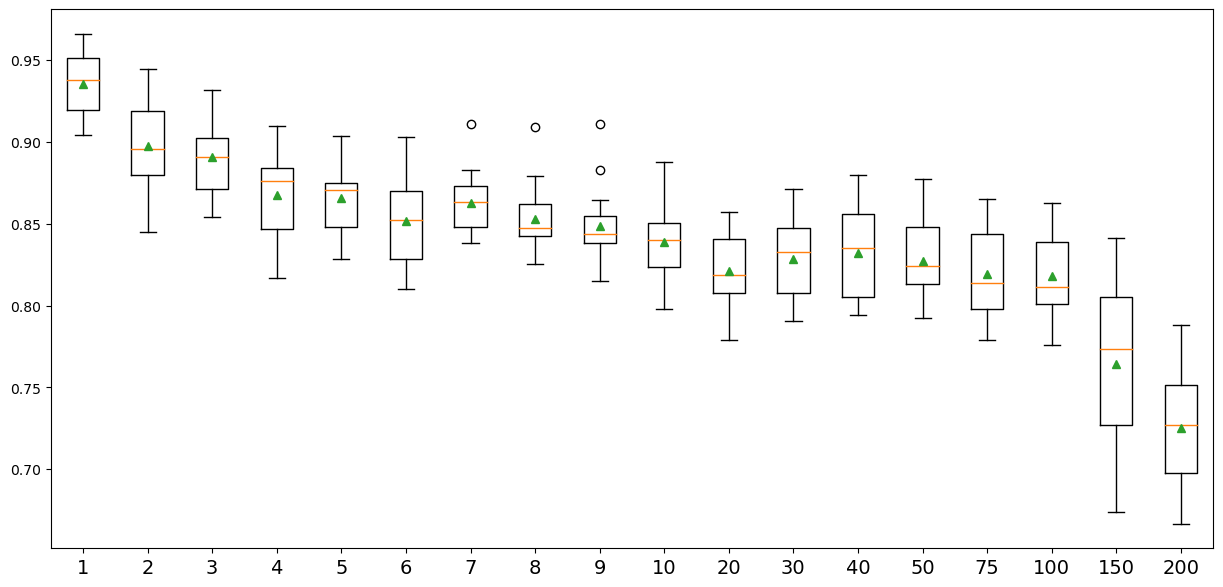

In [448]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         knn_i = KNeighborsClassifier(n_neighbors = value) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_KNN),
#                                         ('knn_i',knn_i)])     
#     return models

# models = get_models([1,2,3,4,5,6,7,8,9,10,20,30,40,50,75,100,150,200]) #default False
# return_results(models,X_train_KNN)

>uniform 0.86580 (0.02179)
>distance 0.92104 (0.02155)


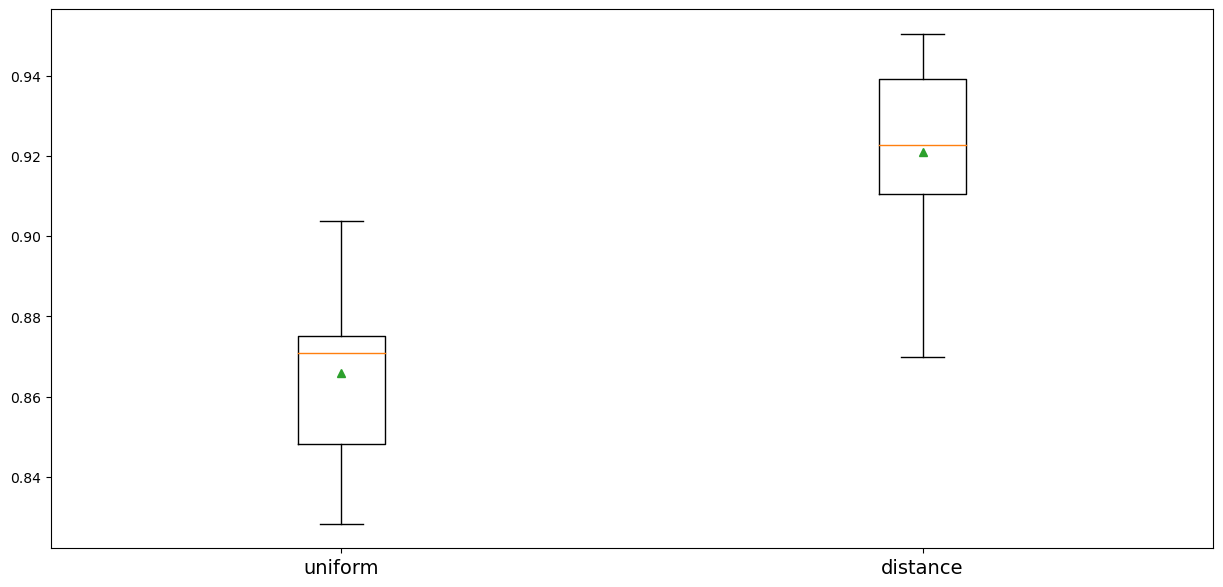

In [450]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         knn_i = KNeighborsClassifier(weights = value) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_KNN),
#                                         ('knn_i',knn_i)])     
#     return models

# models = get_models(['uniform','distance'])
# return_results(models,X_train_KNN)

>auto 0.86580 (0.02179)
>ball_tree 0.86580 (0.02179)
>kd_tree 0.86580 (0.02179)
>brute 0.86580 (0.02179)


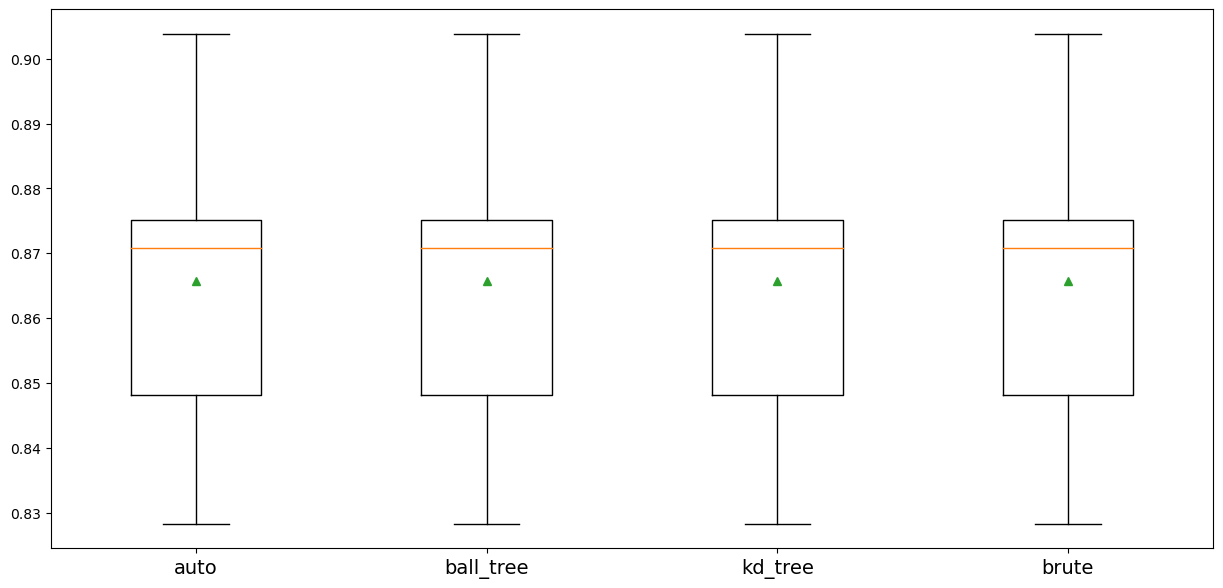

In [452]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         knn_i = KNeighborsClassifier(algorithm = value) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_KNN),
#                                         ('knn_i',knn_i)])     
#     return models

# models = get_models(['auto', 'ball_tree', 'kd_tree', 'brute'])
# return_results(models,X_train_KNN)

>1 0.86594 (0.01820)
>2 0.86580 (0.02179)
>3 0.86631 (0.02071)
>4 0.86457 (0.02018)
>5 0.86131 (0.01909)
>6 0.85905 (0.02000)
>7 0.85643 (0.02028)
>8 0.85648 (0.02041)
>9 0.85533 (0.02154)
>10 0.85527 (0.02262)


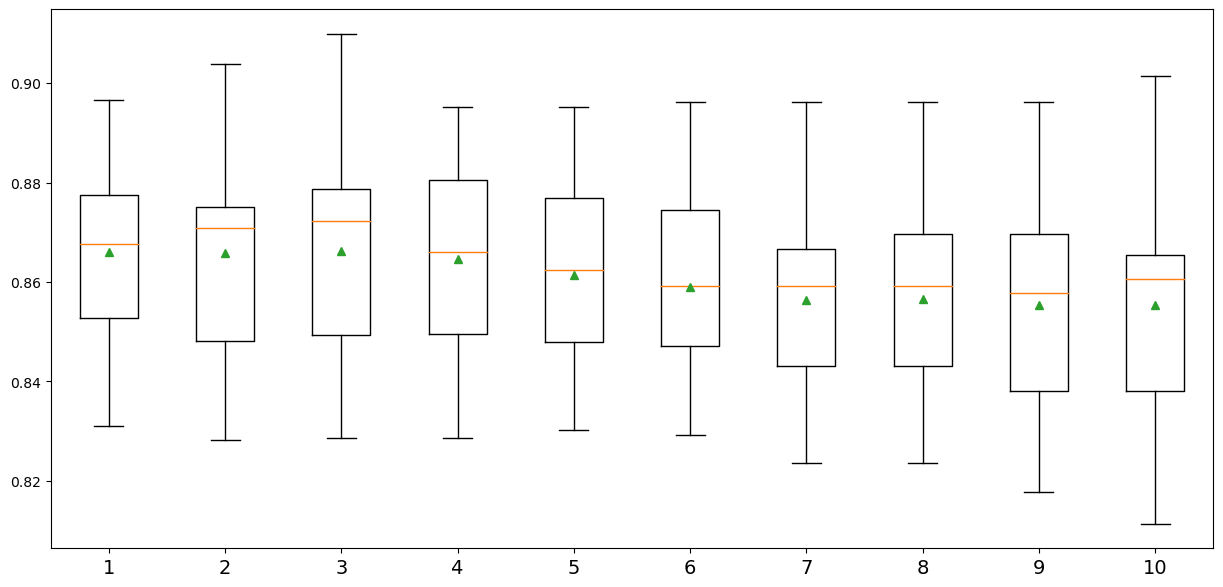

In [453]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         knn_i = KNeighborsClassifier(p= value) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_KNN),
#                                         ('knn_i',knn_i)])     
#     return models

# models = get_models([1,2,3,4,5,6,7,8,9,10])
# return_results(models,X_train_KNN)

>euclidean 0.86580 (0.02179)
>manhattan 0.86594 (0.01820)
>cosine 0.85967 (0.02494)


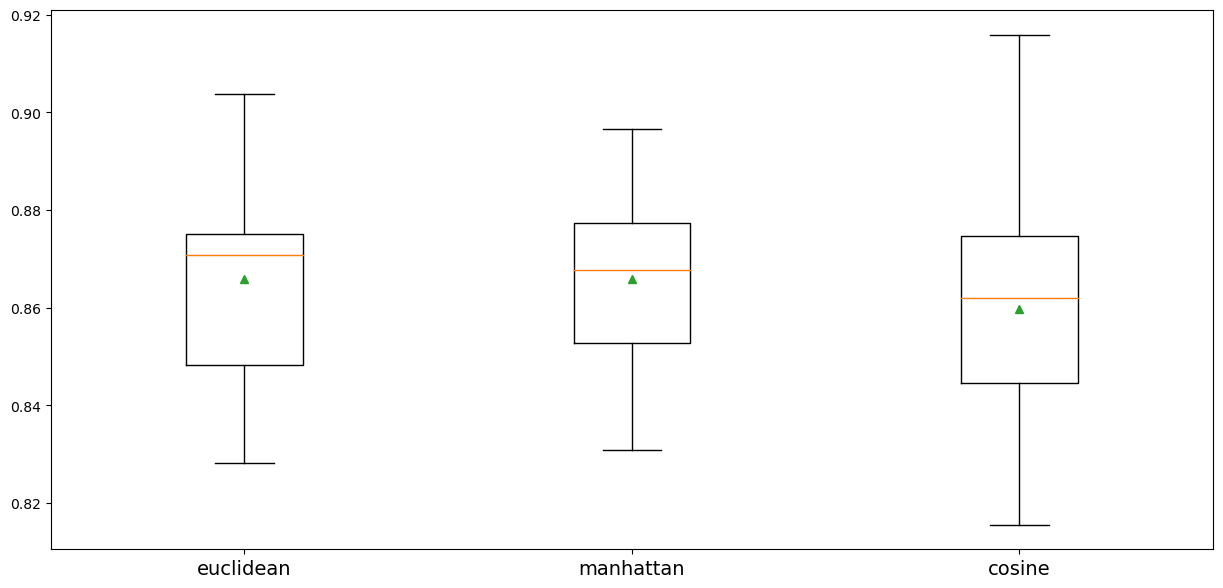

In [211]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         knn_i = KNeighborsClassifier(metric = value) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_KNN),
#                                         ('knn_i',knn_i)])     
#     return models

# models = get_models(['euclidean','manhattan','cosine'])
# return_results(models,X_train_KNN)

In [212]:
# KNN_grid_pipe = Pipeline(steps=[('preprocess',preprocessor_KNN),
#                                         ('KNN_grid',KNN_standard)])
# param_grid = { 
#     'KNN_grid__n_neighbors': [1,2,3,4,5,6,7,8,9,10],
#     'KNN_grid__weights': ['uniform','distance'],
#     'KNN_grid__metric': ['euclidean','manhattan','cosine'],
# } 

# grid_KNN = GridSearchCV(estimator=KNN_grid_pipe, param_grid=param_grid, scoring = 'f1',
#                           cv= RepeatedStratifiedKFold(n_splits=4,random_state=0,n_repeats = 5))

# grid_KNN.fit(X_train_KNN, y_train)
# grid_KNN.best_params_

{'KNN_grid__metric': 'manhattan',
 'KNN_grid__n_neighbors': 1,
 'KNN_grid__weights': 'uniform'}

Three of them gave the same result.

In [118]:
# Best_KNN_1= KNeighborsClassifier(n_neighbors=1, metric='manhattan', weights='uniform')
# pipeline_Best_KNN_1 = Pipeline(steps=[('preprocess',preprocessor_KNN),
#                                         ('KNN_1',Best_KNN_1)])
# all_scores_Best_KNN_1 = cross_val_score(pipeline_Best_KNN_1, X_train_KNN, y_train,
#                              scoring='f1', cv = rskf4)
# all_scores_Best_KNN_1.mean()

0.9645184630460435

### Repeating the feature finding as we can afford it

In [458]:
# comb_df_KNN_1 = combinations_test(X_train, sure_feat, ordinal_sure, sure_categories, sure_num,
#                       unsure_feat, unsure_categories, unsure_cat, unsure_num, Best_KNN_1, combcv)

('Birth_Year',) 0.9657126888705536
('Blood_Pressure',) 0.9680004871793463
('Mental_Health',) 0.9737122818775031
('Weight',) 0.9160840414310538
('Gender',) 0.9705005980807613
('BMI',) 0.9162122033568595
('Exercise',) 0.9719683536479244
('Height',) 0.867940617824555
('Drinking_Habit',) 0.9746013523445635
('Birth_Year', 'Blood_Pressure') 0.9634185084638945
('Birth_Year', 'Mental_Health') 0.9723877550135688
('Birth_Year', 'Weight') 0.9477478008374891
('Birth_Year', 'Gender') 0.9658996222688268
('Birth_Year', 'BMI') 0.9541972177518969
('Birth_Year', 'Exercise') 0.97120270795558
('Birth_Year', 'Height') 0.9221128646315926
('Birth_Year', 'Drinking_Habit') 0.9717847167835556
('Blood_Pressure', 'Mental_Health') 0.9725792646134386
('Blood_Pressure', 'Weight') 0.949356809836085
('Blood_Pressure', 'Gender') 0.9705464249351115
('Blood_Pressure', 'BMI') 0.9530679543218972
('Blood_Pressure', 'Exercise') 0.9697329365174081
('Blood_Pressure', 'Height') 0.9132427535956265
('Blood_Pressure', 'Drinking_Ha

In [459]:
# comb_df_KNN_1.sort_values('Score',ascending=False).head(5)

Combination     Score
102                   (Mental_Health, Gender, Drinking_Habit)  0.979999
158       (Birth_Year, Mental_Health, Gender, Drinking_Habit)  0.978796
38                                   (Gender, Drinking_Habit)  0.978021
302  (Birth_Year, Mental_Health, Gender, BMI, Drinking_Habit)  0.977485
193   (Blood_Pressure, Mental_Health, Gender, Drinking_Habit)  0.977195

#### Final Model

In [111]:
# feat_KNN_final = ['High_Cholesterol','Physical_Health', 'Fruit_Habit', 'Diabetes','Checkup_sure',
#             'Mental_Health', 'Gender','Drinking_Habit']

# X_train_KNN_final = X_train.loc[:,feat_KNN_final]

# ### Create the preprocessor
# ordinal_KNN_final = ['Fruit_Habit', 'Diabetes','Checkup_sure', 'Gender','Drinking_Habit']
# categories_KNN_final = [fruit_categories, diabetes_categories, checkup_categories, gender_categories,drink_categories]
# metric_KNN_final = ['High_Cholesterol','Physical_Health','Mental_Health']

# preprocessor_KNN_final = create_preprocessor(MinMaxScaler(),metric_KNN_final, ordinal_KNN_final, categories_KNN_final)


# pipeline_KNN_final = Pipeline(steps=[('preprocess',preprocessor_KNN_final),
#                                         ('KKN',Best_KNN_1)])

# all_scores_KNN = cross_val_score(pipeline_KNN_final, X_train_KNN_final, y_train,
#                              scoring='f1', cv = rskf4)
# all_scores_KNN.mean()

0.9759005451445407

#### Testing the model

In [128]:
# # X_test = feat_eng(test) # comment if already ran on other models

# X_test_KNN = X_test.loc[:,feat_KNN_final]

In [215]:
# pipeline_KNN_grid_fit_pointer = pipeline_KNN_final.fit(X_train_KNN_final,y_train)

In [217]:
# pred_KNN_grid = pipeline_KNN_final.predict(X_test_KNN)

# submission_KNN_grid = pd.DataFrame(pred_KNN_grid, index = X_test_KNN.index).rename(columns= {0:'Disease'})

# submission_gb_grid.to_csv('Group12_Version04.csv') #1 

## 4.6. Multi Layer Perceptron Classifier

In [131]:
# #just an auxiliary function to get the mean of a dictionary
# def get_dict_mean (dic):
    
#     return {key : float(sum(values)) / len(values) for key, values in dic.items()}

In [132]:
# mlp_default = MLPClassifier(random_state=15,max_iter=5000)

In [133]:
# pipeline_mlp_default = Pipeline(steps=[('preprocess',preprocessor),
#                                         ('mlp_default',mlp_default)])

# model_scores = cross_validate(pipeline_mlp_default, X_train_sel, y_train,
#                              scoring='f1', cv = rskf4,
#                             return_train_score=True)
# get_dict_mean(model_scores)

{'fit_time': 5.019423612952233,
 'score_time': 0.010444387793540955,
 'test_score': 0.8616878330958254,
 'train_score': 0.8870520736154454}

### 1) Searching for the best combination of features possible 

In [89]:
# skf4 = StratifiedKFold(n_splits=4, random_state=0, shuffle=True)
# mlp_default = MLPClassifier(random_state=15,max_iter=5000)
# skf4, mlp_default

(StratifiedKFold(n_splits=4, random_state=0, shuffle=True),
 MLPClassifier(max_iter=5000, random_state=15))

In [85]:
# comb_df_nn = combinations_test(X_train, sure_feat, ordinal_sure, sure_categories, sure_num,
#                       unsure_feat, unsure_categories, unsure_cat, unsure_num, mlp_default, skf4)

('Birth_Year',) 0.8712733435188823
('Blood_Pressure',) 0.8608080264907898
('Mental_Health',) 0.8704181206708402
('Weight',) 0.8621045838560697
('Gender',) 0.8754812456148368
('BMI',) 0.8714782152082967
('Exercise',) 0.8800078971611811
('Height',) 0.8591921811421522
('Drinking_Habit',) 0.8861636973487419
('Birth_Year', 'Blood_Pressure') 0.8794985421228722
('Birth_Year', 'Mental_Health') 0.8754065589339214
('Birth_Year', 'Weight') 0.887134791981251
('Birth_Year', 'Gender') 0.8930397948512561
('Birth_Year', 'BMI') 0.893074864242245
('Birth_Year', 'Exercise') 0.9084618172028893
('Birth_Year', 'Height') 0.8791417241688821
('Birth_Year', 'Drinking_Habit') 0.891846399868788
('Blood_Pressure', 'Mental_Health') 0.8703771991256177
('Blood_Pressure', 'Weight') 0.8847406308412455
('Blood_Pressure', 'Gender') 0.8712932420407664
('Blood_Pressure', 'BMI') 0.8815303210895605
('Blood_Pressure', 'Exercise') 0.8780616686960477
('Blood_Pressure', 'Height') 0.8647828127666838
('Blood_Pressure', 'Drinking_H

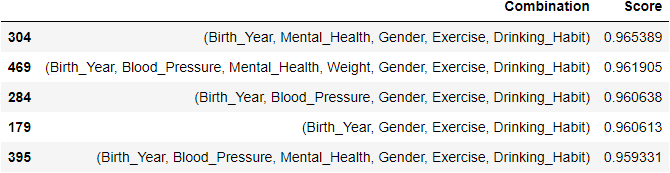

In [134]:
# feat_nn = sure_feat + ['Birth_Year', 'Mental_Health','Gender', 'Exercise', 'Drinking_Habit']

# X_train_nn = X_train.loc[:,feat_nn]

# ordinal_nn = ['Fruit_Habit', 'Diabetes','Checkup_sure', 'Exercise','Drinking_Habit', 'Gender']
# categories_nn =[fruit_categories, diabetes_categories, checkup_categories, exercise_categories, drink_categories, gender_categories]
# metric_nn = sure_num + ['Mental_Health', 'Birth_Year']

# preprocessor_nn = create_preprocessor(MinMaxScaler(),metric_nn, ordinal_nn, categories_nn)

In [135]:
# pipeline_mlp_default = Pipeline(steps=[('preprocess',preprocessor_nn),
#                                         ('mlp_default',mlp_default)])

# model_scores = cross_validate(pipeline_mlp_default, X_train_nn, y_train,
#                              scoring='f1', cv = rskf4,
#                             return_train_score=True)
# get_dict_mean(model_scores)

{'fit_time': 6.991913542151451,
 'score_time': 0.012260419130325318,
 'test_score': 0.9666813068393261,
 'train_score': 0.994596087617108}

### 2) Hyperparameter tuning

In [137]:
# #creating an auxiliary function for testing models:
# def test_models (names,cross_v,*args):
    
#     df = pd.DataFrame()
#     model_scores = []
    
#     for i in range (len(args)):
        
#         pipe_mlp = Pipeline(steps=[('preprocess',preprocessor_nn),
#                                         ('model',args[i])])
        
#         model_scores = cross_validate(pipe_mlp, X_train_nn, y_train,
#                              scoring='f1', cv = cross_v,
#                             return_train_score=True)
        
#         model_score_mean = get_dict_mean(model_scores)
        
#         print(args[i]) #this is just to check the progress
        
#         df_temp = pd.DataFrame(model_score_mean,index=[names[i]])
        
#         df = pd.concat([df_temp,df], axis=0)

#     return df

In [138]:
# rskf4_2 = RepeatedStratifiedKFold(n_splits=4, random_state=0, n_repeats = 2)

- number of neurons (hidden layer size = 1)

In [76]:
# mlp_5 = MLPClassifier(hidden_layer_sizes=(5),random_state=15, max_iter=5000)
# mlp_10 = MLPClassifier(hidden_layer_sizes=(10),random_state=15, max_iter=5000)
# mlp_15 = MLPClassifier(hidden_layer_sizes=(15),random_state=15, max_iter=5000)
# mlp_20 = MLPClassifier(hidden_layer_sizes=(20),random_state=15, max_iter=5000)
# mlp_40 = MLPClassifier(hidden_layer_sizes=(40),random_state=15, max_iter=5000)
# mlp_60 = MLPClassifier(hidden_layer_sizes=(60),random_state=15, max_iter=5000)
# mlp_80 = MLPClassifier(hidden_layer_sizes=(80),random_state=15, max_iter=5000)

# mlp_150 = MLPClassifier(hidden_layer_sizes=(150),random_state=15, max_iter=5000)

# models_1 = test_models(['(150)','(100,)','(80,)','(60,)', '(40,)', '(20,)', '(15,)', '(10,)', '(5,)'],
#                        rskf4_2,
#                        mlp_150, mlp_default,mlp_80,mlp_60, mlp_40, mlp_20,mlp_15, mlp_10, mlp_5)

# models_1['Overfitting'] = models_1['train_score'] - models_1['test_score']

# #models_ = pd.concat([models_1]).sort_values(by=['test_score'],ascending=False)
# models_1.sort_values(by=['test_score'],ascending=False)



MLPClassifier(hidden_layer_sizes=150, max_iter=5000, random_state=15)
MLPClassifier(max_iter=5000, random_state=15)
MLPClassifier(hidden_layer_sizes=80, max_iter=5000, random_state=15)
MLPClassifier(hidden_layer_sizes=60, max_iter=5000, random_state=15)
MLPClassifier(hidden_layer_sizes=40, max_iter=5000, random_state=15)
MLPClassifier(hidden_layer_sizes=20, max_iter=5000, random_state=15)
MLPClassifier(hidden_layer_sizes=15, max_iter=5000, random_state=15)
MLPClassifier(hidden_layer_sizes=10, max_iter=5000, random_state=15)
MLPClassifier(hidden_layer_sizes=5, max_iter=5000, random_state=15)


fit_time  score_time  test_score  train_score  Overfitting
(150)   8.023257    0.012352    0.970622     0.995348     0.024726
(100,)  7.300690    0.014128    0.970574     0.994729     0.024156
(80,)   6.312880    0.012804    0.966909     0.993312     0.026402
(60,)   6.138644    0.011149    0.961403     0.990892     0.029489
(40,)   7.175654    0.012869    0.942606     0.979929     0.037323
(20,)   5.223956    0.012252    0.899146     0.943902     0.044756
(15,)   5.094950    0.013249    0.892140     0.925169     0.033029
(10,)   2.153803    0.012913    0.860529     0.884706     0.024177
(5,)    1.443459    0.012781    0.849589     0.852707     0.003118

[]

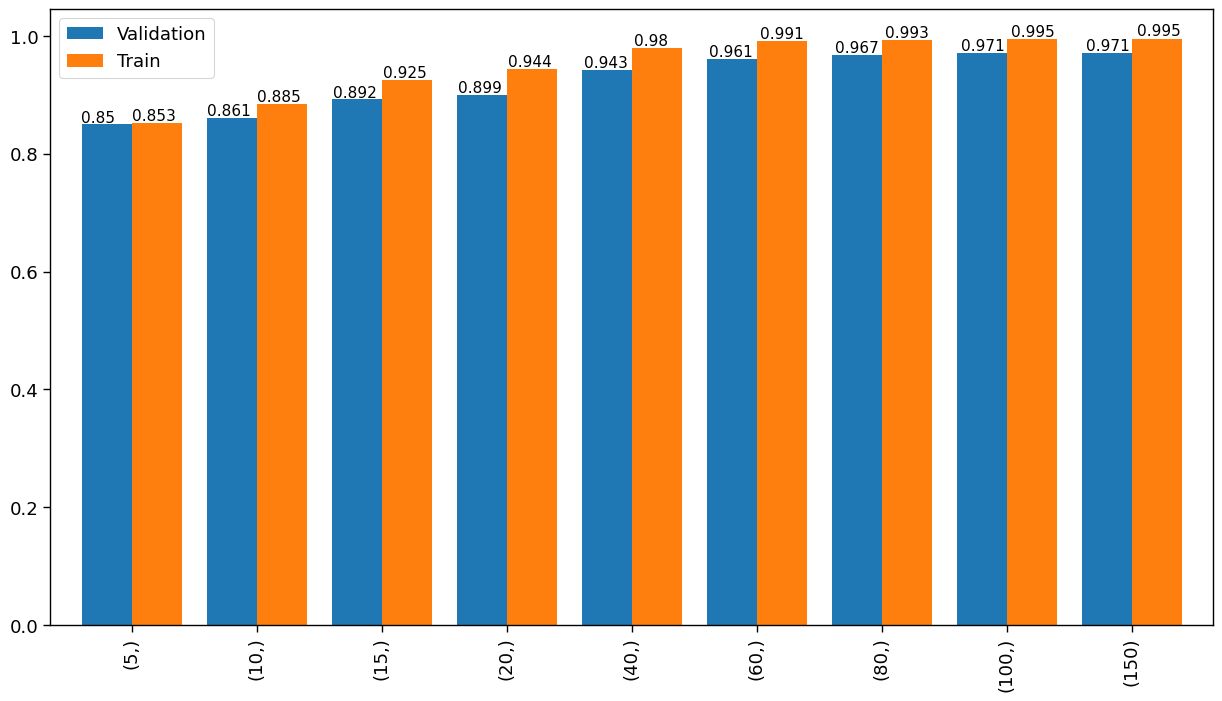

In [131]:
# ax = models_1[['test_score', 'train_score']].plot(kind='bar',legend=False, width=0.8,figsize=(15, 8), fontsize=13)

# for p in ax.patches:
#     ax.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005), fontsize=11)

# plt.legend(['Validation', 'Train'], loc ='best',fontsize=13)
# plt.plot()

- number of neurons (hidden layer size = 2)

In [86]:
# mlp_5_5 = MLPClassifier(hidden_layer_sizes=(5, 5),random_state=15, max_iter=5000)
# mlp_10_10 = MLPClassifier(hidden_layer_sizes=(10, 10),random_state=15, max_iter=5000)
# mlp_15_15 = MLPClassifier(hidden_layer_sizes=(15, 15),random_state=15, max_iter=5000)
# mlp_20_20 = MLPClassifier(hidden_layer_sizes=(20, 20),random_state=15, max_iter=5000) 
# mlp_25_25 = MLPClassifier(hidden_layer_sizes=(25, 25),random_state=15, max_iter=5000) 
# mlp_30_30 = MLPClassifier(hidden_layer_sizes=(30, 30),random_state=15, max_iter=5000) 

# models_11 = test_models(['(5,5)','(10,10)', '(15,15)', '(20,20)','(25,25)', '(30,30)'], rskf4_2,
#                        mlp_5_5, mlp_10_10, mlp_15_15, mlp_20_20, mlp_30_30)

# models_11['Overfitting'] = models_11['train_score'] - models_11['test_score']
# models_11.sort_values(by=['test_score'],ascending=False)

MLPClassifier(hidden_layer_sizes=(5, 5), max_iter=5000, random_state=15)
MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=5000, random_state=15)
MLPClassifier(hidden_layer_sizes=(15, 15), max_iter=5000, random_state=15)
MLPClassifier(hidden_layer_sizes=(20, 20), max_iter=5000, random_state=15)
MLPClassifier(hidden_layer_sizes=(30, 30), max_iter=5000, random_state=15)


fit_time  score_time  test_score  train_score  Overfitting
(25,25)  5.171391    0.013130    0.971044     0.997568     0.026523
(20,20)  6.170166    0.014702    0.960020     0.989879     0.029859
(10,10)  8.632274    0.013603    0.954203     0.986124     0.031921
(15,15)  6.775798    0.012386    0.948030     0.976548     0.028518
(5,5)    1.837672    0.010965    0.845696     0.867034     0.021338

[]

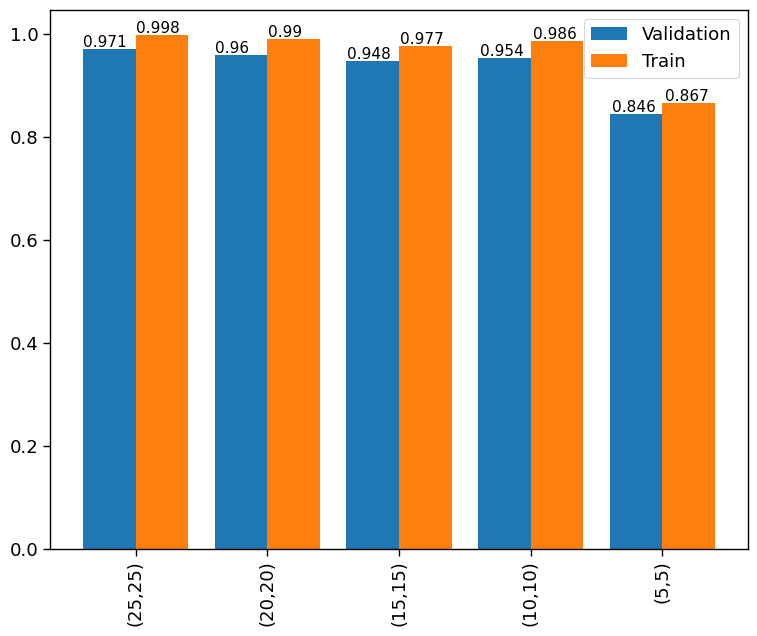

In [89]:
# ax = models_11[['test_score', 'train_score']].plot(kind='bar',legend=False, width=0.8,figsize=(9, 7), fontsize=13)

# for p in ax.patches:
#     ax.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005), fontsize=11)

# plt.legend(['Validation', 'Train'], loc ='best',fontsize=13)
# plt.plot()

In [76]:
# mlp_5_20 = MLPClassifier(hidden_layer_sizes=(5, 20),random_state=15, max_iter=5000) 
# mlp_5_25 = MLPClassifier(hidden_layer_sizes=(5,25),random_state=15, max_iter=5000)
# mlp_20_25 = MLPClassifier(hidden_layer_sizes=(20,25),random_state=15, max_iter=5000)
# mlp_25_5 = MLPClassifier(hidden_layer_sizes=(25, 5),random_state=15, max_iter=5000) 
# mlp_25_20 = MLPClassifier(hidden_layer_sizes=(25, 20),random_state=15, max_iter=5000) 
# mlp_20_5 = MLPClassifier(hidden_layer_sizes=(20, 5),random_state=15, max_iter=5000) 

# models_12 = test_models(['(5,20)','(5,25)','(20,25)','(20,5)','(25,20)', '(25,5)'], rskf4_2,
#                        mlp_5_20, mlp_5_25, mlp_20_25, mlp_20_5, mlp_25_20, mlp_25_5)

# models_12['Overfitting'] = models_12['train_score'] - models_12['test_score']
# models_12.sort_values(by=['test_score'],ascending=False)


MLPClassifier(hidden_layer_sizes=(5, 20), max_iter=5000, random_state=15)
MLPClassifier(hidden_layer_sizes=(5, 25), max_iter=5000, random_state=15)
MLPClassifier(hidden_layer_sizes=(20, 25), max_iter=5000, random_state=15)
MLPClassifier(hidden_layer_sizes=(20, 5), max_iter=5000, random_state=15)
MLPClassifier(hidden_layer_sizes=(25, 20), max_iter=5000, random_state=15)
MLPClassifier(hidden_layer_sizes=(25, 5), max_iter=5000, random_state=15)


fit_time  score_time  test_score  train_score  Overfitting
(25,20)  4.994804    0.012397    0.975308     0.998379     0.023071
(20,25)  5.100155    0.010925    0.969111     0.996151     0.027041
(25,5)   5.404807    0.012196    0.964840     0.992318     0.027478
(20,5)   7.126921    0.011220    0.955186     0.991095     0.035909
(5,25)   3.762754    0.013312    0.862734     0.885434     0.022700
(5,20)   3.523791    0.013115    0.856332     0.901004     0.044672

[]

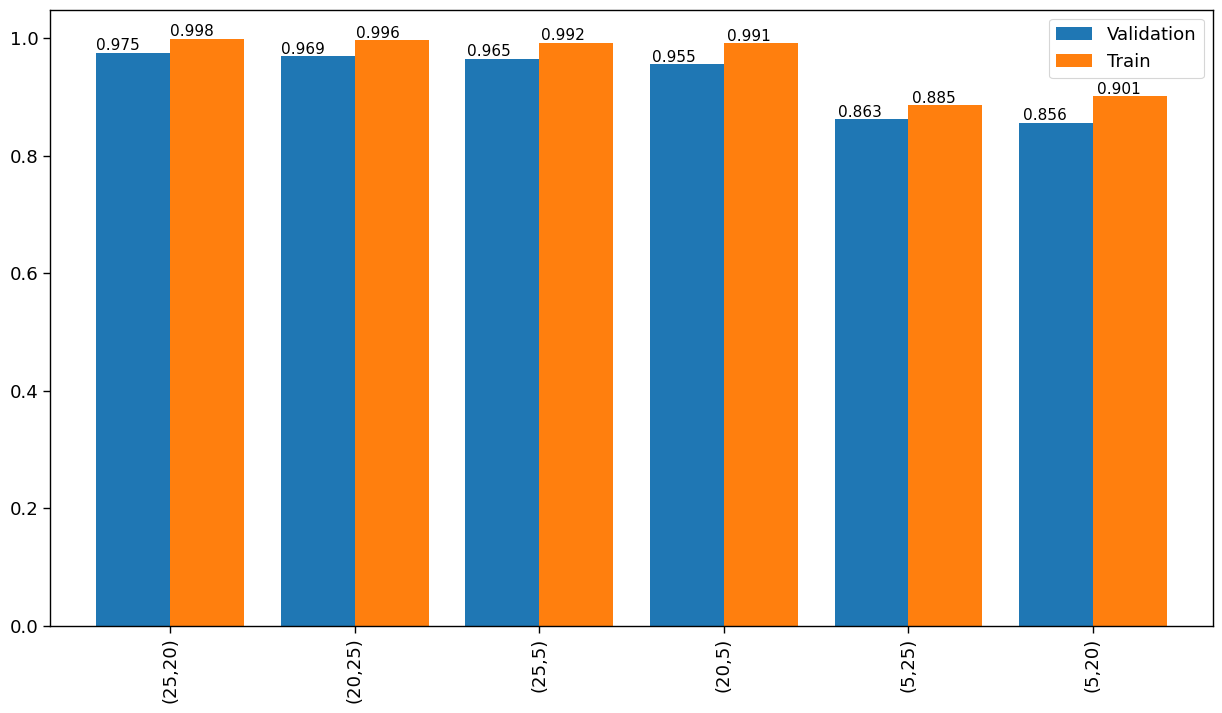

In [78]:
# ax = models_12[['test_score', 'train_score']].sort_values(by=['test_score'],ascending=False).plot(kind='bar',legend=False, width=0.8,figsize=(15, 8), fontsize=13)

# for p in ax.patches:
#     ax.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005), fontsize=11)

# plt.legend(['Validation', 'Train'], loc ='best',fontsize=13)
# plt.plot()

- learning rate:

In [88]:
# mlp_lr1 = MLPClassifier(learning_rate_init=0.1,random_state=15, max_iter=5000)
# mlp_lr2 = MLPClassifier(learning_rate_init=0.5,random_state=15, max_iter=5000)
# mlp_lr3 = MLPClassifier(learning_rate_init=0.01,random_state=15, max_iter=5000)

# models_lr = test_models(['0.1','0.5', '0.01', '0.001'],rskf4_2,mlp_lr1,mlp_lr2, mlp_lr3, mlp_default)
# models_lr['Overfitting'] = models_lr['train_score'] - models_lr['test_score']
# models_lr.sort_values(by=['test_score'],ascending=False)

MLPClassifier(learning_rate_init=0.1, max_iter=5000, random_state=15)
MLPClassifier(learning_rate_init=0.5, max_iter=5000, random_state=15)
MLPClassifier(learning_rate_init=0.01, max_iter=5000, random_state=15)
MLPClassifier(max_iter=5000, random_state=15)


fit_time  score_time  test_score  train_score  Overfitting
0.01   2.666261    0.013595    0.983386     1.000000     0.016614
0.001  8.153409    0.014329    0.970574     0.994729     0.024156
0.1    0.588430    0.013249    0.950867     0.978645     0.027778
0.5    0.438089    0.014151    0.857038     0.870536     0.013498

[]

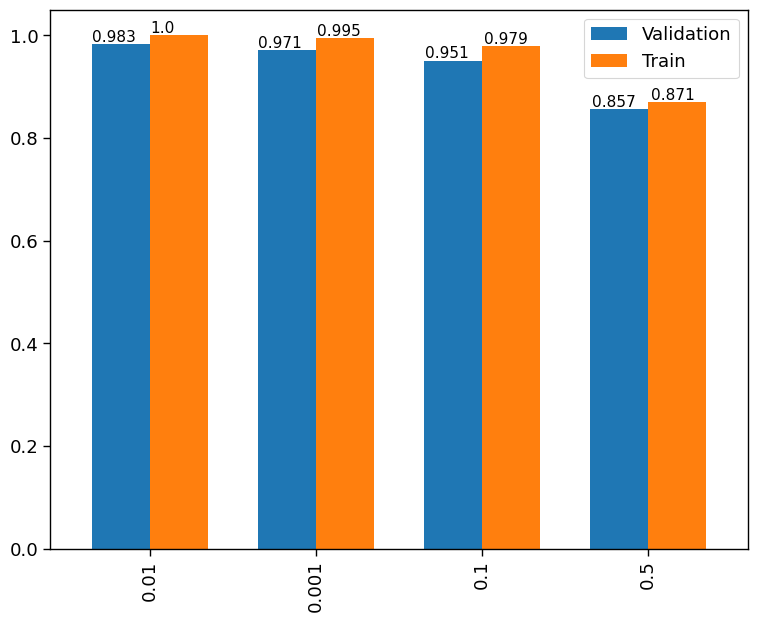

In [99]:
# ax = models_lr[['test_score', 'train_score']].sort_values(by=['test_score'],ascending=False).plot(kind='bar',legend=False, width=0.7,figsize=(9, 7), fontsize=13)

# for p in ax.patches:
#     ax.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005), fontsize=11)

# plt.legend(['Validation', 'Train'], loc ='best',fontsize=13)
# plt.plot()

- solver:

In [100]:
# mlp_lbfgs = MLPClassifier(solver = 'lbfgs',random_state=15, max_iter=5000)
# mlp_sgd = MLPClassifier(solver = 'sgd',random_state=15, max_iter=5000)

# models_solver = test_models(['lbfgs','adam', 'sgd'],rskf4_2, mlp_lbfgs, mlp_default, mlp_sgd)

# models_solver['Overfitting'] = models_solver['train_score'] - models_solver['test_score']
# models_solver.sort_values(by=['test_score'],ascending=False)

MLPClassifier(max_iter=5000, random_state=15, solver='lbfgs')
MLPClassifier(max_iter=5000, random_state=15)
MLPClassifier(max_iter=5000, random_state=15, solver='sgd')


fit_time  score_time  test_score  train_score  Overfitting
lbfgs  0.682302    0.010388    0.982726     1.000000     0.017274
adam   6.984666    0.011887    0.970574     0.994729     0.024156
sgd    1.878144    0.011922    0.833801     0.836053     0.002253

[]

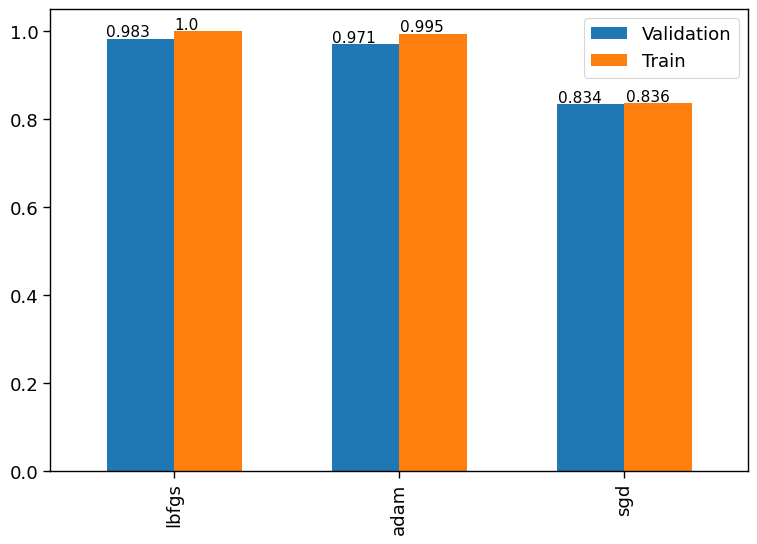

In [103]:
# ax = models_solver[['test_score', 'train_score']].sort_values(by=['test_score'],ascending=False).plot(kind='bar',legend=False, width=0.6,figsize=(9, 6), fontsize=13)

# for p in ax.patches:
#     ax.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005), fontsize=11)

# plt.legend(['Validation', 'Train'], loc ='best',fontsize=13)
# plt.plot()

- activation:

In [104]:
# mlp_tanh = MLPClassifier(activation='tanh', random_state=15, max_iter=5000)
# mlp_log = MLPClassifier(activation='logistic', random_state=15, max_iter=5000)
# mlp_relu = MLPClassifier(activation='relu', random_state=15, max_iter=5000)


# models_act = test_models(['tanh','logistic', 'relu'],
#                             rskf4_2, mlp_tanh, mlp_log, mlp_relu)

# models_act['Overfitting'] = models_act['train_score'] - models_act['test_score']
# models_act.sort_values(by=['test_score'],ascending=False)

MLPClassifier(activation='tanh', learning_rate_init=0.01, max_iter=5000,
              random_state=15)
MLPClassifier(activation='logistic', learning_rate_init=0.01, max_iter=5000,
              random_state=15)
MLPClassifier(learning_rate_init=0.01, max_iter=5000, random_state=15)


fit_time  score_time  test_score  train_score  Overfitting
relu      2.399683    0.014458    0.983386     1.000000     0.016614
tanh      3.884806    0.013729    0.981539     0.999798     0.018259
logistic  5.280189    0.012822    0.962859     0.985574     0.022715

[]

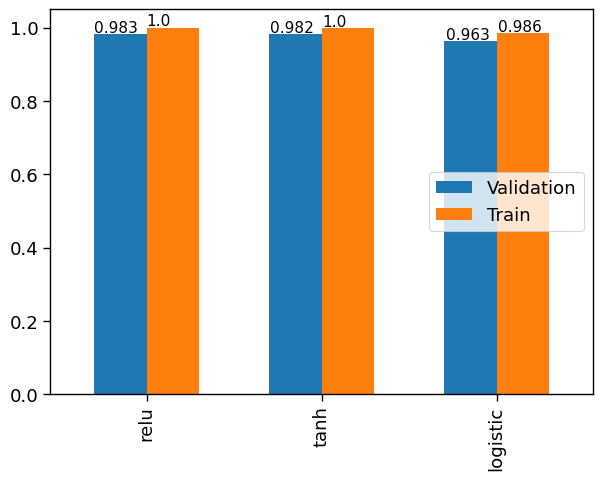

In [124]:
# ax = models_act[['test_score', 'train_score']].sort_values(by=['test_score'],ascending=False).plot(kind='bar',legend=False, width=0.6,figsize=(7, 5), fontsize=13)

# for p in ax.patches:
#     ax.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005), fontsize=11)

# plt.legend(['Validation', 'Train'], loc ='center right',fontsize=13)
# plt.plot()

- __RANDOM SEARCH__

In [139]:
# param_grid_nn_lbfgs = { 
#     'model__hidden_layer_sizes': [100, (25,25), (25,20)],
#     'model__solver': ['lbfgs'],
#     'model__activation' :['relu', 'tanh']
# }

# nn_grid_pipe = Pipeline(steps=[('preprocess',preprocessor_nn),
#                                         ('model',mlp_default)])

# ## Let's do 5 Random searches to be more sure of the parameters we get
# param_listnn_lbfgs = []
# for search in range(5):
#     CV_nn_lbfgs = RandomizedSearchCV(estimator=nn_grid_pipe, param_distributions=param_grid_nn_lbfgs, scoring = 'f1',
#                           cv= RepeatedStratifiedKFold(n_splits=4,random_state=0,n_repeats = 2))

#     CV_nn_lbfgs.fit(X_train_nn, y_train)
    
#     param_listnn_lbfgs.append(CV_nn_lbfgs.best_params_)

In [140]:
# param_listnn_lbfgs

[{'model__solver': 'lbfgs',
  'model__hidden_layer_sizes': 100,
  'model__activation': 'relu'},
 {'model__solver': 'lbfgs',
  'model__hidden_layer_sizes': 100,
  'model__activation': 'relu'},
 {'model__solver': 'lbfgs',
  'model__hidden_layer_sizes': 100,
  'model__activation': 'relu'},
 {'model__solver': 'lbfgs',
  'model__hidden_layer_sizes': 100,
  'model__activation': 'relu'},
 {'model__solver': 'lbfgs',
  'model__hidden_layer_sizes': 100,
  'model__activation': 'relu'}]

In [156]:
# param_grid_nn_adam = { 
#     'model__hidden_layer_sizes': [100, (25,25), (25,20)],
#     'model__solver': ['adam'],
#     'model__activation' :['relu', 'tanh'],
#     'model__learning_rate_init': [0.01,0.001]
# }

# param_listnn_adam = []
# for search in range(5):
#     CV_nn_adam = RandomizedSearchCV(estimator=nn_grid_pipe, param_distributions=param_grid_nn_adam, scoring = 'f1',
#                           cv= RepeatedStratifiedKFold(n_splits=4,random_state=0,n_repeats = 2))

#     CV_nn_adam.fit(X_train_nn, y_train)
    
#     param_listnn_adam.append(CV_nn_adam.best_params_)



In [157]:
# param_listnn_adam

[{'model__solver': 'adam',
  'model__learning_rate_init': 0.01,
  'model__hidden_layer_sizes': (25, 25),
  'model__activation': 'relu'},
 {'model__solver': 'adam',
  'model__learning_rate_init': 0.01,
  'model__hidden_layer_sizes': (25, 25),
  'model__activation': 'relu'},
 {'model__solver': 'adam',
  'model__learning_rate_init': 0.01,
  'model__hidden_layer_sizes': (25, 25),
  'model__activation': 'relu'},
 {'model__solver': 'adam',
  'model__learning_rate_init': 0.01,
  'model__hidden_layer_sizes': (25, 25),
  'model__activation': 'relu'},
 {'model__solver': 'adam',
  'model__learning_rate_init': 0.01,
  'model__hidden_layer_sizes': (25, 25),
  'model__activation': 'relu'}]

In [164]:
# param_grid_nn_sgd = { 
#     'model__hidden_layer_sizes': [100, (25,25), (25,20)],
#     'model__solver': ['sgd'],
#     'model__activation' :['relu', 'tanh'],
#     'model__learning_rate_init': [0.01,0.001],
#     'model__learning_rate': ['adaptive', 'constant'],
#     'model__momentum': [0.95,0.99,0.995]
# }

# param_listnn_sgd = []
# for search in range(5):
#     CV_nn_sgd = RandomizedSearchCV(estimator=nn_grid_pipe, param_distributions=param_grid_nn_sgd, scoring = 'f1',
#                           cv= RepeatedStratifiedKFold(n_splits=4,random_state=0,n_repeats = 2))

#     CV_nn_sgd.fit(X_train_nn, y_train)
    
#     param_listnn_sgd.append(CV_nn_sgd.best_params_)



In [165]:
# param_listnn_sgd

[{'model__solver': 'sgd',
  'model__momentum': 0.99,
  'model__learning_rate_init': 0.01,
  'model__learning_rate': 'adaptive',
  'model__hidden_layer_sizes': (25, 20),
  'model__activation': 'tanh'},
 {'model__solver': 'sgd',
  'model__momentum': 0.99,
  'model__learning_rate_init': 0.01,
  'model__learning_rate': 'adaptive',
  'model__hidden_layer_sizes': 100,
  'model__activation': 'relu'},
 {'model__solver': 'sgd',
  'model__momentum': 0.995,
  'model__learning_rate_init': 0.01,
  'model__learning_rate': 'constant',
  'model__hidden_layer_sizes': (25, 20),
  'model__activation': 'relu'},
 {'model__solver': 'sgd',
  'model__momentum': 0.95,
  'model__learning_rate_init': 0.01,
  'model__learning_rate': 'adaptive',
  'model__hidden_layer_sizes': (25, 25),
  'model__activation': 'relu'},
 {'model__solver': 'sgd',
  'model__momentum': 0.99,
  'model__learning_rate_init': 0.01,
  'model__learning_rate': 'constant',
  'model__hidden_layer_sizes': (25, 20),
  'model__activation': 'tanh'}]

In [178]:

# param_grid_nn_sgd_2 = { 
#     'model__hidden_layer_sizes': [100, (25,25), (25,20)],
#     'model__solver': ['sgd'],
#     'model__activation' :['relu', 'tanh'],
#     'model__learning_rate_init': [0.01],
#     'model__learning_rate': ['adaptive', 'constant'],
#     'model__momentum': [0.95,0.99,0.995]
# }

    

# grid_nn = GridSearchCV(estimator=nn_grid_pipe, param_grid=param_grid_nn_sgd_2, scoring = 'f1',
#                           cv= StratifiedKFold(n_splits=4, random_state=0, shuffle=True))

# grid_nn.fit(X_train_nn, y_train)

Fitting 4 folds for each of 36 candidates, totalling 144 fits
[CV] END model__activation=relu, model__hidden_layer_sizes=100, model__learning_rate=adaptive, model__learning_rate_init=0.01, model__momentum=0.95, model__solver=sgd; total time=   6.6s
[CV] END model__activation=relu, model__hidden_layer_sizes=100, model__learning_rate=adaptive, model__learning_rate_init=0.01, model__momentum=0.95, model__solver=sgd; total time=   5.4s
[CV] END model__activation=relu, model__hidden_layer_sizes=100, model__learning_rate=adaptive, model__learning_rate_init=0.01, model__momentum=0.95, model__solver=sgd; total time=   6.4s
[CV] END model__activation=relu, model__hidden_layer_sizes=100, model__learning_rate=adaptive, model__learning_rate_init=0.01, model__momentum=0.95, model__solver=sgd; total time=   7.9s
[CV] END model__activation=relu, model__hidden_layer_sizes=100, model__learning_rate=adaptive, model__learning_rate_init=0.01, model__momentum=0.99, model__solver=sgd; total time=   3.5s
[CV

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['High_Cholesterol',
                                                                          'Physical_Health',
                                                                          'Mental_Health',
                                                                          'Birth_Year']),
                                                                        ('cat',
                                                                         OrdinalEncoder(categories=[['Less '
                                                                                                     'than '
                                                                                                     '1. '
                                                                                                     'I '
                                                                                                     'do '
                                                                                                     'not '
                                                                                                     'consume '
                                                                                                     'fruits '
                                                                                                     'every '
                                                                                                     'day.',
                                                                                                     '1 '
                                                                                                     'to '
                                                                                                     '2 '
                                                                                                     'pieces '
                                                                                                     'of...
                                                                          'Gender'])])),
                                       ('model',
                                        MLPClassifier(max_iter=5000,
                                                      random_state=15))]),
             param_grid={'model__activation': ['relu', 'tanh'],
                         'model__hidden_layer_sizes': [100, (25, 25), (25, 20)],
                         'model__learning_rate': ['adaptive', 'constant'],
                         'model__learning_rate_init': [0.01],
                         'model__momentum': [0.95, 0.99, 0.995],
                         'model__solver': ['sgd']},
             return_train_score=True, scoring='f1', verbose=2)

In [177]:
# grid_nn.best_params_

{'model__activation': 'tanh',
 'model__hidden_layer_sizes': (25, 20),
 'model__learning_rate': 'adaptive',
 'model__learning_rate_init': 0.01,
 'model__momentum': 0.99,
 'model__solver': 'sgd'}

In [139]:
# best_lbfgs = MLPClassifier(random_state=15, max_iter=5000, solver='lbfgs', hidden_layer_sizes = (100,), activation = 'relu')
# best_adam = MLPClassifier(random_state=15, max_iter=5000, learning_rate_init=0.01, hidden_layer_sizes =(25,25), activation = 'relu')
# best_sgd = MLPClassifier(random_state=15, max_iter=5000, learning_rate_init=0.01,learning_rate='adaptive',
#                          hidden_layer_sizes =(25,20), activation = 'relu', momentum=0.99)

# models_best = test_models(['lbfgs','adam', 'sgd'],
#                             rskf4, best_lbfgs, best_adam, best_sgd)

# models_best['Overfitting'] = models_best['train_score'] - models_best['test_score']
# models_best.sort_values(by=['test_score'],ascending=False)



MLPClassifier(max_iter=5000, random_state=15, solver='lbfgs')
MLPClassifier(hidden_layer_sizes=(25, 25), learning_rate_init=0.01,
              max_iter=5000, random_state=15)
MLPClassifier(hidden_layer_sizes=(25, 20), learning_rate='adaptive',
              learning_rate_init=0.01, max_iter=5000, momentum=0.99,
              random_state=15)


fit_time  score_time  test_score  train_score  Overfitting
adam   0.990819    0.011906    0.976572     0.998353     0.021781
lbfgs  0.786683    0.012371    0.975337     1.000000     0.024663
sgd    1.138081    0.012812    0.970526     0.995406     0.024880

In [122]:
#pipeline_adam = Pipeline(steps=[('preprocess',preprocessor_nn),
                                        #('adam',best_adam)])

#all_scores_nn = cross_val_score(pipeline_adam, X_train_nn, y_train,
                             #scoring='f1', cv = rskf4)
#all_scores_nn.mean()

0.9765717345040319

#### Testing the model

In [140]:
# pipeline_nn_final = Pipeline(steps=[('preprocess',preprocessor_nn),
#                                         ('nn',best_adam)])

In [141]:
# # X_test = feat_eng(test) # comment if already ran on other models

# X_test_nn = X_test.loc[:,feat_nn]

In [142]:
# pipeline_nn_fit_pointer = pipeline_nn_final.fit(X_train_nn,y_train)

In [220]:
# pred_nn_final = pipeline_nn_final.predict(X_test_nn)

# submission_nn_final = pd.DataFrame(pred_nn_final, index = X_test_nn.index).rename(columns= {0:'Disease'})

# submission_nn_final.to_csv('Group12_Version06.csv') #1 

## 4.7. Bagging Classifier

In [144]:
# Bagging_standard = BaggingClassifier(random_state=15)

# pipeline_Bagging_standard = Pipeline(steps=[('preprocess',preprocessor),
#                                         ('Bagging_standard',Bagging_standard)])
    
# all_scores = cross_val_score(pipeline_Bagging_standard, X_train_sel, y_train,
#                              scoring='f1', cv = rskf4)

In [145]:
# all_scores.mean()

0.9606453976223028

In [146]:
# Bagging_standard_KNN = BaggingClassifier(KNeighborsClassifier(),random_state=15)

# pipeline_Bagging_standard_KNN = Pipeline(steps=[('preprocess',preprocessor),
#                                         ('Bagging_standard',Bagging_standard_KNN)])
    
# all_scores = cross_val_score(pipeline_Bagging_standard_KNN, X_train_sel, y_train,
#                              scoring='f1', cv = rskf4)

In [147]:
# all_scores.mean()

0.8407350586051383

In [148]:
# Bagging_standard_Best_KNN = BaggingClassifier(KNeighborsClassifier(n_neighbors=1, metric='manhattan', weights='uniform'),random_state=15)

# pipeline_Bagging_standard_Best_KNN = Pipeline(steps=[('preprocess',preprocessor),
#                                         ('Bagging_standard',Bagging_standard_Best_KNN)])
    
# all_scores = cross_val_score(pipeline_Bagging_standard_Best_KNN, X_train_sel, y_train,
#                              scoring='f1', cv = rskf4)

In [149]:
# all_scores.mean()

0.9508010574059707

### 1) Searching for the best combination of features possible 

In [72]:
# comb_df_Bagging = combinations_test(X_train, sure_feat, ordinal_sure, sure_categories, sure_num,
#                       unsure_feat, unsure_categories, unsure_cat, unsure_num, Bagging_standard, combcv)

('Birth_Year',) 0.9668506776561093
('Blood_Pressure',) 0.9680302500613134
('Mental_Health',) 0.9660845672042495
('Weight',) 0.9260517739441454
('Gender',) 0.9606772032553386
('BMI',) 0.9237249455942299
('Exercise',) 0.9642031913229887
('Height',) 0.9291755272807061
('Drinking_Habit',) 0.9620927018531489
('Birth_Year', 'Blood_Pressure') 0.9654810291932968
('Birth_Year', 'Mental_Health') 0.9686077258741344
('Birth_Year', 'Weight') 0.9361923914503605
('Birth_Year', 'Gender') 0.9663742094007265
('Birth_Year', 'BMI') 0.9365720168113384
('Birth_Year', 'Exercise') 0.9659348587870259
('Birth_Year', 'Height') 0.9470452891177457
('Birth_Year', 'Drinking_Habit') 0.9692845207610686
('Blood_Pressure', 'Mental_Health') 0.9626058771688945
('Blood_Pressure', 'Weight') 0.9465647695013457
('Blood_Pressure', 'Gender') 0.9689843007083925
('Blood_Pressure', 'BMI') 0.9430567549307378
('Blood_Pressure', 'Exercise') 0.9674451154714137
('Blood_Pressure', 'Height') 0.9465911423048258
('Blood_Pressure', 'Drinkin

In [73]:
# comb_df_Bagging.sort_values('Score',ascending=False).head(5)

Combination     Score
304  (Birth_Year, Mental_Health, Gender, Exercise, Drinking_Habit)  0.972619
158            (Birth_Year, Mental_Health, Gender, Drinking_Habit)  0.972336
179                 (Birth_Year, Gender, Exercise, Drinking_Habit)  0.971489
156                  (Birth_Year, Mental_Health, Gender, Exercise)  0.971424
261  (Birth_Year, Blood_Pressure, Mental_Health, Gender, Exercise)  0.970618

In [150]:
# feat_Bagging = ['High_Cholesterol','Physical_Health', 'Fruit_Habit', 'Diabetes','Checkup_sure','Birth_Year',
#             'Mental_Health', 'Gender','Exercise','Drinking_Habit']

# X_train_Bagging = X_train.loc[:,feat_Bagging]


# ordinal_Bagging = ['Fruit_Habit', 'Diabetes','Checkup_sure', 'Gender','Exercise','Drinking_Habit']
# categories_Bagging = [fruit_categories, diabetes_categories, checkup_categories, gender_categories,exercise_categories,drink_categories]
# metric_Bagging = ['High_Cholesterol','Physical_Health','Birth_Year','Mental_Health']

# preprocessor_Bagging= create_preprocessor(MinMaxScaler(),metric_Bagging, ordinal_Bagging, categories_Bagging)


# pipeline_Bagging = Pipeline(steps=[('preprocess',preprocessor_Bagging),
#                                         ('Bagging_standard',Bagging_standard)])

# all_scores = cross_val_score(pipeline_Bagging, X_train_Bagging, y_train,
#                              scoring='f1', cv = rskf4)
# all_scores.mean()

0.9695736035692392

About 1% Better

### 2) Hyperparameter Tuning

- Number of estimators

>1 0.92729 (0.02460)
>2 0.91650 (0.02613)
>5 0.96933 (0.01447)
>10 0.97262 (0.01180)
>20 0.97389 (0.01206)
>50 0.97389 (0.01264)
>75 0.97421 (0.01294)
>100 0.97497 (0.01237)
>110 0.97549 (0.01193)
>115 0.97526 (0.01167)
>120 0.97549 (0.01193)
>125 0.97549 (0.01193)
>130 0.97499 (0.01192)
>135 0.97525 (0.01163)
>200 0.97478 (0.01127)
>250 0.97453 (0.01142)
>300 0.97453 (0.01131)
>350 0.97477 (0.01169)


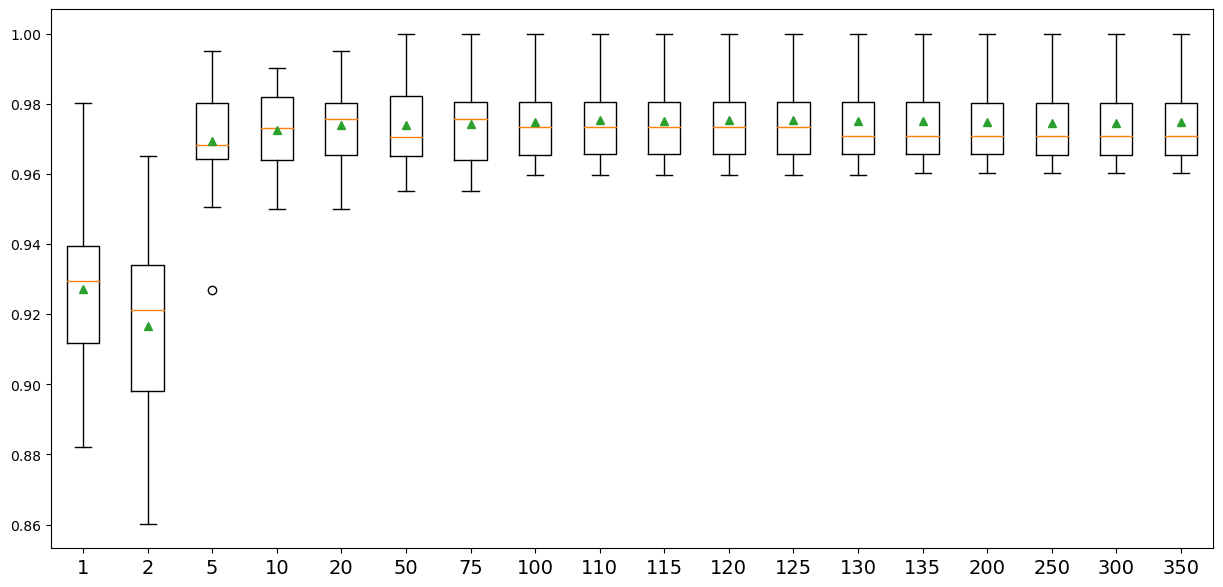

In [79]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         Bagging_i = BaggingClassifier(n_estimators = value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_Bagging),
#                                         ('Bagging_standard',Bagging_i)])     
#     return models

# models = get_models([1,2,5,10,20,50,75,100,110,115,120,125,130,135,200,250,300,350])
# return_results(models,X_train_Bagging)

- Max Samples:

>0.1 0.83621 (0.02955)
>0.2 0.87615 (0.02632)
>0.4 0.92312 (0.02751)
>0.6 0.95324 (0.00984)
>0.8 0.96846 (0.01313)
>1.0 0.97262 (0.01180)


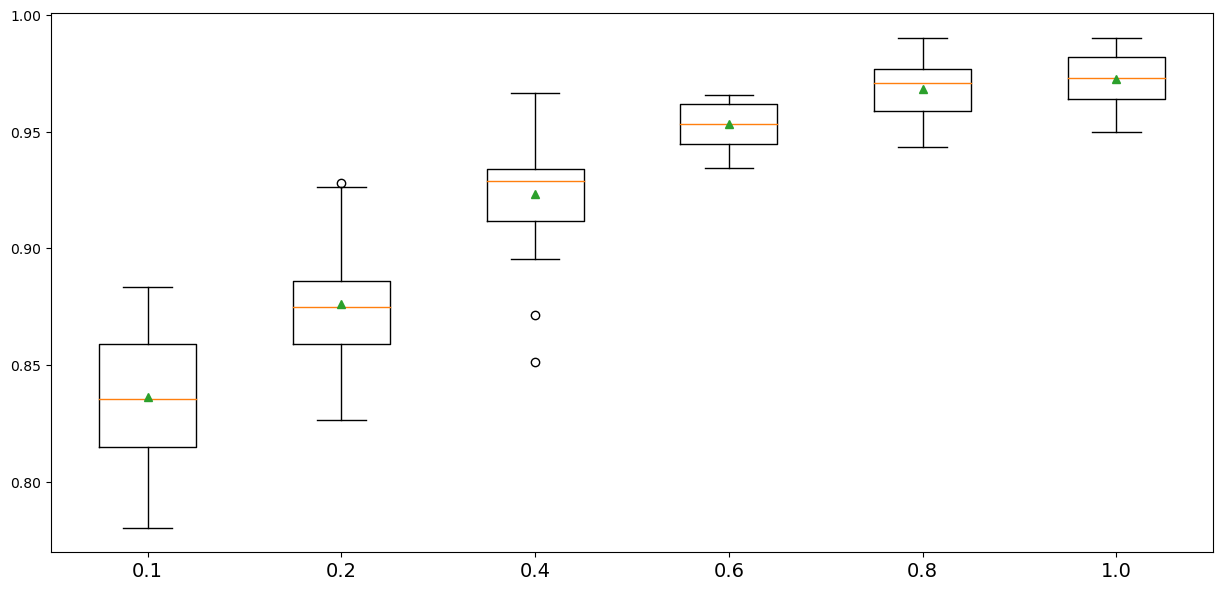

In [81]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         Bagging_i = BaggingClassifier(max_samples=value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_Bagging),
#                                         ('Bagging_standard',Bagging_i)])     
#     return models

# models = get_models([0.1,0.2,0.4,0.6,0.8,1.0])
# return_results(models,X_train_Bagging)

- Max Features:

>0.1 0.83693 (0.02798)
>0.2 0.91621 (0.02870)
>0.4 0.97019 (0.01519)
>0.6 0.97187 (0.01397)
>0.8 0.97217 (0.01120)
>1.0 0.97262 (0.01180)


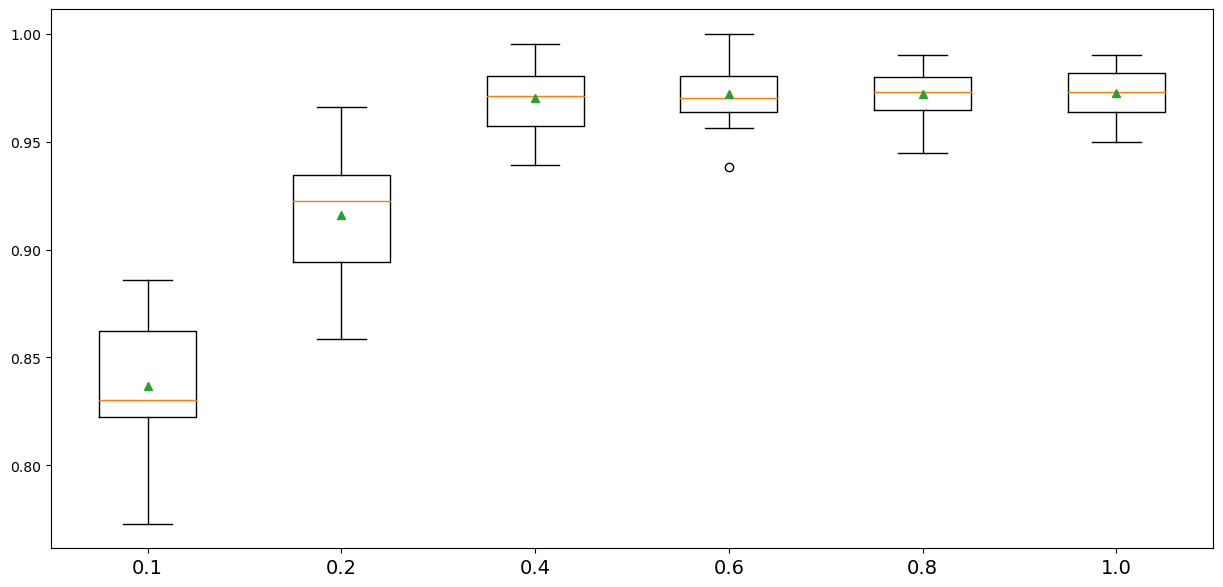

In [82]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         Bagging_i = BaggingClassifier(max_features=value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_Bagging),
#                                         ('Bagging_standard',Bagging_i)])     
#     return models

# models = get_models([0.1,0.2,0.4,0.6,0.8,1.0])
# return_results(models,X_train_Bagging)

- Bootstrap:

>True 0.97262 (0.01180)
>False 0.97569 (0.01515)


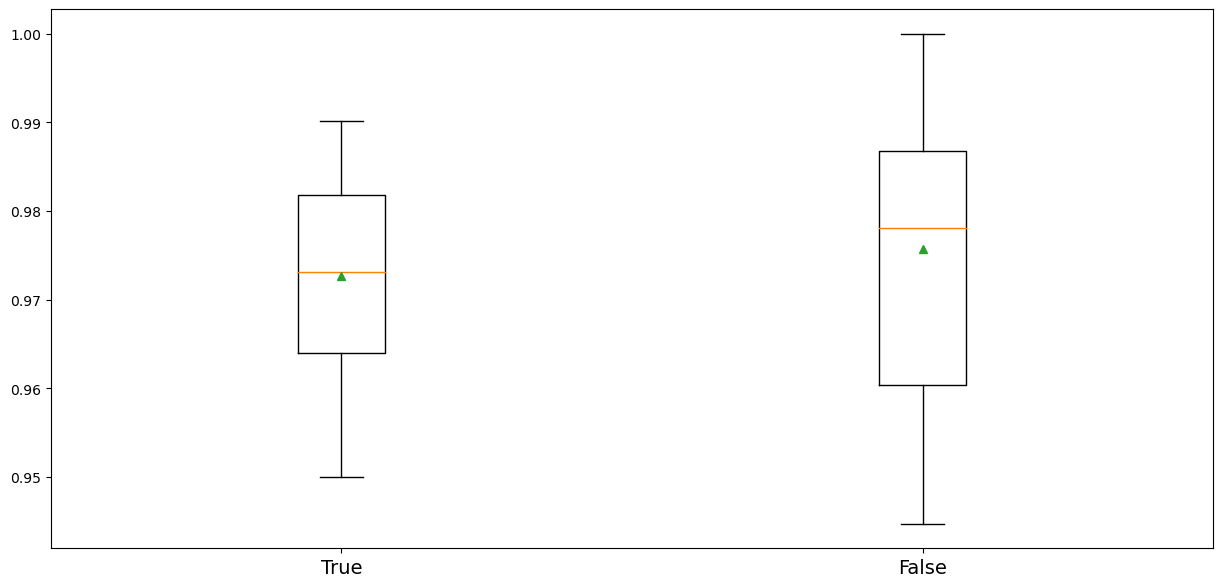

In [83]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         Bagging_i = BaggingClassifier(bootstrap=value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_Bagging),
#                                         ('Bagging_standard',Bagging_i)])     
#     return models

# models = get_models([True,False])
# return_results(models,X_train_Bagging)

- Bootstrap features:

>True 0.96924 (0.01789)
>False 0.97262 (0.01180)


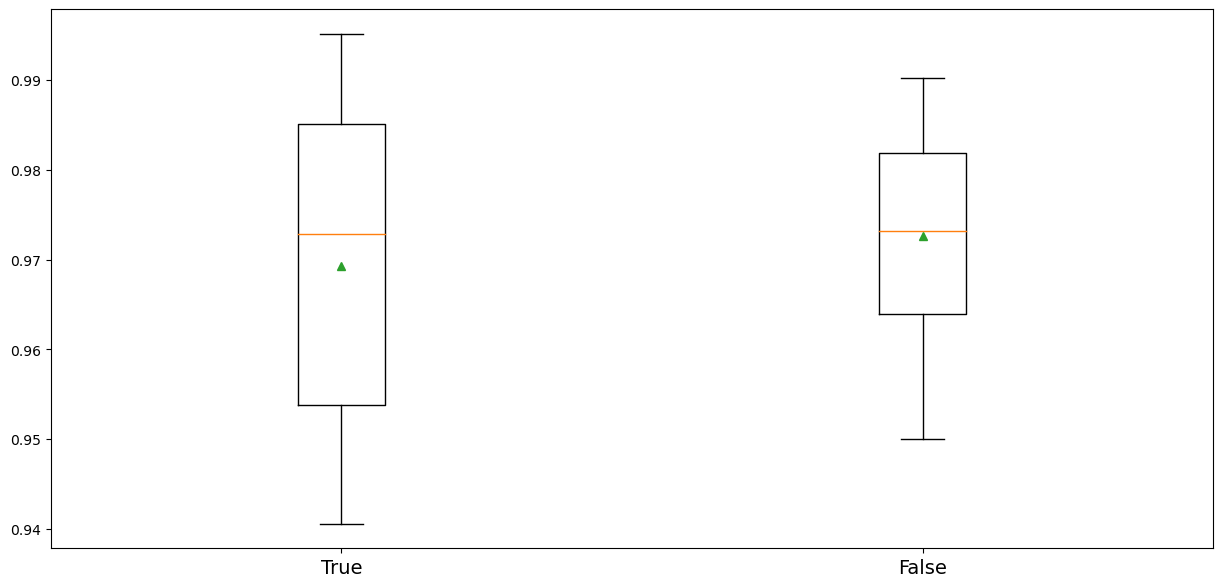

In [84]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         Bagging_i = BaggingClassifier(bootstrap_features=value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_Bagging),
#                                         ('Bagging_standard',Bagging_i)])     
#     return models

# models = get_models([True,False])
# return_results(models,X_train_Bagging)

- Warm Start:

>True 0.97262 (0.01180)
>False 0.97262 (0.01180)


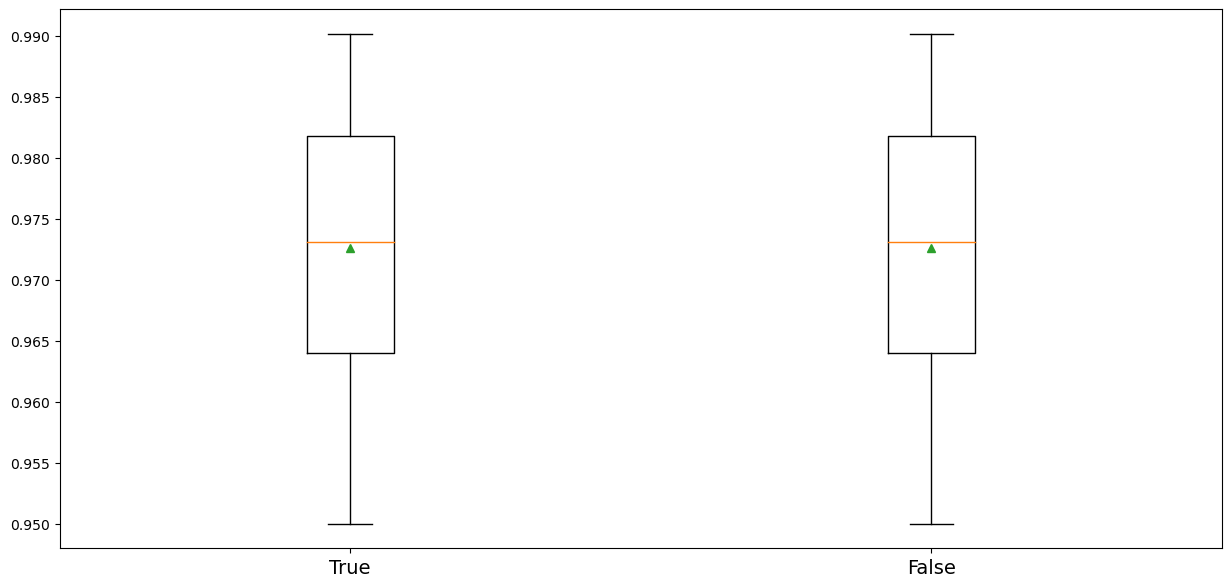

In [85]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         Bagging_i = BaggingClassifier(warm_start=value, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_Bagging),
#                                         ('Bagging_standard',Bagging_i)])     
#     return models

# models = get_models([True,False])
# return_results(models,X_train_Bagging)

- OOB:

>True 0.97262 (0.01180)
>False 0.97262 (0.01180)


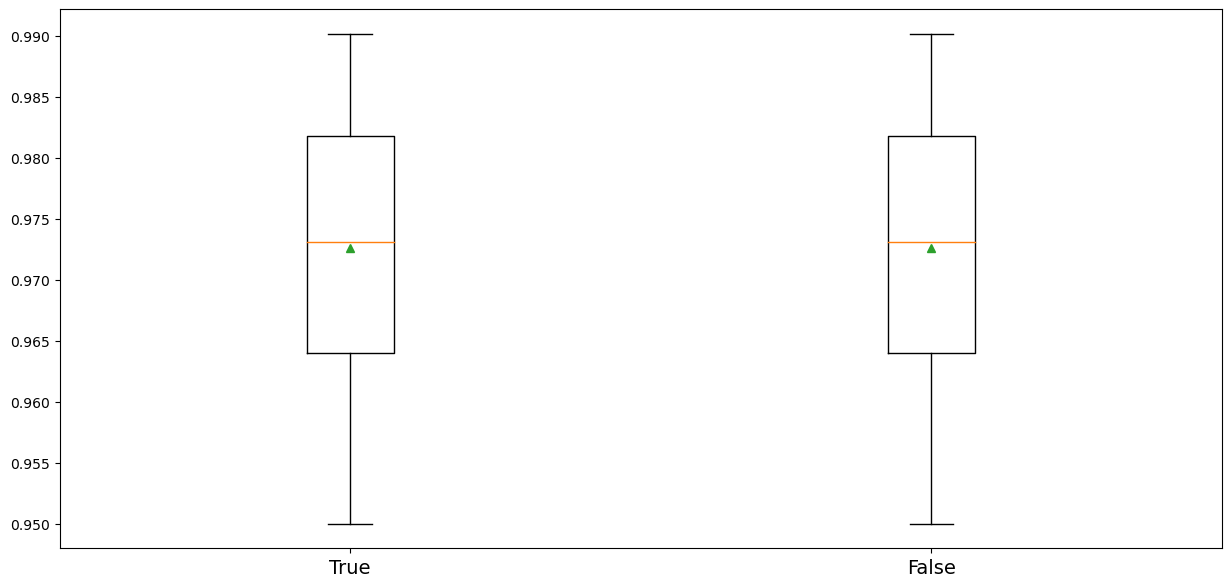

In [86]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         Bagging_i = BaggingClassifier(bootstrap=True,oob_score= values, random_state = 15) 
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_Bagging),
#                                         ('Bagging_standard',Bagging_i)])     
#     return models

# models = get_models([True,False])
# return_results(models,X_train_Bagging)

- __RANDOM SEARCH__

In [91]:
# param_grid = { 
#     'Bagging_standard__n_estimators': [100,120,130,150,200],
#     'Bagging_standard__max_samples': [0.8,1.0],
#     'Bagging_standard__max_features': [0.4,0.6,0.8,1.0],
#     'Bagging_standard__bootstrap': [True, False],
#     'Bagging_standard__bootstrap_features':[True, False]
# } 

# ## Let's do 5 Random searches to be more sure of the parameters we get
# param_list = []
# for search in range(5):
#     CV_Bagg = RandomizedSearchCV(estimator=pipeline_Bagging, param_distributions=param_grid, scoring = 'f1',
#                           cv= RepeatedStratifiedKFold(n_splits=4,random_state=0,n_repeats = 5),verbose = 3)

#     CV_Bagg.fit(X_train_Bagging, y_train)
    
#     param_list.append(CV_Bagg.best_params_)

Fitting 20 folds for each of 10 candidates, totalling 200 fits
[CV 1/20] END Bagging_standard__bootstrap=False, Bagging_standard__bootstrap_features=False, Bagging_standard__max_features=0.8, Bagging_standard__max_samples=0.8, Bagging_standard__n_estimators=150;, score=0.975 total time=   0.2s
[CV 2/20] END Bagging_standard__bootstrap=False, Bagging_standard__bootstrap_features=False, Bagging_standard__max_features=0.8, Bagging_standard__max_samples=0.8, Bagging_standard__n_estimators=150;, score=0.971 total time=   0.2s
[CV 3/20] END Bagging_standard__bootstrap=False, Bagging_standard__bootstrap_features=False, Bagging_standard__max_features=0.8, Bagging_standard__max_samples=0.8, Bagging_standard__n_estimators=150;, score=0.966 total time=   0.2s
[CV 4/20] END Bagging_standard__bootstrap=False, Bagging_standard__bootstrap_features=False, Bagging_standard__max_features=0.8, Bagging_standard__max_samples=0.8, Bagging_standard__n_estimators=150;, score=0.960 total time=   0.2s
[CV 5/20]

In [92]:
# param_list

[{'Bagging_standard__n_estimators': 120,
  'Bagging_standard__max_samples': 0.8,
  'Bagging_standard__max_features': 0.4,
  'Bagging_standard__bootstrap_features': True,
  'Bagging_standard__bootstrap': False},
 {'Bagging_standard__n_estimators': 120,
  'Bagging_standard__max_samples': 0.8,
  'Bagging_standard__max_features': 0.4,
  'Bagging_standard__bootstrap_features': True,
  'Bagging_standard__bootstrap': False},
 {'Bagging_standard__n_estimators': 130,
  'Bagging_standard__max_samples': 1.0,
  'Bagging_standard__max_features': 0.4,
  'Bagging_standard__bootstrap_features': False,
  'Bagging_standard__bootstrap': True},
 {'Bagging_standard__n_estimators': 120,
  'Bagging_standard__max_samples': 1.0,
  'Bagging_standard__max_features': 0.4,
  'Bagging_standard__bootstrap_features': True,
  'Bagging_standard__bootstrap': False},
 {'Bagging_standard__n_estimators': 200,
  'Bagging_standard__max_samples': 1.0,
  'Bagging_standard__max_features': 0.4,
  'Bagging_standard__bootstrap_fea

- __GRID SEARCH__

In [93]:
# param_grid_2 = { 
#     'Bagging_standard__n_estimators': [100,120,130,200],
#     'Bagging_standard__max_samples': [0.8,1.0],
#     'Bagging_standard__max_features': [0.4],
#     'Bagging_standard__bootstrap': [True, False],
#     'Bagging_standard__bootstrap_features':[True, False]
# } 

# grid_Bagging = GridSearchCV(estimator=pipeline_Bagging, param_grid=param_grid_2, scoring = 'f1',
#                           cv= RepeatedStratifiedKFold(n_splits=4,random_state=0,n_repeats = 5),verbose = 3)

# grid_Bagging.fit(X_train_Bagging, y_train)
    
# grid_Bagging.best_params_

Fitting 20 folds for each of 32 candidates, totalling 640 fits
[CV 1/20] END Bagging_standard__bootstrap=True, Bagging_standard__bootstrap_features=True, Bagging_standard__max_features=0.4, Bagging_standard__max_samples=0.8, Bagging_standard__n_estimators=100;, score=0.985 total time=   0.0s
[CV 2/20] END Bagging_standard__bootstrap=True, Bagging_standard__bootstrap_features=True, Bagging_standard__max_features=0.4, Bagging_standard__max_samples=0.8, Bagging_standard__n_estimators=100;, score=0.966 total time=   0.0s
[CV 3/20] END Bagging_standard__bootstrap=True, Bagging_standard__bootstrap_features=True, Bagging_standard__max_features=0.4, Bagging_standard__max_samples=0.8, Bagging_standard__n_estimators=100;, score=0.955 total time=   0.0s
[CV 4/20] END Bagging_standard__bootstrap=True, Bagging_standard__bootstrap_features=True, Bagging_standard__max_features=0.4, Bagging_standard__max_samples=0.8, Bagging_standard__n_estimators=100;, score=0.951 total time=   0.0s
[CV 5/20] END Bag

{'Bagging_standard__bootstrap': False,
 'Bagging_standard__bootstrap_features': False,
 'Bagging_standard__max_features': 0.4,
 'Bagging_standard__max_samples': 1.0,
 'Bagging_standard__n_estimators': 200}

In [94]:
# grid_Bagging.best_params_

{'Bagging_standard__bootstrap': False,
 'Bagging_standard__bootstrap_features': False,
 'Bagging_standard__max_features': 0.4,
 'Bagging_standard__max_samples': 1.0,
 'Bagging_standard__n_estimators': 200}

### 3) Tuning of the base estimator

>gini 0.98115 (0.01230)
>entropy 0.97943 (0.01264)


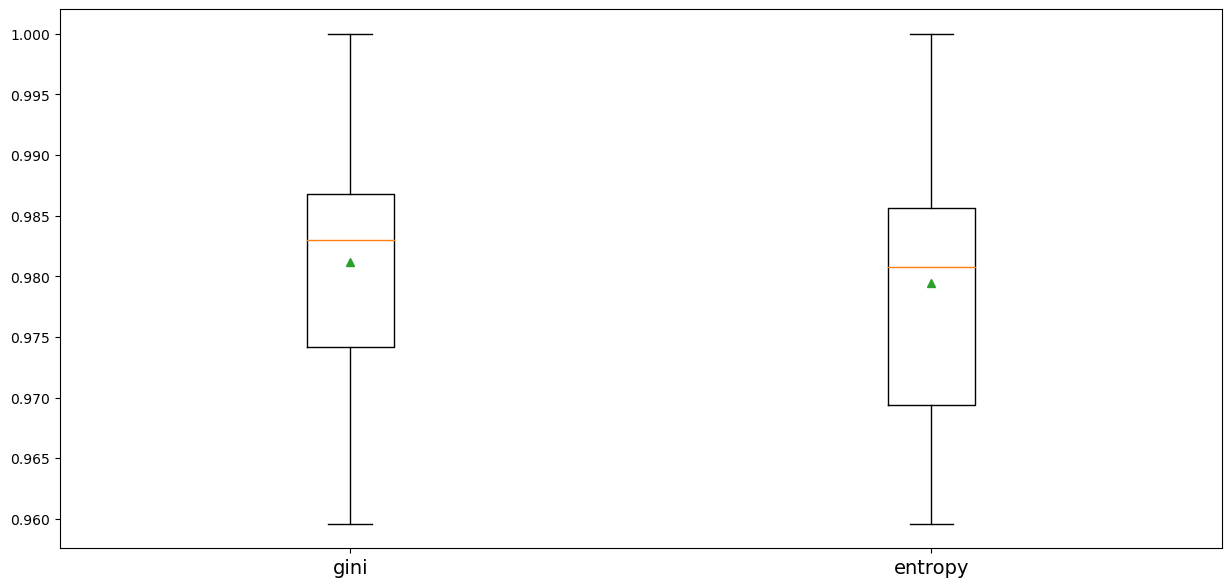

In [112]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         Bagging_i = BaggingClassifier(base_estimator= DecisionTreeClassifier(criterion= value),n_estimators=200,max_features=0.4,max_samples=1.0,bootstrap=False,random_state=15)
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_Bagging),
#                                         ('Bagging',Bagging_i)])     
#     return models

# models = get_models(['gini', 'entropy'])
# return_results(models,X_train_Bagging)

>best 0.98115 (0.01230)
>random 0.98095 (0.01239)


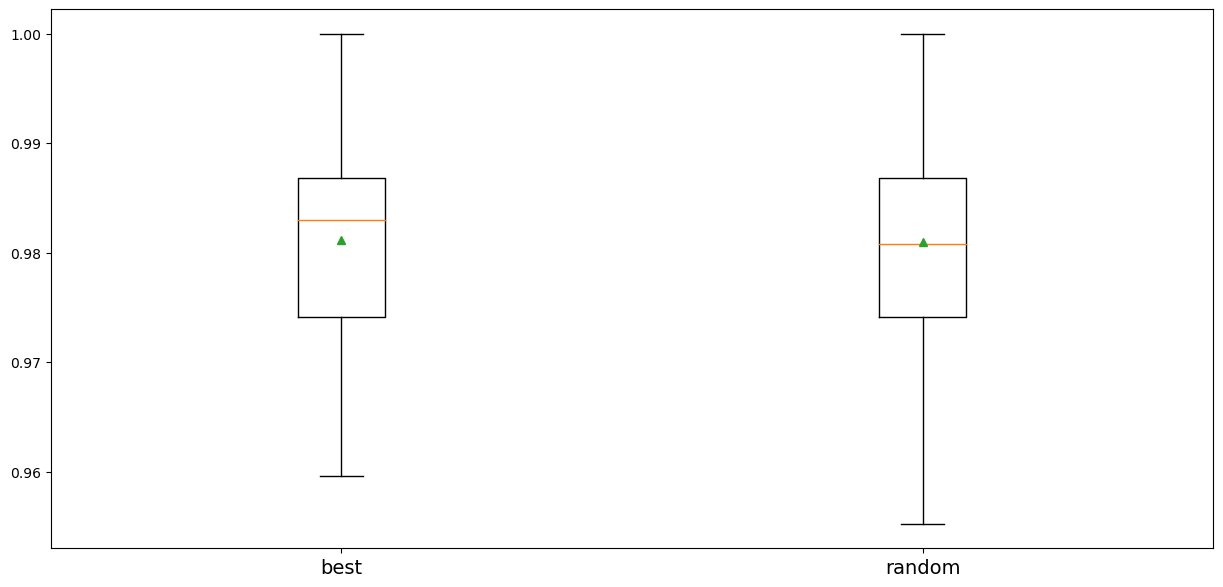

In [113]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         Bagging_i = BaggingClassifier(base_estimator= DecisionTreeClassifier(splitter= value),n_estimators=200,max_features=0.4,max_samples=1.0,bootstrap=False,random_state=15)
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_Bagging),
#                                         ('Bagging',Bagging_i)])     
#     return models

# models = get_models(['best', 'random'])
# return_results(models,X_train_Bagging)

>1 0.81370 (0.02863)
>2 0.85092 (0.02241)
>3 0.87005 (0.01906)
>5 0.93015 (0.02392)
>10 0.97687 (0.01230)
>None 0.98115 (0.01230)


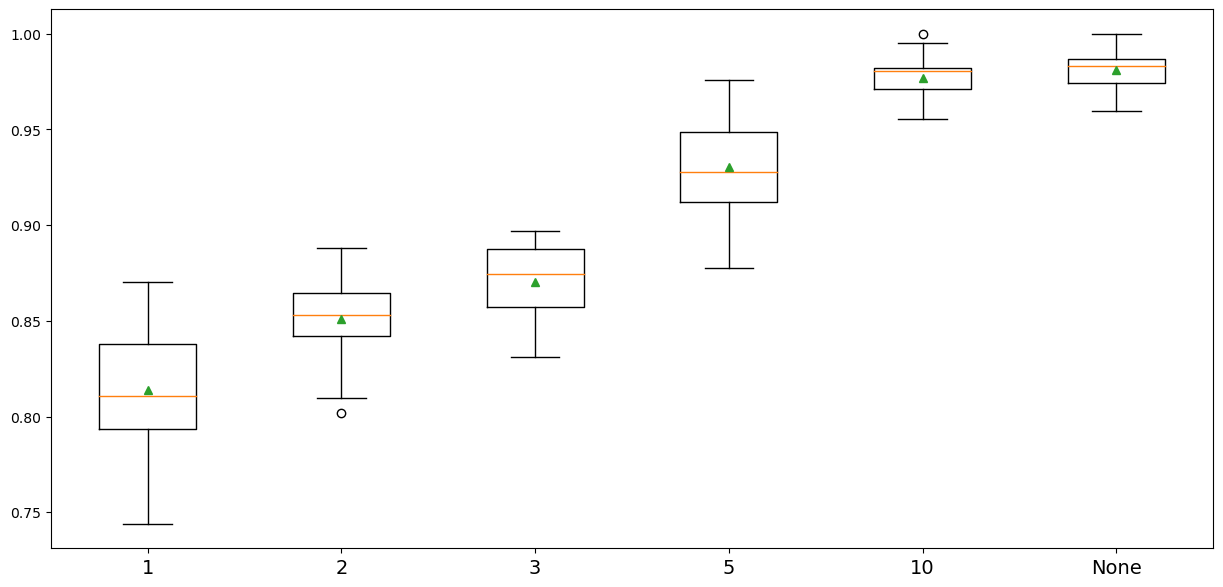

In [115]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         Bagging_i = BaggingClassifier(base_estimator= DecisionTreeClassifier(max_depth= value),n_estimators=200,max_features=0.4,max_samples=1.0,bootstrap=False,random_state=15)
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_Bagging),
#                                         ('Bagging',Bagging_i)])     
#     return models

# models = get_models([1,2,3,5,10,None])
# return_results(models,X_train_Bagging)

>2 0.98115 (0.01230)
>5 0.97880 (0.01337)
>10 0.97475 (0.01500)
>25 0.94588 (0.02255)
>50 0.91275 (0.02190)
>75 0.89374 (0.01883)
>100 0.87995 (0.02149)


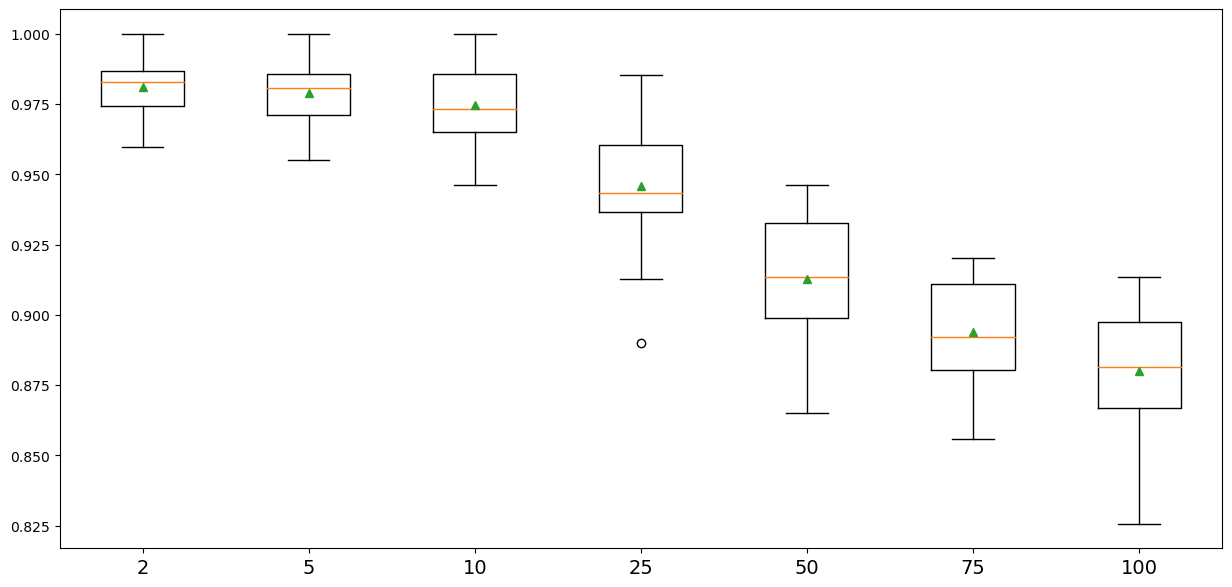

In [117]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         Bagging_i = BaggingClassifier(base_estimator= DecisionTreeClassifier(min_samples_split= value),n_estimators=200,max_features=0.4,max_samples=1.0,bootstrap=False,random_state=15)
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_Bagging),
#                                         ('Bagging',Bagging_i)])     
#     return models

# models = get_models([2,5,10,25,50,75,100])
# return_results(models,X_train_Bagging)

>1 0.98115 (0.01230)
>2 0.97761 (0.01369)
>5 0.95831 (0.02124)
>10 0.92913 (0.02093)
>25 0.87732 (0.01734)
>50 0.85913 (0.02066)
>75 0.85370 (0.02365)
>100 0.84247 (0.02114)


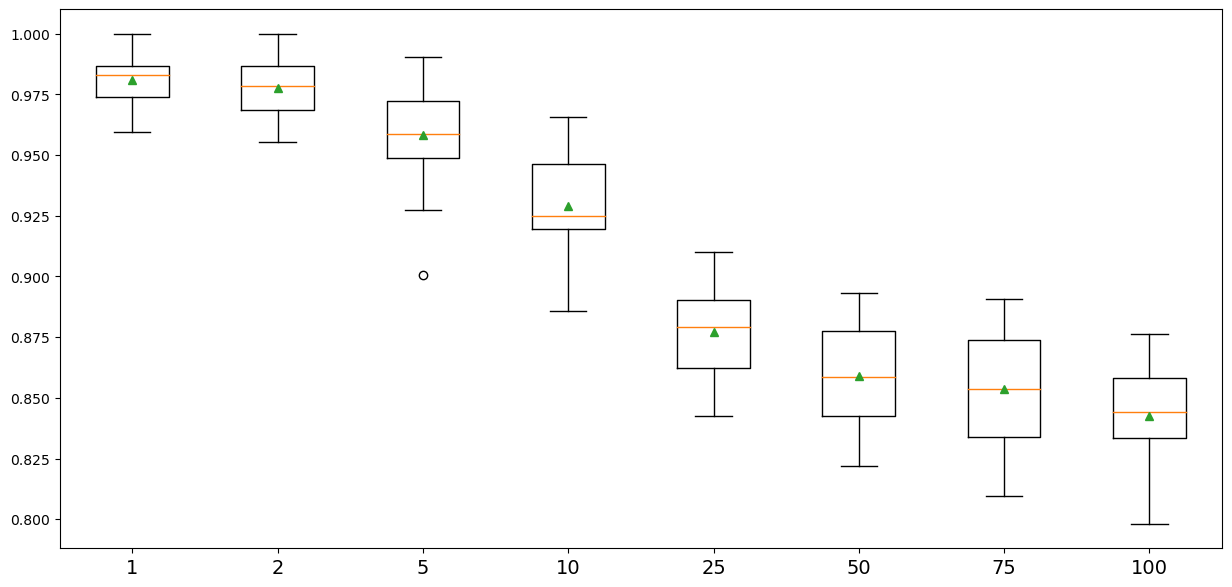

In [118]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         Bagging_i = BaggingClassifier(base_estimator= DecisionTreeClassifier(min_samples_leaf= value),n_estimators=200,max_features=0.4,max_samples=1.0,bootstrap=False,random_state=15)
#         models[str(value)] = Pipeline(steps=[('preprocess',preprocessor_Bagging),
#                                         ('Bagging',Bagging_i)])     
#     return models

# models = get_models([1,2,5,10,25,50,75,100])
# return_results(models,X_train_Bagging)

__--> As we can observe changing the values of the base_estimator only makes the model worse__

### 4) Final Bagging Model:

In [126]:
#Bagging_Final = BaggingClassifier(n_estimators=200,max_features=0.4,max_samples=1.0,bootstrap=False,random_state=15)

#pipeline_Bagging_Final = Pipeline(steps=[('preprocess',preprocessor_Bagging),
                                        #('Bagging_Final',Bagging_Final)])

#all_scores_Bagging = cross_val_score(pipeline_Bagging_Final, X_train_Bagging, y_train,
                             #scoring='f1', cv = rskf4)
#all_scores_Bagging.mean()

0.980135387481984

#### Testing the model

In [168]:
# # X_test = feat_eng(test) # comment if already ran on other models

# X_test_bagging = X_test.loc[:,feat_Bagging]

In [169]:
# pipeline_bagging_grid_fit_pointer = pipeline_Bagging_Final.fit(X_train_Bagging,y_train)

In [221]:
# pred_bagging_grid = pipeline_Bagging_Final.predict(X_test_bagging)

# submission_bagging_grid = pd.DataFrame(pred_bagging_grid, index = X_test_bagging.index).rename(columns= {0:'Disease'})

# submission_bagging_grid.to_csv('Group12_Version07.csv') #1 

## 4.8. Voting Classifier

We have to do it by hand because of the way we want to assess, with cross-validation. Cross val predict will predict on each fold when it is validation and join all predictions.

In [154]:
# #args accepts a tuple (pipeline, dataset used in that pipeline, name), where name is the name of the model

# def hard_voting(*args):

#     df_out = pd.DataFrame(index=args[0][1].index)

#     for arg in args:

#         y_pred = cross_val_predict(arg[0],arg[1], y_train, cv=StratifiedKFold(n_splits=4))

#         df_out [arg[2]+'_pred'] = y_pred
        
#     df_out ['final_pred'] = df_out.mode(axis=1)
    
#     df_out['y_train'] = y_train
        
#     return df_out

In [155]:
# def soft_voting(*args):

#     df_out = pd.DataFrame(index=args[0][1].index)

#     for arg in args:

#         y_pred = cross_val_predict(arg[0],arg[1], y_train, cv=StratifiedKFold(n_splits=4),
#                                   method='predict_proba')
        
#         #print(y_pred)

#         df_out [arg[2]+'_pred0'] = y_pred[:, 0]
#         df_out [arg[2]+'_pred1'] = y_pred[:, 1]
        
#     df_out['y_train'] = y_train
        
#     return df_out

In [156]:
# et_grid = ExtraTreesClassifier(random_state=15, criterion= 'gini', n_estimators =130,
#                                max_features= 'sqrt',class_weight =None)

# final_et = pipeline_et_grid = Pipeline(steps=[('preprocess',preprocessor_et),
#                                         ('et_grid',et_grid)])

# Best_KNN_1= KNeighborsClassifier(n_neighbors=1, metric='manhattan', weights='uniform')

# final_knn = pipeline_KNN_final = Pipeline(steps=[('preprocess',preprocessor_KNN_final),
#                                         ('KKN',Best_KNN_1)])

# best_adam = MLPClassifier(random_state=15, max_iter=5000, learning_rate_init=0.01, hidden_layer_sizes =(25,25), activation = 'relu')

# final_mlp = pipeline_mlp_final = Pipeline(steps=[('preprocess',preprocessor_nn),
#                                         ('mlp',best_adam)])


# Bagging_Final = BaggingClassifier(n_estimators=200,max_features=0.4,max_samples=1.0,bootstrap=False,random_state=15)

# final_bag = Pipeline(steps=[('preprocess',preprocessor_Bagging),
#                                         ('Bagging_Final',Bagging_Final)])


# gb_grid = GradientBoostingClassifier(init = ExtraTreesClassifier(random_state=15),
#                                      random_state=15, subsample = 0.75, n_estimators =250,
#                                     max_depth=4, learning_rate = 0.5,loss = 'exponential')

# final_gb = Pipeline(steps=[('preprocess',preprocessor_gb),
#                                         ('gb_grid',gb_grid)])


In [157]:
# soft_voting_df = soft_voting(
#        (final_et, X_train_et, 'et'),
#        (final_mlp, X_train_nn, 'mlp'))
# soft_voting_df

et_pred0  et_pred1     mlp_pred0     mlp_pred1  y_train
PatientID                                                         
1167       0.053846  0.946154  2.590124e-01  7.409876e-01        1
1805       0.000000  1.000000  1.580893e-01  8.419107e-01        1
1557       0.038462  0.961538  1.241835e-02  9.875817e-01        1
1658       0.953846  0.046154  9.999986e-01  1.392594e-06        0
1544       0.000000  1.000000  2.961903e-01  7.038097e-01        1
...             ...       ...           ...           ...      ...
1909       0.930769  0.069231  9.219103e-01  7.808975e-02        0
1386       0.000000  1.000000  4.440892e-16  1.000000e+00        1
1088       0.992308  0.007692  1.000000e+00  1.061997e-12        0
1662       0.000000  1.000000  3.025898e-03  9.969741e-01        1
1117       0.946154  0.053846  1.000000e+00  1.421546e-10        0

[800 rows x 5 columns]

In [158]:
# soft_voting_df['avg_0'] = soft_voting_df[['et_pred0', 'mlp_pred0']].mean(axis=1)
# soft_voting_df['avg_1'] = soft_voting_df[['et_pred1', 'mlp_pred1']].mean(axis=1)
# soft_voting_df

et_pred0  et_pred1     mlp_pred0     mlp_pred1  y_train  \
PatientID                                                            
1167       0.053846  0.946154  2.590124e-01  7.409876e-01        1   
1805       0.000000  1.000000  1.580893e-01  8.419107e-01        1   
1557       0.038462  0.961538  1.241835e-02  9.875817e-01        1   
1658       0.953846  0.046154  9.999986e-01  1.392594e-06        0   
1544       0.000000  1.000000  2.961903e-01  7.038097e-01        1   
...             ...       ...           ...           ...      ...   
1909       0.930769  0.069231  9.219103e-01  7.808975e-02        0   
1386       0.000000  1.000000  4.440892e-16  1.000000e+00        1   
1088       0.992308  0.007692  1.000000e+00  1.061997e-12        0   
1662       0.000000  1.000000  3.025898e-03  9.969741e-01        1   
1117       0.946154  0.053846  1.000000e+00  1.421546e-10        0   

                  avg_0     avg_1  
PatientID                          
1167       1.564293e-01  0.843571  
1805       7.904467e-02  0.920955  
1557       2.543994e-02  0.974560  
1658       9.769224e-01  0.023078  
1544       1.480952e-01  0.851905  
...                 ...       ...  
1909       9.263397e-01  0.073660  
1386       2.220446e-16  1.000000  
1088       9.961538e-01  0.003846  
1662       1.512949e-03  0.998487  
1117       9.730769e-01  0.026923  

[800 rows x 7 columns]

In [159]:
# soft_voting_df["final_pred"] = soft_voting_df.apply(lambda x: 0 if (x.avg_0 > x.avg_1) else 1, axis=1)

# soft_voting_df

et_pred0  et_pred1     mlp_pred0     mlp_pred1  y_train  \
PatientID                                                            
1167       0.053846  0.946154  2.590124e-01  7.409876e-01        1   
1805       0.000000  1.000000  1.580893e-01  8.419107e-01        1   
1557       0.038462  0.961538  1.241835e-02  9.875817e-01        1   
1658       0.953846  0.046154  9.999986e-01  1.392594e-06        0   
1544       0.000000  1.000000  2.961903e-01  7.038097e-01        1   
...             ...       ...           ...           ...      ...   
1909       0.930769  0.069231  9.219103e-01  7.808975e-02        0   
1386       0.000000  1.000000  4.440892e-16  1.000000e+00        1   
1088       0.992308  0.007692  1.000000e+00  1.061997e-12        0   
1662       0.000000  1.000000  3.025898e-03  9.969741e-01        1   
1117       0.946154  0.053846  1.000000e+00  1.421546e-10        0   

                  avg_0     avg_1  final_pred  
PatientID                                      
1167       1.564293e-01  0.843571           1  
1805       7.904467e-02  0.920955           1  
1557       2.543994e-02  0.974560           1  
1658       9.769224e-01  0.023078           0  
1544       1.480952e-01  0.851905           1  
...                 ...       ...         ...  
1909       9.263397e-01  0.073660           0  
1386       2.220446e-16  1.000000           1  
1088       9.961538e-01  0.003846           0  
1662       1.512949e-03  0.998487           1  
1117       9.730769e-01  0.026923           0  

[800 rows x 8 columns]

In [160]:
# #final f1_score
# f1_score(soft_voting_df['y_train'], soft_voting_df['final_pred'])

0.9759036144578314

In [161]:
# hard_voting_df = hard_voting((final_et,X_train_et, 'et'),
#        (final_knn, X_train_KNN_final, 'knn'),
#        (final_mlp, X_train_nn, 'mlp'))

In [162]:
# f1_score(hard_voting_df['y_train'], hard_voting_df['final_pred'])

0.9748502994011976

In [163]:
# hard_voting_df[(hard_voting_df['final_pred']!=hard_voting_df['y_train'])]

et_pred  knn_pred  mlp_pred  final_pred  y_train
PatientID                                                  
1861             1         0         1           1        0
1937             1         0         1           1        0
1746             1         0         1           1        0
1036             0         1         0           0        1
1720             1         0         1           1        0
1035             1         1         0           1        0
1528             0         1         0           0        1
1028             1         1         1           1        0
1409             1         1         0           1        0
1338             1         1         1           1        0
1717             1         1         1           1        0
1289             1         1         1           1        0
1891             0         1         0           0        1
1257             0         1         0           0        1
1082             1         1         0           1        0
1864             1         1         1           1        0
1843             1         1         1           1        0
1874             1         1         1           1        0
1027             1         1         1           1        0
1911             1         1         1           1        0
1390             1         1         1           1        0

In [164]:
# soft_voting_df[(soft_voting_df['final_pred']!=soft_voting_df['y_train'])]

et_pred0  et_pred1  mlp_pred0  mlp_pred1  y_train     avg_0  \
PatientID                                                                
2004       0.376923  0.623077   0.889029   0.110971        1  0.632976   
1932       0.384615  0.615385   0.889029   0.110971        1  0.636822   
1861       0.046154  0.953846   0.033872   0.966128        0  0.040013   
1937       0.046154  0.953846   0.033872   0.966128        0  0.040013   
1746       0.046154  0.953846   0.033872   0.966128        0  0.040013   
1036       0.576923  0.423077   0.999973   0.000027        1  0.788448   
1720       0.046154  0.953846   0.033872   0.966128        0  0.040013   
1528       0.853846  0.146154   0.996737   0.003263        1  0.925292   
1028       0.284615  0.715385   0.000307   0.999693        0  0.142461   
1338       0.238462  0.761538   0.000307   0.999693        0  0.119384   
1717       0.238462  0.761538   0.000307   0.999693        0  0.119384   
1289       0.292308  0.707692   0.194570   0.805430        0  0.243439   
1891       0.753846  0.246154   0.735362   0.264638        1  0.744604   
1257       0.769231  0.230769   0.735362   0.264638        1  0.752296   
1864       0.176923  0.823077   0.111067   0.888933        0  0.143995   
1843       0.192308  0.807692   0.111067   0.888933        0  0.151687   
1874       0.192308  0.807692   0.111067   0.888933        0  0.151687   
1027       0.292308  0.707692   0.000003   0.999997        0  0.146156   
1911       0.284615  0.715385   0.000003   0.999997        0  0.142309   
1390       0.276923  0.723077   0.000003   0.999997        0  0.138463   

              avg_1  final_pred  
PatientID                        
2004       0.367024           0  
1932       0.363178           0  
1861       0.959987           1  
1937       0.959987           1  
1746       0.959987           1  
1036       0.211552           0  
1720       0.959987           1  
1528       0.074708           0  
1028       0.857539           1  
1338       0.880616           1  
1717       0.880616           1  
1289       0.756561           1  
1891       0.255396           0  
1257       0.247704           0  
1864       0.856005           1  
1843       0.848313           1  
1874       0.848313           1  
1027       0.853844           1  
1911       0.857691           1  
1390       0.861537           1

In [186]:
# #testing hard voting

# hard_test_et = submission_et_grid.copy()
# hard_test_et.rename(columns= {'Disease':'y_pred_et'}, inplace=True)

# hard_test_knn = submission_KNN_grid.copy()
# hard_test_knn.rename(columns= {'Disease':'y_pred_knn'}, inplace=True)
# hard_test_mlp = submission_nn_final.copy()
# hard_test_mlp.rename(columns= {'Disease':'y_pred_mlp'}, inplace=True)

# hard_test_df = hard_test_et.join([hard_test_knn,hard_test_mlp])
# pred_hard_voting = hard_test_df.mode(axis=1)

In [188]:
# submission_hard_voting= pd.DataFrame(pred_hard_voting, index = hard_test_df.index).rename(columns= {0:'Disease'})

In [222]:
#submission_hard_voting.to_csv('Group12_Version08.csv') #1 

In [228]:
# soft_test_et = pipeline_et_grid.predict_proba(X_test_et)
# soft_test_mlp = pipeline_nn_final.predict_proba(X_test_nn)

# soft_test_df = pd.DataFrame(index = X_test.index)

# soft_test_df ['et_pred0'] = soft_test_et[:, 0]
# soft_test_df ['et_pred1'] = soft_test_et[:, 1]

# soft_test_df ['mlp_pred0'] = soft_test_mlp[:, 0]
# soft_test_df ['mlp_pred1'] = soft_test_mlp[:, 1]


In [230]:
# soft_test_df['avg_0'] = soft_test_df[['et_pred0', 'mlp_pred0']].mean(axis=1)
# soft_test_df['avg_1'] = soft_test_df[['et_pred1', 'mlp_pred1']].mean(axis=1)

# pred_soft_voting = soft_test_df.apply(lambda x: 0 if (x.avg_0 > x.avg_1) else 1, axis=1)
# submission_soft_voting= pd.DataFrame(pred_soft_voting, index = soft_test_df.index).rename(columns= {0:'Disease'})
# #submission_soft_voting
# submission_soft_voting.to_csv('Group12_Version09.csv') #1 

## 5) Model Assement

In [138]:
#results = []
#labels = ['RFC','ET','GB','SVC','KNN','MLP','Bagging']

In [139]:
#results.append(all_scores_rfc_grid)
#results.append(all_scores_et_grid)
#results.append(all_scores_gb_grid)
#results.append(all_scores_svc_grid)
#results.append(all_scores_KNN_grid)
#results.append(all_scores_nn)
#results.append(all_scores_Bagging)

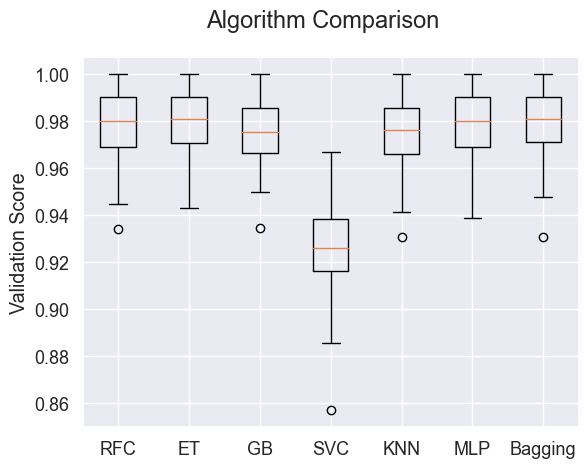

In [151]:
#fig = plt.figure()
#fig.suptitle('Algorithm Comparison')
#ax = fig.add_subplot(111)
#plt.boxplot(results)
#ax.set_xticklabels(labels)
#plt.ylabel('Validation Score')
#plt.savefig('test.png')
#plt.show()